In [91]:
import pandas as pd
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_grid, stat_summary,
    theme, element_text, theme_bw, geom_boxplot, geom_bar, ylim,
    geom_tile, geom_text
)
from plotnine.scales import scale_y_log10, scale_x_log10, scale_x_discrete, scale_y_reverse, scale_fill_cmap
import os

In [2]:
import torch
import numpy as np
from tqdm import tqdm
import math
import json

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
for layers in [1, 2, 3, 4, 8, 12, 16]:
    doc = f"logs/{layers}-1,1,1,1,1-1,0,0,0,0/trainer_state.json"
    with open(doc, "r") as f:
        data = json.load(f)
    train_loss = [x for x in data["log_history"] if "loss" in x][-1]["loss"]
    eval_loss = [x for x in data["log_history"] if "eval_loss" in x][-1]["eval_loss"]
    print(f"\\texttt{{gpt}}$_{layers}$ & ${train_loss:.3f}$ & ${eval_loss:.3f}$ \\\\")

\texttt{gpt}$_1$ & $1.966$ & $1.826$ \\
\texttt{gpt}$_2$ & $2.022$ & $1.854$ \\
\texttt{gpt}$_3$ & $1.446$ & $1.382$ \\
\texttt{gpt}$_4$ & $1.411$ & $1.355$ \\
\texttt{gpt}$_8$ & $1.378$ & $1.336$ \\
\texttt{gpt}$_12$ & $1.370$ & $1.332$ \\
\texttt{gpt}$_16$ & $1.366$ & $1.332$ \\


## ICL

In [4]:
datas = []
for layers in [1, 2, 3, 4, 8, 12, 16]:
    data = pd.read_csv(f"logs/{layers}-1,1,1,1,1-1,0,0,0,0/in_context_probs.csv")
    data['shots'] = data['shots'] + 1
    data['layers'] = layers
    datas.append(data)
data = pd.concat(datas)
data

Unnamed: 0  shots  k  hmm   sft  sft_amount      prob       acc  \
0                0      1  3    0     0           0  0.241505  0.467593   
1                1      1  3    0     1          50  0.351810  0.597222   
2                2      1  3    0     1         250  0.396101  0.643519   
3                3      1  3    0     1         500  0.417139  0.671296   
4                4      1  3    0     1        1000  0.441559  0.726852   
...            ...    ... ..  ...   ...         ...       ...       ...   
135875      135875    256  3    4  3000        2500  0.080811  0.093023   
135876      135876    256  3    4  3000        5000  0.073146  0.098837   
135877      135877    256  3    4  4000        5000  0.073312  0.087209   
135878      135878    256  3    4  5000        5000  0.082771  0.098837   
135879      135879    256  3    4  6000        5000  0.082896  0.093023   

             nll  layers  
0       1.687721       1  
1       1.272345       1  
2       1.091876       1  
3       1.020307       1  
4       0.940289       1  
...          ...     ...  
135875  5.584808      16  
135876  5.784989      16  
135877  5.807393      16  
135878  5.688809      16  
135879  5.799409      16  

[951160 rows x 10 columns]

In [5]:
filter = (data['sft_amount'] == -1)
for sft_amount in data['sft_amount'].unique():
    maxi = data[data['sft_amount'] == sft_amount]['sft'].max()
    filter |= ((data['sft'] == maxi) & (data['sft_amount'] == sft_amount)) 
data = data[filter]

In [6]:
pretrain_data = data[data["sft_amount"] == 0]
pretrain_data["tokens"] = pretrain_data["shots"] * (pretrain_data["k"] + 1)
pretrain_data['k'] = pretrain_data['k'].astype(str)

/tmp/aryaman/ipykernel_1403360/1448983071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/aryaman/ipykernel_1403360/1448983071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


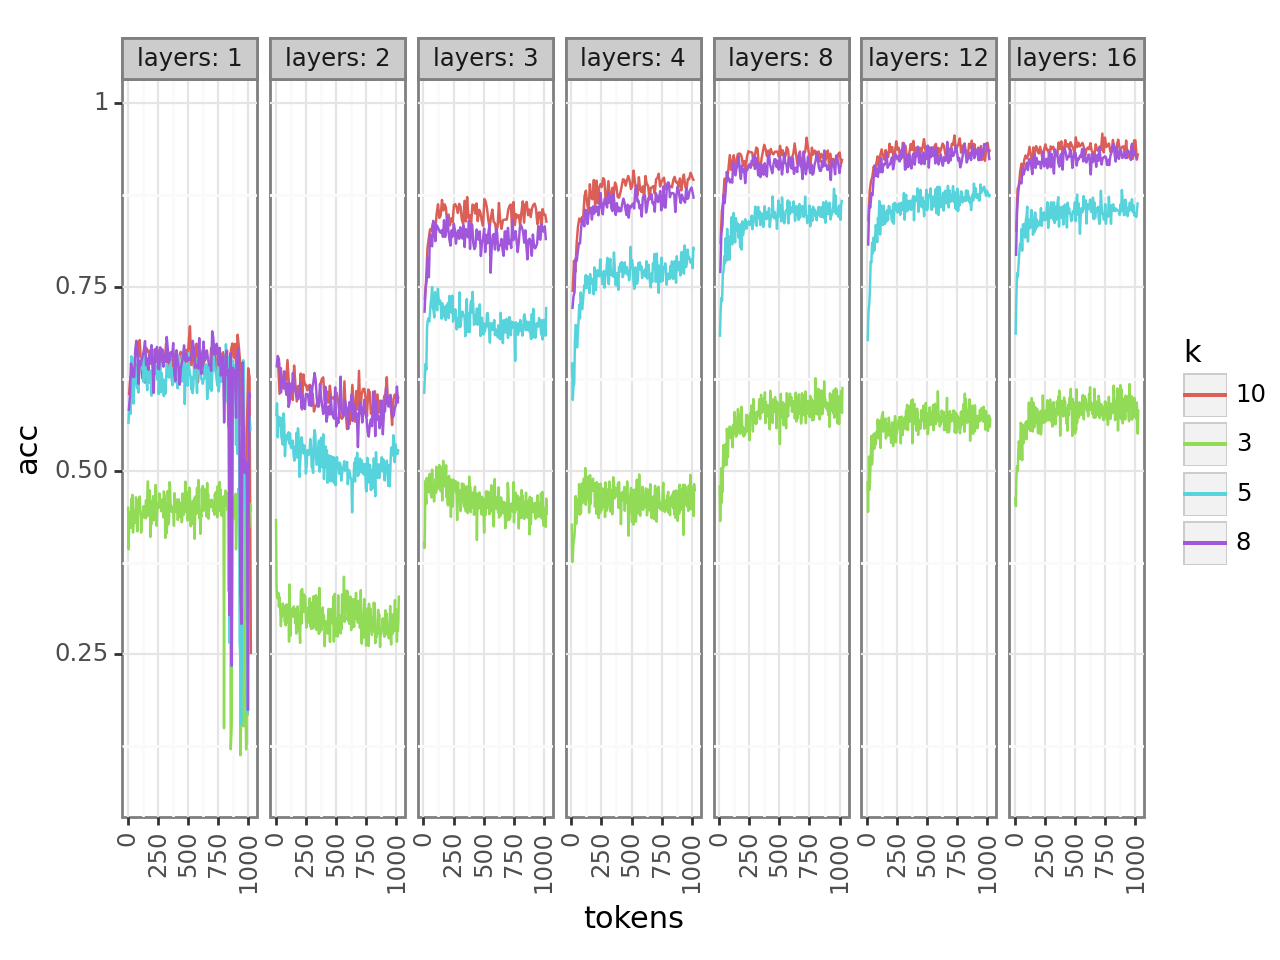

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 2.5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/icl_curve.pdf


In [7]:
plot = (
    ggplot(pretrain_data, aes(x="tokens", y="acc", color="k", group="k")) +
    stat_summary(geom="line") + facet_grid("~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/icl_curve.pdf', width=7, height=2.5)

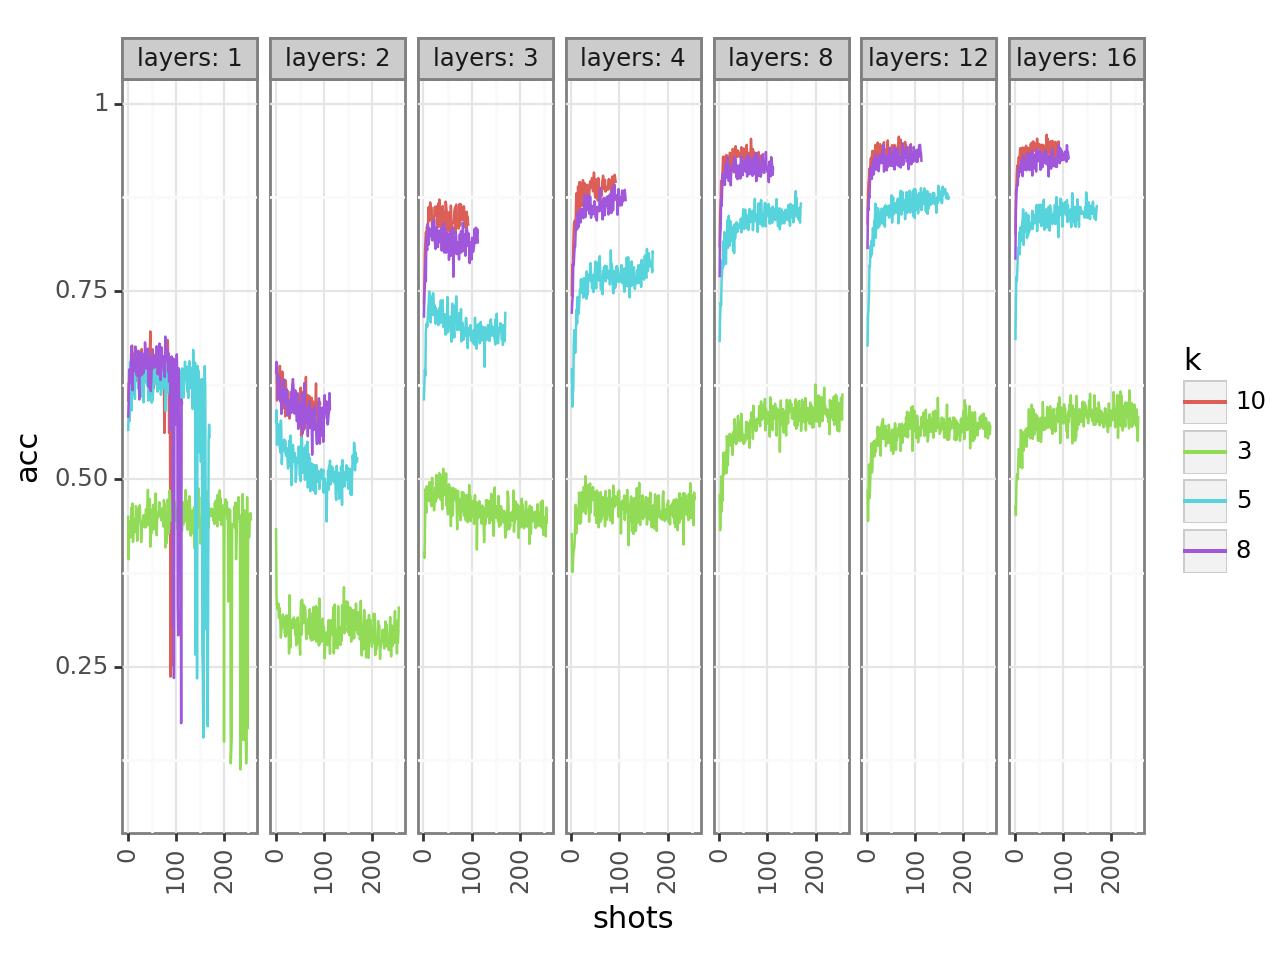

In [8]:
plot = (
    ggplot(pretrain_data, aes(x="shots", y="acc", color="k", group="k")) +
    stat_summary(geom="line") + facet_grid("~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)

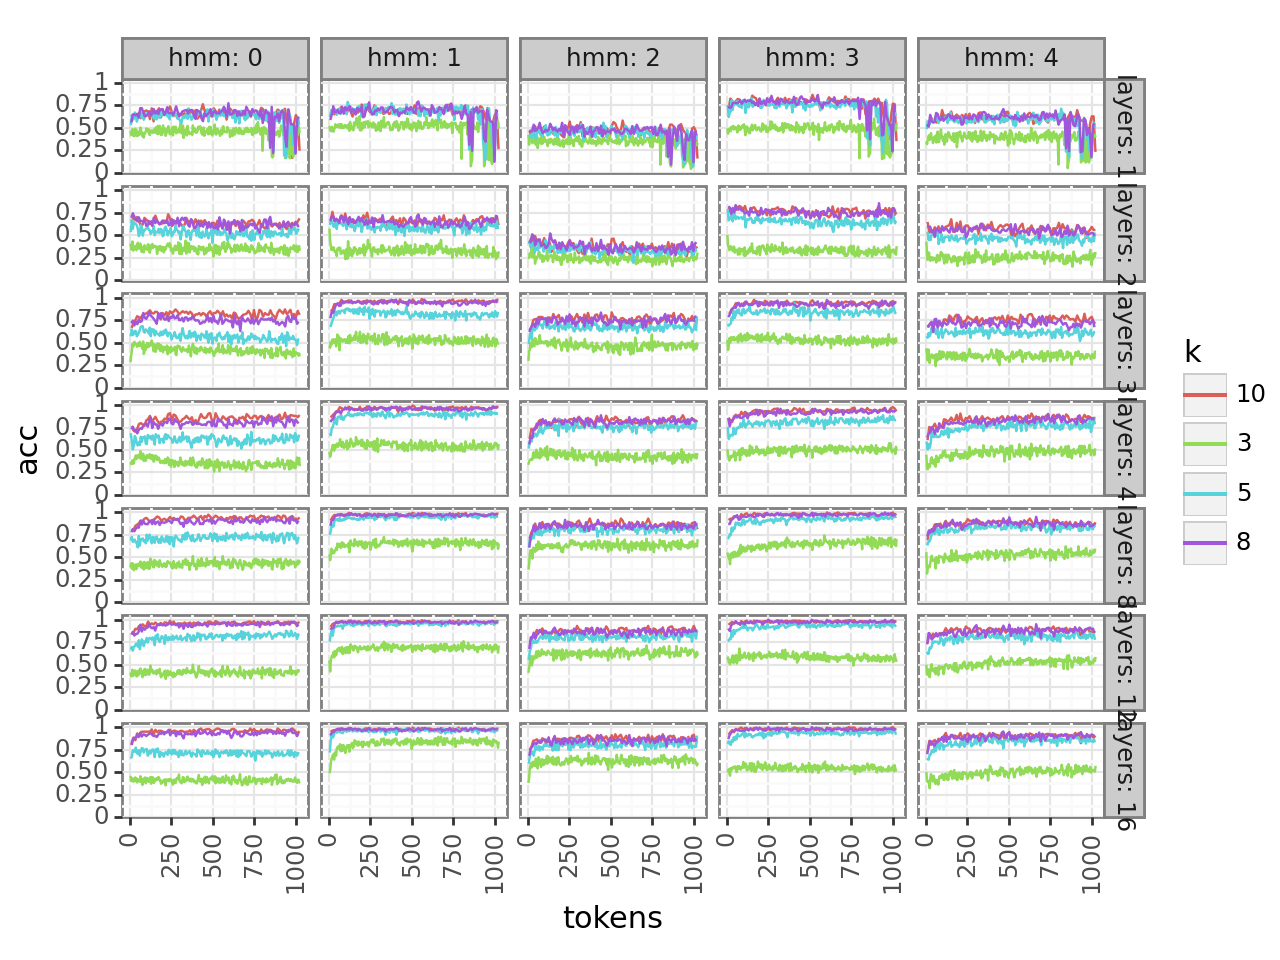

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 7 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/icl_curve_hmm.pdf


In [8]:
plot = (
    ggplot(pretrain_data, aes(x="tokens", y="acc", color="k", group="k")) +
    geom_line() + facet_grid("layers~hmm", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/icl_curve_hmm.pdf', width=7, height=7)

## Bayesian law fits

In [7]:
from analyse import fit_bayesian_law, fit_power_law, power_law_mapping

In [8]:
DEVICE = "cpu"

class BayesianLawFit(torch.nn.Module):
    def __init__(self, num_hmms, sft_amounts=None):
        super(BayesianLawFit, self).__init__()
        self.num_hmms = num_hmms
        self.masks = torch.eye(num_hmms, dtype=torch.bool).to(DEVICE)
        if sft_amounts is not None:
            self.sft_amount_d = {sft: i for i, sft in enumerate(sft_amounts)}
            self.sft_amounts = np.vectorize(self.sft_amount_d.get)
        else:
            sft_amounts = [0]
        self.priors = torch.nn.Parameter(torch.zeros(len(sft_amounts), num_hmms))
        self.P = torch.nn.Parameter((torch.eye(num_hmms, num_hmms) * 2) - 1)
        self.K = torch.nn.Parameter(torch.zeros(len(sft_amounts)))
    
    def get_prior(self, sft_amount=None):
        return torch.nn.functional.softmax(self.priors[sft_amount], dim=-1)

    def get_P(self):
        return torch.sigmoid(self.P)
    
    def get_K(self, sft_amount=None):
        return torch.exp(self.K[sft_amount])

    def get_params(self):
        return {
            "priors": self.get_prior().tolist(),
            "P_0": self.get_P()[0].tolist(),
            "P_1": self.get_P()[1].tolist(),
            "P_2": self.get_P()[2].tolist(),
            "P_3": self.get_P()[3].tolist(),
            "P_4": self.get_P()[4].tolist(),
            "K": self.get_K().tolist(),
        }

    def get_p_under_dist(self, hmm):
        P = self.get_P().log()
        p_under_dist = P[hmm]
        return p_under_dist

    def forward(self, shots, hmm, sft_amount=[0], add_metrics=False):
        priors = self.get_prior(sft_amount).log()
        K = self.get_K(sft_amount)
        shots = shots * K
        if isinstance(shots, torch.Tensor):
            shots = shots.unsqueeze(-1)
        # print("hmm:", hmm)
        # print("K:", self.K.item())
        # print("p(hmm):", priors.exp().tolist())
        p_under_dist = self.get_p_under_dist(hmm)
        # print("p(d | hmm):", p_under_dist.exp().tolist())
        p_seq_under_dist = p_under_dist * shots
        # print("p(D | hmm):", p_seq_under_dist.exp().tolist())
        posteriors = torch.nn.functional.softmax(priors + p_seq_under_dist, dim=-1) # already in log space
        # print("p(hmm | D):", posteriors.tolist())
        p_data = (posteriors * p_under_dist.exp()).sum(dim=-1)
        # print("p(d | D, hmm):", (posteriors * p_under_dist.exp()).tolist())
        # print("p(d | D):", p_data.item())
        est_nll = -torch.log(p_data)
        # print("NLL:", nll, est_nll.item())
        # input()
        if add_metrics:
            return {
                "nll": nll,
                "posteriors": posteriors,
            }
        return est_nll

class BayesianLawSamplingFit(BayesianLawFit):
    def __init__(self, num_hmms, sft_amounts=None):
        super(BayesianLawSamplingFit, self).__init__(num_hmms, sft_amounts)
        self.gammas = torch.nn.Parameter(torch.zeros(num_hmms) + 1)
        self.betas = torch.nn.Parameter(torch.zeros(num_hmms) - 1)
    
    def get_gammas(self):
        return torch.sigmoid(self.gammas)

    def get_betas(self):
        return torch.sigmoid(self.betas) * torch.sigmoid(self.gammas)
    
    def get_params(self):
        return {
            "priors": self.get_prior().tolist(),
            "gammas": self.get_gammas().tolist(),
            "betas": self.get_betas().tolist(),
            "K": self.get_K().tolist(),
        }

    def get_p_under_dist(self, hmm):
        gammas = self.get_gammas().log()
        betas = self.get_betas().log()
        p_under_dist = torch.where(self.masks[hmm], gammas, betas)
        return p_under_dist

class BayesianLawScoringFit(BayesianLawFit):
    def __init__(self, num_hmms, sft_amounts=None):
        super(BayesianLawScoringFit, self).__init__(num_hmms, sft_amounts)
        self.gammas = torch.nn.Parameter(torch.zeros(num_hmms) + 1)
        self.betas = torch.nn.Parameter(torch.zeros(num_hmms) - 1)

    def get_gammas(self):
        return torch.sigmoid(self.gammas)

    def get_betas(self):
        return torch.sigmoid(self.betas) * torch.sigmoid(self.gammas)
    
    def get_K(self, sft_amount=None):
        return torch.exp(self.K[sft_amount])

    def get_params(self):
        return {
            "priors": self.get_prior().tolist(),
            "gammas": self.get_gammas().tolist(),
            "betas": self.get_betas().tolist(),
            "K": self.get_K().tolist(),
        }

    def get_p_under_dist(self, hmm):
        gammas = self.get_gammas().log()
        betas = self.get_betas().log()
        gammas = gammas[hmm].unsqueeze(1).repeat(1, self.num_hmms)
        betas = betas[hmm].unsqueeze(1).repeat(1, self.num_hmms)
        p_under_dist = self.masks[hmm] * (gammas - betas) + betas
        return p_under_dist

In [9]:
bayesian_law_mapping = {
    "original": BayesianLawFit,
    "sampling": BayesianLawSamplingFit,
    "scoring": BayesianLawScoringFit,
}

def fit_bayesian_law(subset: pd.DataFrame, sft_amount=False, type="original", quiet=False):
    # fit power law
    sft_amounts = None if not sft_amount else list(subset['sft_amount'].unique())
    law_type = bayesian_law_mapping[type]
    model = law_type(len(subset['hmm'].unique()), sft_amounts)
    model.to(DEVICE)
    iterator = tqdm(range(50)) if not quiet else range(50)
    patience = 5
    batch_size = 20
    history = []
    subset = subset.sample(frac=1.0)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

    for _ in iterator:
        avg_loss = 0.0
        loss = 0.0
        for i in range(0, len(subset), batch_size):
            optimizer.zero_grad()
            batch = subset.iloc[i:i+batch_size]
            shots = torch.tensor(batch['shots'].values, dtype=torch.float32).to(DEVICE)
            hmm = torch.tensor(list(map(int, batch['hmm'].values)), dtype=torch.int32).to(DEVICE)
            true_nll = torch.tensor(batch['nll'].values, dtype=torch.float32).to(DEVICE)
            if sft_amount:
                sft_amounts = torch.tensor(batch['sft_amount'].values, dtype=int).to(DEVICE)
                est_nll = model(shots, hmm, sft_amounts)
            else:
                est_nll = model(shots, hmm)
            loss = ((true_nll - est_nll)**2).sum()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        # print
        avg_loss /= len(subset)
        history.append(avg_loss)
        if not quiet:
            result = {
                "loss": avg_loss,
            }
            iterator.set_postfix(result)

        # early stopping
        if len(history) > patience and all([math.isclose(history[-1], x, rel_tol=5e-3) for x in history[-patience:]]):
            break
    
    return model


def fit_power_law(subset: pd.DataFrame, type="power", quiet=False):
    # fit power law
    model = power_law_mapping[type]()
    model.to(DEVICE)
    iterator = tqdm(range(50)) if not quiet else range(50)
    patience = 5
    batch_size = 5
    history = []
    subset = subset.sample(frac=1.0)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

    for _ in iterator:
        avg_loss = 0.0
        loss = 0.0
        for i in range(0, len(subset), batch_size):
            optimizer.zero_grad()
            batch = subset.iloc[i:i+batch_size]
            shots = torch.tensor(batch['shots'].values, dtype=torch.float32).to(DEVICE)
            true_nll = torch.tensor(batch['nll'].values, dtype=torch.float32).to(DEVICE)
            est_nll = model(shots)
            loss = ((true_nll - est_nll)**2).sum()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        # print
        avg_loss /= len(subset)
        history.append(avg_loss)
        if not quiet:
            result = {
                "loss": avg_loss,
                "C": model.C.item(),
                "alpha": model.alpha.item(),
                "K": model.K.item(),
            }
            if hasattr(model, 'n_c'):
                result['n_c'] = model.n_c.item()
            iterator.set_postfix(result)

        # early stopping
        if len(history) > patience and all([math.isclose(history[-1], x, rel_tol=5e-3) for x in history[-patience:]]):
            break
    
    return model

In [10]:
from collections import defaultdict
from multiprocessing import Pool
import time

def compute_all_fits(args: tuple):
    # get params
    k, layers, max_shots = args
    all_params = []
    models = {}
    # print(f"k: {k}, layers: {layers}")
    subset = pretrain_data[(pretrain_data["k"] == k) & (pretrain_data["layers"] == layers)]
    max_shots *= subset["shots"].max()
    
    # fit bayesian law
    torch.manual_seed(42 + i)
    np.random.seed(42 + i)
    for law in bayesian_law_mapping.keys():
        bayesian_model = fit_bayesian_law(subset[subset["shots"] <= max_shots], False, law, quiet=True)
        models[(law, k, layers)] = bayesian_model

    # per-hmm fits
    for hmm in range(5):
        subset_hmm = subset[subset['hmm'] == hmm]
        subset_hmm_extrapolate = subset_hmm[subset_hmm["shots"] > max_shots]
        if len(subset_hmm_extrapolate) == 0:
            subset_hmm_extrapolate = subset_hmm
        shots = torch.tensor(subset_hmm_extrapolate['shots'].values, dtype=torch.float32).to(DEVICE)
        hmms = torch.tensor(list(map(int, subset_hmm_extrapolate['hmm'].values)), dtype=torch.int32).to(DEVICE)
        true_nll = torch.tensor(subset_hmm_extrapolate['nll'].values, dtype=torch.float32).to(DEVICE)
        
        # bayesian
        for law in bayesian_law_mapping.keys():
            bayesian_model = models[(law, k, layers)]
            more = bayesian_model.get_params()
            
            est_nll = bayesian_model(shots, hmms)
            bayesian_se = (true_nll - est_nll)**2
            bayesian_rmse = bayesian_se.mean()**0.5
            bayesian_nrmse = bayesian_rmse / (true_nll.mean())
            # print(hmm, bayesian_rmse, bayesian_nrmse)
            params = {
                "k": k,
                "hmm": hmm,
                "layers": layers,
                "law": "bayesian_" + law,
                "rmse": bayesian_rmse,
                "nrmse": bayesian_nrmse,
            }
            for key in more:
                if key == "priors": params[key] = more[key][0][0][hmm]
                elif key == "K": params[key] = more[key][0][0]
                else: params[key] = more[key][hmm]
            all_params.append(params)

        # others
        for law in power_law_mapping.keys():
            torch.manual_seed(42 + i)
            np.random.seed(42 + i)
            model = fit_power_law(subset_hmm[subset_hmm["shots"] <= max_shots], type=law, quiet=True)
            models[(law, k, layers, hmm)] = model
            est_nll = model(shots)
            power_se = (true_nll - est_nll)**2
            power_rmse = power_se.mean()**0.5
            power_nrmse = power_rmse / (true_nll.mean())
            params = {
                "k": k,
                "hmm": hmm,
                "layers": layers,
                "law": law,
                "rmse": power_rmse,
                "nrmse": power_nrmse,
            }
            params.update(model.get_params())
            all_params.append(params)

    # done
    return all_params, models

In [11]:
all_params = {}
all_models = {}

In [24]:
for perc in [0.05, 0.1, 0.2, 0.5]:
    all_args = []
    for i in range(1):
        for k in pretrain_data["k"].unique():
            for layers in pretrain_data["layers"].unique():
                all_args.append((k, layers, perc))
    all_params[perc] = []
    all_models[perc] = {}
    for args in tqdm(all_args):
        some_params, some_models = compute_all_fits(args)
        all_params[perc].extend(some_params)
        all_models[perc].update(some_models)

    df = pd.DataFrame(all_params[perc])
    df["rmse"] = df["rmse"].map(lambda x: x.item())
    df["nrmse"] = df["nrmse"].map(lambda x: x.item())
    print(perc)
    print(df.groupby(["layers", "law"])["nrmse"].mean().unstack().to_latex(float_format="{:.3f}".format))
    print("\n\n")

100%|███████████████████████████████████████████████████████████████████████████████████| 28/28 [00:24<00:00,  1.16it/s]


0.05
\begin{tabular}{lrrrrrr}
\toprule
law & bayesian_original & bayesian_sampling & bayesian_scoring & bounded & logistic & power \\
layers &  &  &  &  &  &  \\
\midrule
1 & 0.365 & 0.397 & 0.371 & 0.197 & 0.514 & 0.253 \\
2 & 0.339 & 0.392 & 0.354 & 0.131 & 0.501 & 0.210 \\
3 & 0.262 & 0.305 & 0.297 & 0.138 & 0.409 & 0.115 \\
4 & 0.221 & 0.273 & 0.254 & 0.200 & 0.385 & 0.142 \\
8 & 0.229 & 0.298 & 0.289 & 0.179 & 0.400 & 0.127 \\
12 & 0.229 & 0.292 & 0.286 & 0.168 & 0.394 & 0.116 \\
16 & 0.247 & 0.308 & 0.290 & 0.172 & 0.417 & 0.129 \\
\bottomrule
\end{tabular}






100%|███████████████████████████████████████████████████████████████████████████████████| 28/28 [00:46<00:00,  1.65s/it]


0.1
\begin{tabular}{lrrrrrr}
\toprule
law & bayesian_original & bayesian_sampling & bayesian_scoring & bounded & logistic & power \\
layers &  &  &  &  &  &  \\
\midrule
1 & 0.321 & 0.343 & 0.314 & 0.192 & 0.269 & 0.206 \\
2 & 0.240 & 0.302 & 0.236 & 0.091 & 0.214 & 0.121 \\
3 & 0.198 & 0.215 & 0.234 & 0.077 & 0.149 & 0.069 \\
4 & 0.168 & 0.179 & 0.196 & 0.128 & 0.125 & 0.102 \\
8 & 0.165 & 0.204 & 0.194 & 0.101 & 0.161 & 0.083 \\
12 & 0.158 & 0.200 & 0.197 & 0.092 & 0.154 & 0.076 \\
16 & 0.166 & 0.210 & 0.207 & 0.094 & 0.174 & 0.075 \\
\bottomrule
\end{tabular}






100%|███████████████████████████████████████████████████████████████████████████████████| 28/28 [01:18<00:00,  2.79s/it]


0.2
\begin{tabular}{lrrrrrr}
\toprule
law & bayesian_original & bayesian_sampling & bayesian_scoring & bounded & logistic & power \\
layers &  &  &  &  &  &  \\
\midrule
1 & 0.264 & 0.313 & 0.259 & 0.203 & 0.246 & 0.208 \\
2 & 0.134 & 0.230 & 0.120 & 0.079 & 0.138 & 0.088 \\
3 & 0.103 & 0.130 & 0.133 & 0.057 & 0.100 & 0.062 \\
4 & 0.094 & 0.101 & 0.112 & 0.079 & 0.101 & 0.065 \\
8 & 0.087 & 0.141 & 0.109 & 0.071 & 0.117 & 0.065 \\
12 & 0.101 & 0.152 & 0.112 & 0.064 & 0.113 & 0.061 \\
16 & 0.099 & 0.155 & 0.116 & 0.058 & 0.117 & 0.060 \\
\bottomrule
\end{tabular}






100%|███████████████████████████████████████████████████████████████████████████████████| 28/28 [02:29<00:00,  5.33s/it]

0.5
\begin{tabular}{lrrrrrr}
\toprule
law & bayesian_original & bayesian_sampling & bayesian_scoring & bounded & logistic & power \\
layers &  &  &  &  &  &  \\
\midrule
1 & 0.253 & 0.262 & 0.253 & 0.245 & 0.246 & 0.247 \\
2 & 0.062 & 0.078 & 0.064 & 0.062 & 0.062 & 0.063 \\
3 & 0.054 & 0.056 & 0.052 & 0.052 & 0.053 & 0.054 \\
4 & 0.053 & 0.054 & 0.052 & 0.053 & 0.053 & 0.053 \\
8 & 0.052 & 0.049 & 0.050 & 0.054 & 0.049 & 0.049 \\
12 & 0.052 & 0.050 & 0.048 & 0.051 & 0.047 & 0.047 \\
16 & 0.054 & 0.047 & 0.047 & 0.048 & 0.046 & 0.047 \\
\bottomrule
\end{tabular}






In [32]:
for perc in [0.05, 0.1, 0.2, 0.5]:
    df = pd.DataFrame(all_params[perc])
    df = df[df["k"] == "10"]
    df["rmse"] = df["rmse"].map(lambda x: x.item())
    df["nrmse"] = df["nrmse"].map(lambda x: x.item())
    print(perc)
    print(df.groupby(["layers", "law"])["nrmse"].mean().unstack().to_latex(float_format="{:.3f}".format))
    print("\n\n")

0.05
\begin{tabular}{lrrrrrr}
\toprule
law & bayesian_original & bayesian_sampling & bayesian_scoring & bounded & logistic & power \\
layers &  &  &  &  &  &  \\
\midrule
1 & 0.351 & 0.372 & 0.373 & 0.154 & 0.743 & 0.267 \\
2 & 0.346 & 0.390 & 0.382 & 0.143 & 0.748 & 0.275 \\
3 & 0.262 & 0.331 & 0.335 & 0.191 & 0.693 & 0.143 \\
4 & 0.194 & 0.301 & 0.301 & 0.199 & 0.683 & 0.140 \\
8 & 0.266 & 0.380 & 0.388 & 0.173 & 0.719 & 0.136 \\
12 & 0.246 & 0.377 & 0.385 & 0.172 & 0.720 & 0.133 \\
16 & 0.255 & 0.384 & 0.389 & 0.171 & 0.720 & 0.133 \\
\bottomrule
\end{tabular}




0.1
\begin{tabular}{lrrrrrr}
\toprule
law & bayesian_original & bayesian_sampling & bayesian_scoring & bounded & logistic & power \\
layers &  &  &  &  &  &  \\
\midrule
1 & 0.294 & 0.339 & 0.301 & 0.135 & 0.262 & 0.165 \\
2 & 0.247 & 0.348 & 0.272 & 0.085 & 0.263 & 0.145 \\
3 & 0.192 & 0.238 & 0.268 & 0.096 & 0.203 & 0.067 \\
4 & 0.183 & 0.233 & 0.254 & 0.108 & 0.188 & 0.066 \\
8 & 0.180 & 0.283 & 0.259 & 0.071 & 0.251 & 

In [26]:
perc = 1.0
all_args = []
for i in range(5):
    for k in pretrain_data["k"].unique():
        for layers in pretrain_data["layers"].unique():
            all_args.append((k, layers, perc))

all_params[perc] = []
all_models[perc] = {}
for args in tqdm(all_args):
    some_params, some_models = compute_all_fits(args)
    all_params[perc].extend(some_params)
    all_models[perc].update(some_models)

100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [17:30<00:00,  7.50s/it]


In [27]:
df = pd.DataFrame(all_params[perc])
df["rmse"] = df["rmse"].map(lambda x: x.item())
df["nrmse"] = df["nrmse"].map(lambda x: x.item())
print(perc)
print(df.groupby(["layers", "law"])["nrmse"].mean().unstack().to_latex(float_format="{:.3f}".format))
print("\n\n")

1.0
\begin{tabular}{lrrrrrr}
\toprule
law & bayesian_original & bayesian_sampling & bayesian_scoring & bounded & logistic & power \\
layers &  &  &  &  &  &  \\
\midrule
1 & 0.180 & 0.180 & 0.181 & 0.180 & 0.179 & 0.181 \\
2 & 0.056 & 0.056 & 0.056 & 0.056 & 0.055 & 0.059 \\
3 & 0.054 & 0.054 & 0.052 & 0.052 & 0.050 & 0.053 \\
4 & 0.054 & 0.054 & 0.052 & 0.055 & 0.052 & 0.055 \\
8 & 0.050 & 0.051 & 0.049 & 0.049 & 0.048 & 0.052 \\
12 & 0.051 & 0.050 & 0.049 & 0.050 & 0.047 & 0.052 \\
16 & 0.050 & 0.049 & 0.048 & 0.050 & 0.047 & 0.052 \\
\bottomrule
\end{tabular}






In [36]:
subset = pretrain_data[(pretrain_data["layers"] == 16) & (pretrain_data["k"] == "5")]

for law in bayesian_law_mapping.keys():
    def estimate_nll(row):
        model = all_models[0.1][(law, str(row['k']), row['layers'])]
        return model(row['shots'], torch.tensor([int(row['hmm'])])).item()
    subset.loc[:, f"est_nll_{law}"] = subset.apply(estimate_nll, axis=1)

# and power law estimates
for law in power_law_mapping.keys():
    def estimate_nll(row):
        model = all_models[0.1][(law, str(row['k']), row['layers'], row['hmm'])]
        model.to("cpu")
        return model(row['shots']).item()
    subset.loc[:, f"est_nll_{law}"] = subset.apply(estimate_nll, axis=1)

# Rename the methods
subset_renamed = subset.rename(columns={
    'est_nll_original': 'Bayesian (original)',
    'est_nll_sampling': 'Bayesian (sampling)',
    'est_nll_scoring': 'Bayesian (scoring)',
    'est_nll_power': 'Power',
    'est_nll_bounded': 'Bounded',
    'est_nll_logistic': 'Logistic'
})

# Reshape the data to a long format
subset_long = subset_renamed.melt(id_vars=['shots', 'nll', 'hmm', 'k'], 
                                  value_vars=[
                                      'Bayesian (original)', 'Bayesian (sampling)', 'Bayesian (scoring)',
                                      'Power', 'Bounded', 'Logistic',
                                  ], 
                                  var_name='method', value_name='nll_value')
subset_long

/tmp/aryaman/ipykernel_1403360/1844445785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/aryaman/ipykernel_1403360/1844445785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/aryaman/ipykernel_1403360/1844445785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

shots       nll  hmm  k               method  nll_value
0         1  1.111248    0  5  Bayesian (original)   1.154369
1         1  1.077968    1  5  Bayesian (original)   1.001045
2         1  1.490890    2  5  Bayesian (original)   1.283516
3         1  0.841091    3  5  Bayesian (original)   0.874642
4         1  1.117562    4  5  Bayesian (original)   1.152482
...     ...       ...  ... ..                  ...        ...
5095    170  1.241541    0  5             Logistic   0.900585
5096    170  0.593542    1  5             Logistic   0.621744
5097    170  0.982257    2  5             Logistic   0.954852
5098    170  0.680328    3  5             Logistic   0.578842
5099    170  0.823474    4  5             Logistic   0.773926

[5100 rows x 6 columns]

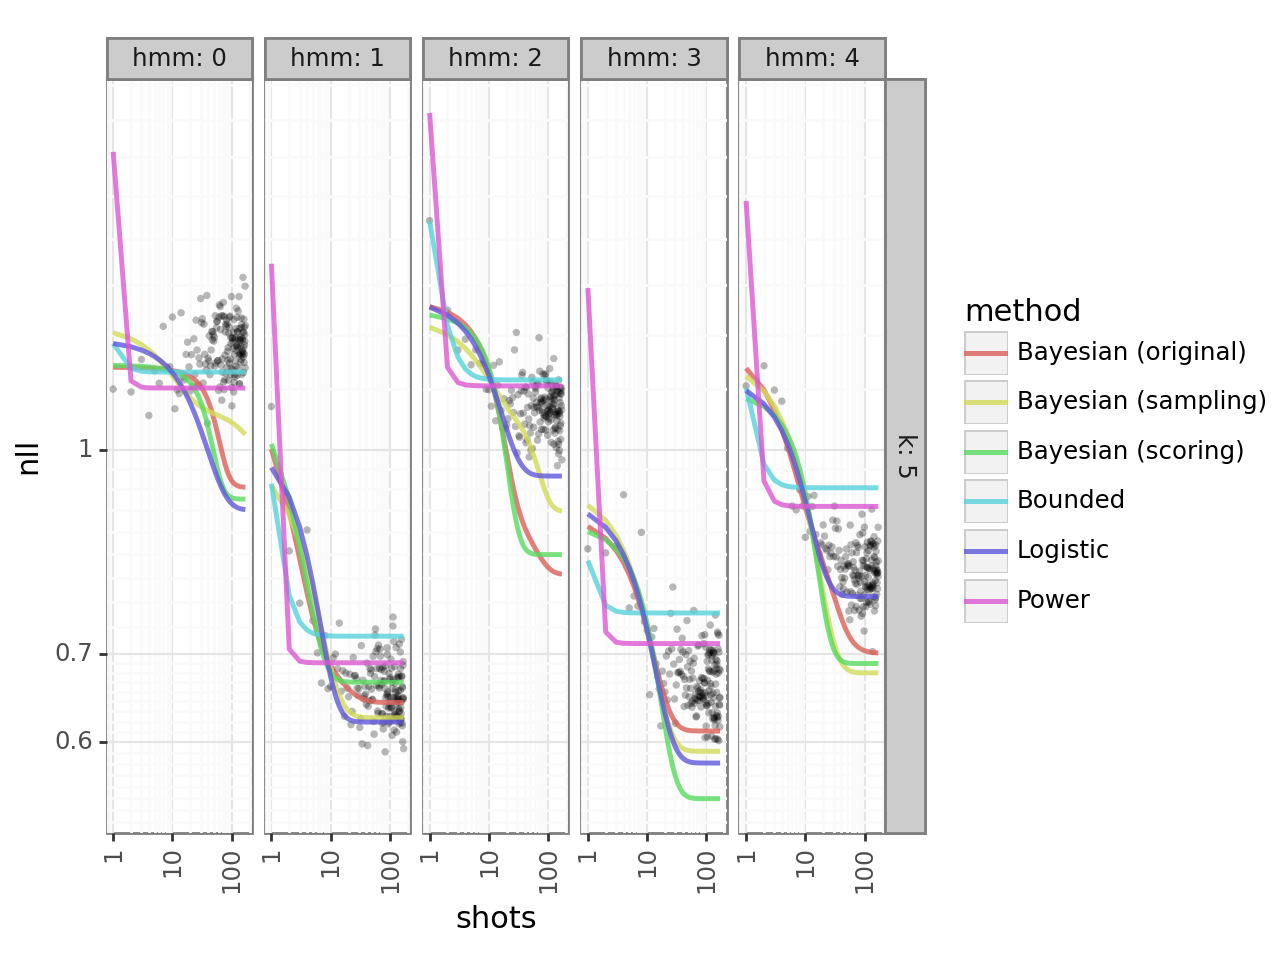

In [37]:
# Plot with the new method names
plot = (
    ggplot(subset_long, aes(x='shots', y='nll')) + 
    geom_point(alpha=0.05, stroke=0) +
    facet_grid("k~hmm", labeller="label_both", scales="free_y") +
    geom_line(aes(x='shots', y='nll_value', color='method'), size=1, alpha=0.8) +
    theme_bw() + 
    theme(axis_text_x=element_text(rotation=90)) +
    scale_x_log10() + scale_y_log10()
)
print(plot)
# plot.save('paper/example_16l_5k.pdf', width=7, height=2.5)

In [138]:
all_params = all_params_half
len(all_params)

4200

In [139]:
len(models)

504

In [69]:
perc = 1.0
params_df = pd.DataFrame(all_params[perc])
params_df.to_csv('paper/params.csv', index=False)
params_df['hmm'] = pd.Categorical(params_df['hmm'], categories=params_df['hmm'].unique(), ordered=False)
params_df['k'] = params_df['k'].astype(int)
params_df['law'] = params_df['law'].map({
    "bayesian_original": "BO",
    "bayesian_sampling": "BSa",
    "bayesian_scoring": "BSc",
    "power": "P",
    "bounded": "Pb",
    "logistic": "L",
})
params_df['nrmse'] = params_df['nrmse'].map(lambda x: x.item())
params_df['rmse'] = params_df['rmse'].map(lambda x: x.item())

In [57]:
params_df

k hmm  layers  law      rmse     nrmse    priors       P_0       P_1  \
0      3   0       1   BO  0.311349  0.170891  0.030595  0.152723  0.190809   
1      3   0       1  BSa  0.301346  0.165401  0.258537       NaN       NaN   
2      3   0       1  BSc  0.306775  0.168380  0.173494       NaN       NaN   
3      3   0       1    P  0.300895  0.165153       NaN       NaN       NaN   
4      3   0       1   Pb  0.299212  0.164230       NaN       NaN       NaN   
...   ..  ..     ...  ...       ...       ...       ...       ...       ...   
4195  10   4      16  BSa  0.032108  0.041382  0.190460       NaN       NaN   
4196  10   4      16  BSc  0.033816  0.043583  0.209581       NaN       NaN   
4197  10   4      16    P  0.037433  0.048245       NaN       NaN       NaN   
4198  10   4      16   Pb  0.032921  0.042430       NaN       NaN       NaN   
4199  10   4      16    L  0.032663  0.042098       NaN       NaN       NaN   

           P_2       P_3       P_4         K    gammas     betas         C  \
0     0.137171  0.181193  0.192801  0.041822       NaN       NaN       NaN   
1          NaN       NaN       NaN  2.217634  0.169385  0.054834       NaN   
2          NaN       NaN       NaN  2.613825  0.174308  0.151450       NaN   
3          NaN       NaN       NaN  1.790818       NaN       NaN  0.436819   
4          NaN       NaN       NaN  1.790255       NaN       NaN  1.106802   
...        ...       ...       ...       ...       ...       ...       ...   
4195       NaN       NaN       NaN  3.699275  0.461348  0.175163       NaN   
4196       NaN       NaN       NaN  3.761879  0.456943  0.220307       NaN   
4197       NaN       NaN       NaN  0.773430       NaN       NaN  0.264245   
4198       NaN       NaN       NaN  0.775675       NaN       NaN  1.365201   
4199       NaN       NaN       NaN  0.238670       NaN       NaN  0.221737   

         alpha       n_c  
0          NaN       NaN  
1          NaN       NaN  
2          NaN       NaN  
3     3.019800       NaN  
4     6.163817  1.067166  
...        ...       ...  
4195       NaN       NaN  
4196       NaN       NaN  
4197  5.272272       NaN  
4198  5.903872  1.286652  
4199  1.881666  0.324191  

[4200 rows x 18 columns]

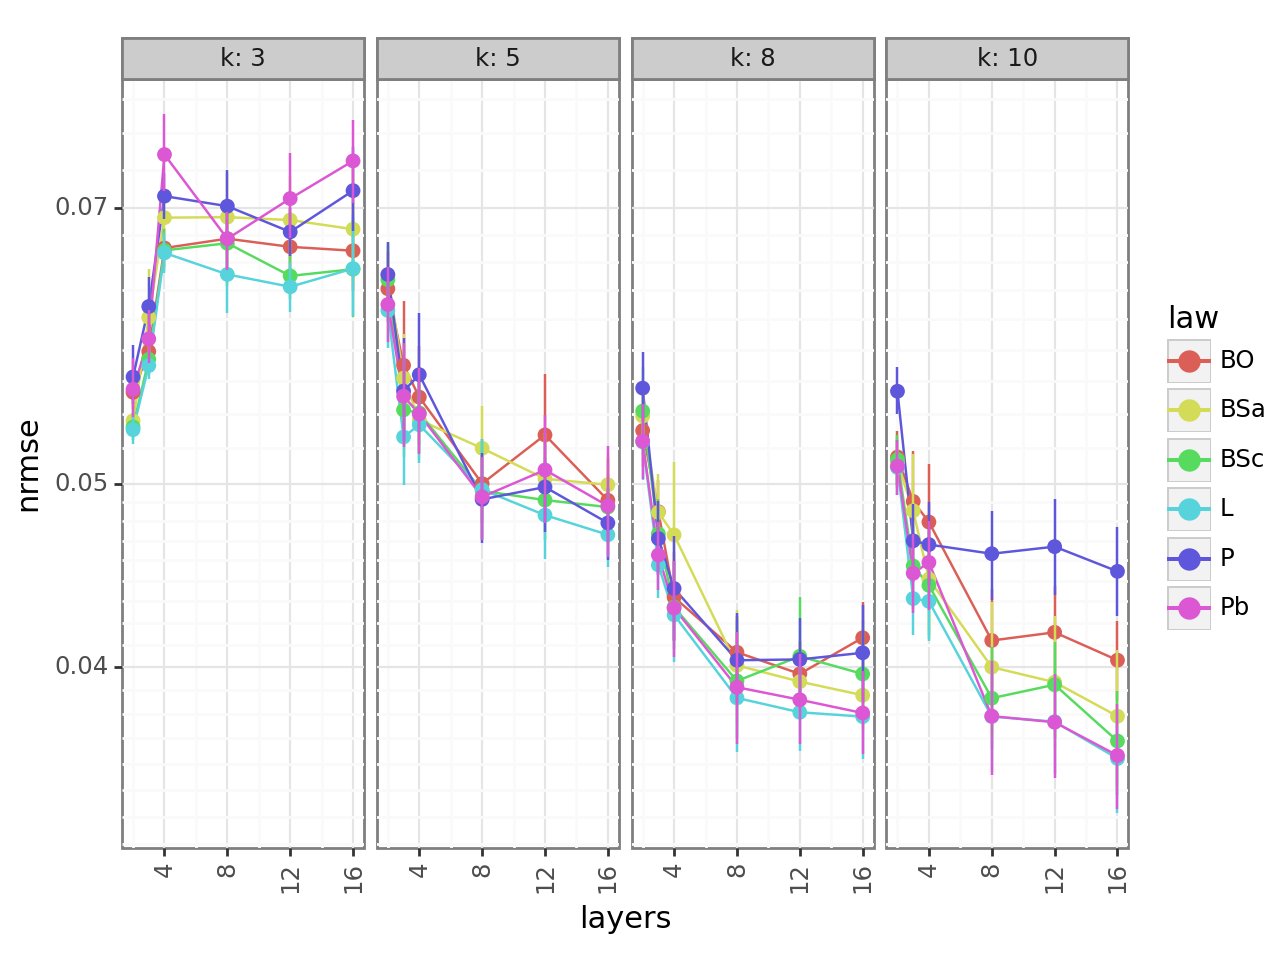

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/law_comparison.pdf


In [58]:
plot = (
    ggplot(params_df[params_df["layers"] > 1], aes(x="layers", y="nrmse", group="law", color="law")) +
    stat_summary(geom="line") + stat_summary() + facet_grid("~k", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_y_log10()
)
print(plot)
plot.save('paper/law_comparison.pdf', width=6, height=3)

In [59]:
for layers in params_df["layers"].unique():
    print(layers, end='')
    for k in params_df["k"].unique():
        print(f" & {k}", end='')
        vals = []
        for law in params_df["law"].unique():
            nrmse = params_df[(params_df["layers"] == layers) & (params_df["k"] == k) & (params_df["law"] == law)]["nrmse"].mean()
            vals.append(nrmse)
        mini = min(vals)
        for val in vals:
            print(f" & ${val:.4f}$" if val != mini else f" & $\\mathbf{{{val:.4f}}}$", end='')
        print(' \\\\')
        

1 & 3 & $0.1927$ & $0.1901$ & $0.1920$ & $0.1906$ & $0.1901$ & $\mathbf{0.1897}$ \\
 & 5 & $0.2116$ & $0.2143$ & $0.2160$ & $0.2162$ & $0.2130$ & $\mathbf{0.2116}$ \\
 & 8 & $0.1892$ & $0.1915$ & $0.1905$ & $0.1909$ & $0.1900$ & $\mathbf{0.1889}$ \\
 & 10 & $0.1261$ & $0.1258$ & $0.1262$ & $0.1270$ & $\mathbf{0.1251}$ & $0.1252$ \\
2 & 3 & $0.0560$ & $0.0541$ & $0.0537$ & $0.0572$ & $0.0564$ & $\mathbf{0.0535}$ \\
 & 5 & $0.0638$ & $0.0647$ & $0.0646$ & $0.0649$ & $0.0626$ & $\mathbf{0.0622}$ \\
 & 8 & $0.0537$ & $0.0546$ & $0.0552$ & $0.0566$ & $0.0530$ & $\mathbf{0.0530}$ \\
 & 10 & $0.0519$ & $0.0515$ & $0.0517$ & $0.0561$ & $0.0513$ & $\mathbf{0.0512}$ \\
3 & 3 & $0.0588$ & $0.0618$ & $0.0583$ & $0.0623$ & $0.0599$ & $\mathbf{0.0578}$ \\
 & 5 & $0.0591$ & $0.0574$ & $0.0554$ & $0.0567$ & $0.0564$ & $\mathbf{0.0535}$ \\
 & 8 & $0.0485$ & $0.0486$ & $0.0473$ & $0.0471$ & $0.0461$ & $\mathbf{0.0455}$ \\
 & 10 & $0.0495$ & $0.0492$ & $0.0456$ & $0.0470$ & $0.0452$ & $\mathbf{0.0437}$ \

['1', '2', '3', '4', '8', '12', '16']


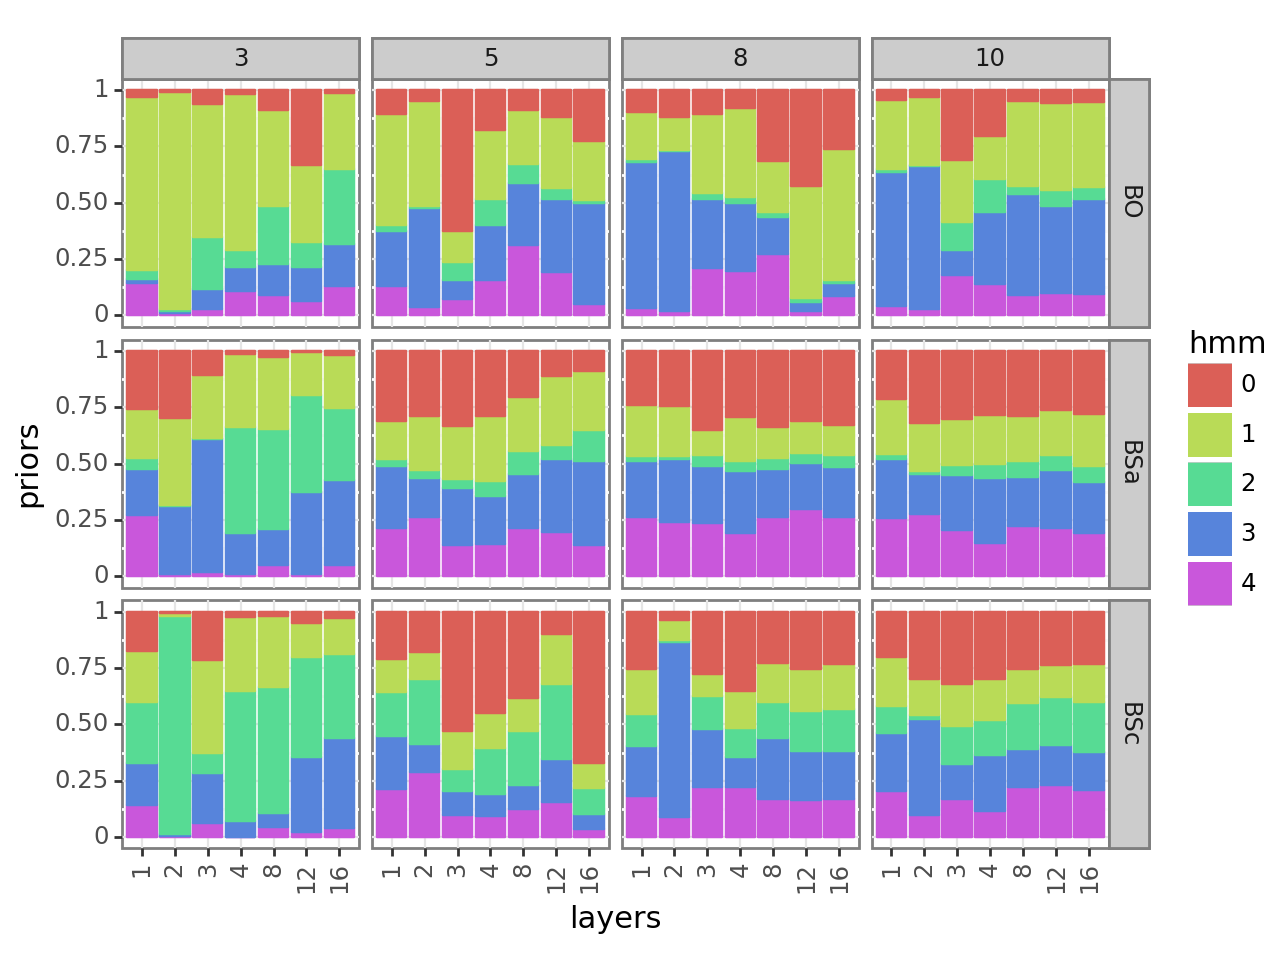

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/priors.pdf


In [60]:
params_df_temp = params_df.copy()
order = list(map(str, sorted(map(int, params_df_temp["layers"].unique()))))
print(order)
params_df_temp["layers"] = pd.Categorical(params_df_temp['layers'].astype(str), categories=order, ordered=True)
plot = (
    ggplot(params_df_temp[params_df_temp["law"].str.startswith("B")], aes(x="layers", y="priors", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="bar", position="stack") + facet_grid("law~k") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/priors.pdf', width=5, height=5)

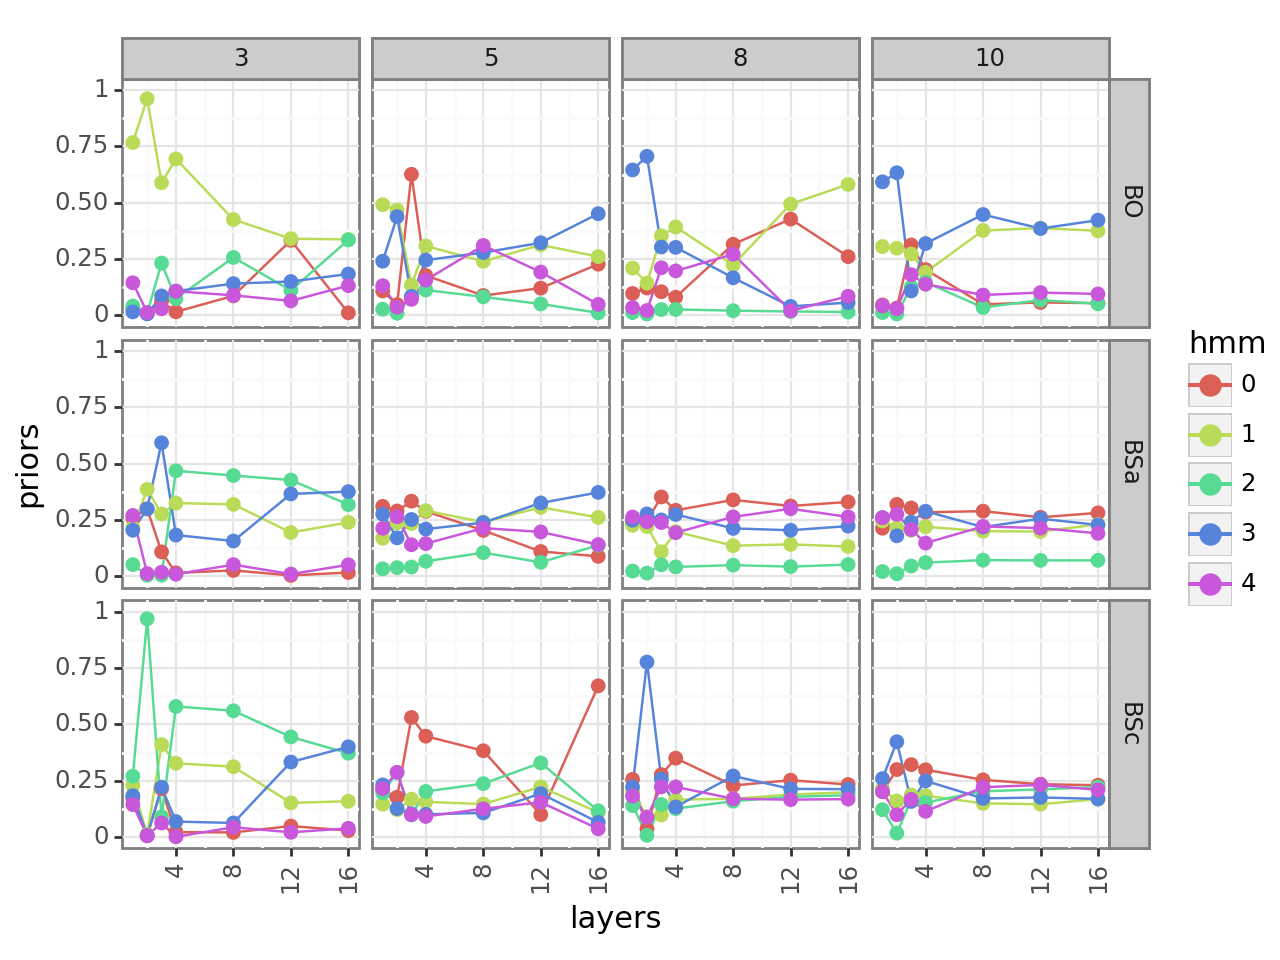

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 2.5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/priors2.pdf


In [62]:
plot = (
    ggplot(params_df[params_df["law"].str.startswith("B")], aes(x="layers", y="priors", group="hmm", color="hmm", fill="hmm")) +
    stat_summary(geom="line") + stat_summary() + facet_grid("law~k")
    + ylim(0, 1) + theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/priors2.pdf', width=5, height=2.5)

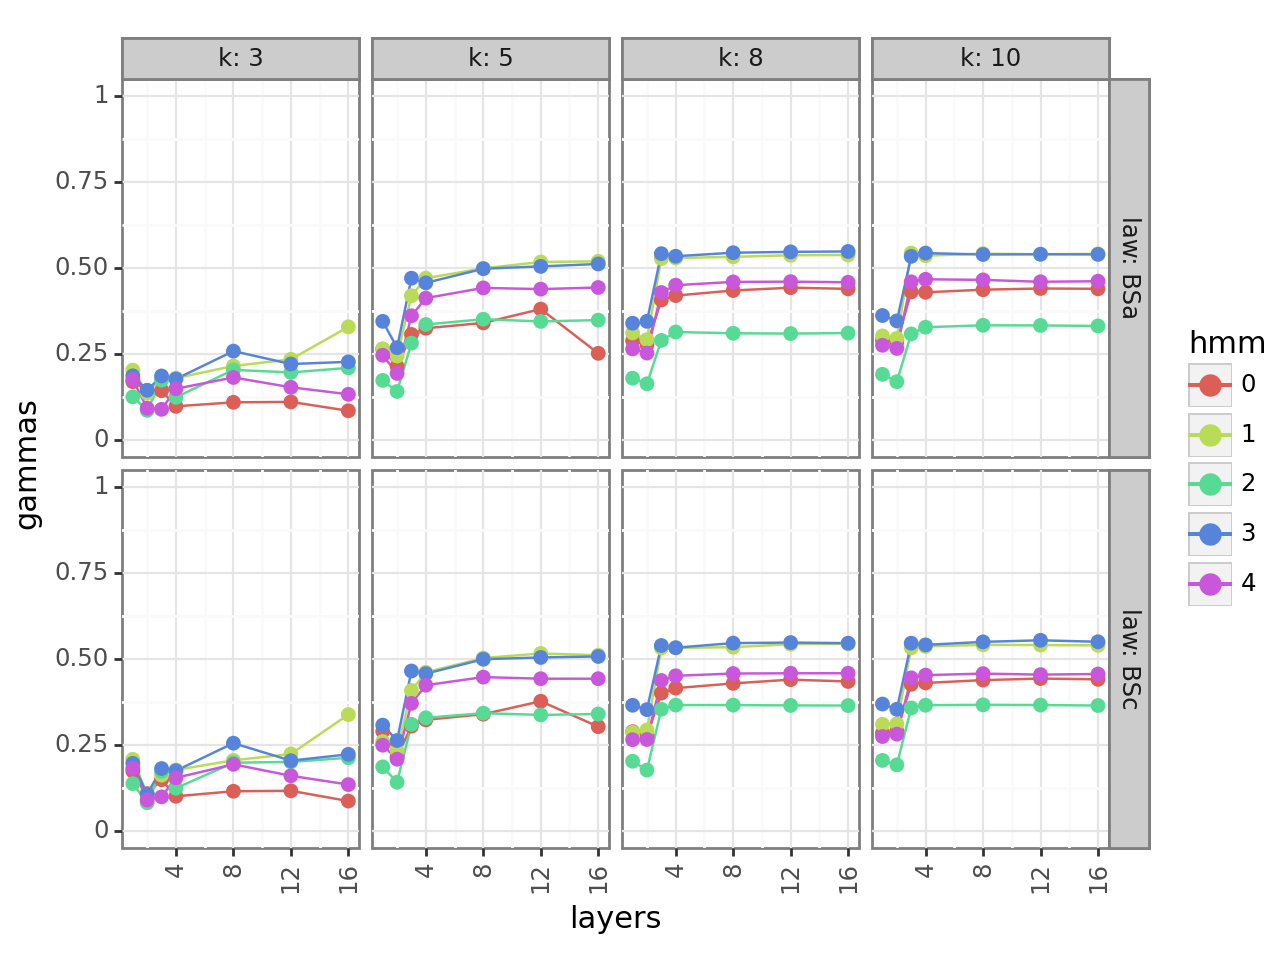

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 2.5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/gammas.pdf


In [65]:
plot = (
    ggplot(params_df[params_df["law"].str.startswith("BS")], aes(x="layers", y="gammas", group="hmm", color="hmm", fill="hmm")) +
    stat_summary(geom="line") + stat_summary() + facet_grid("law~k", labeller="label_both")
    + ylim(0, 1) + theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/gammas.pdf', width=5, height=2.5)

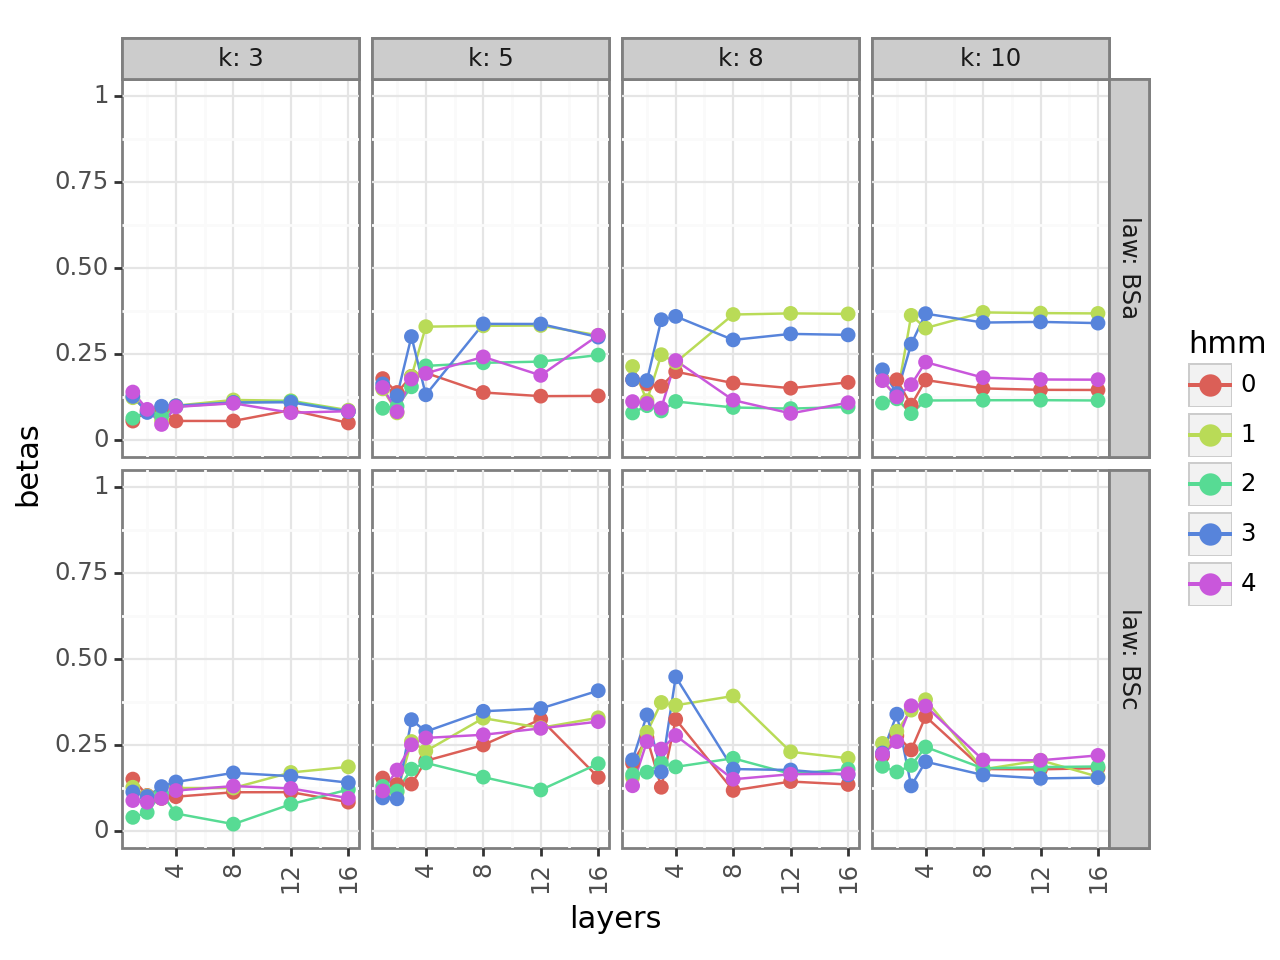

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 2.5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/betas.pdf


In [66]:
plot = (
    ggplot(params_df[params_df["law"].str.startswith("BS")], aes(x="layers", y="betas", group="hmm", color="hmm", fill="hmm")) +
    stat_summary(geom="line") + stat_summary() + facet_grid("law~k", labeller="label_both") + theme(axis_text_x=element_text(rotation=90))
    + ylim(0, 1) + theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/betas.pdf', width=5, height=2.5)

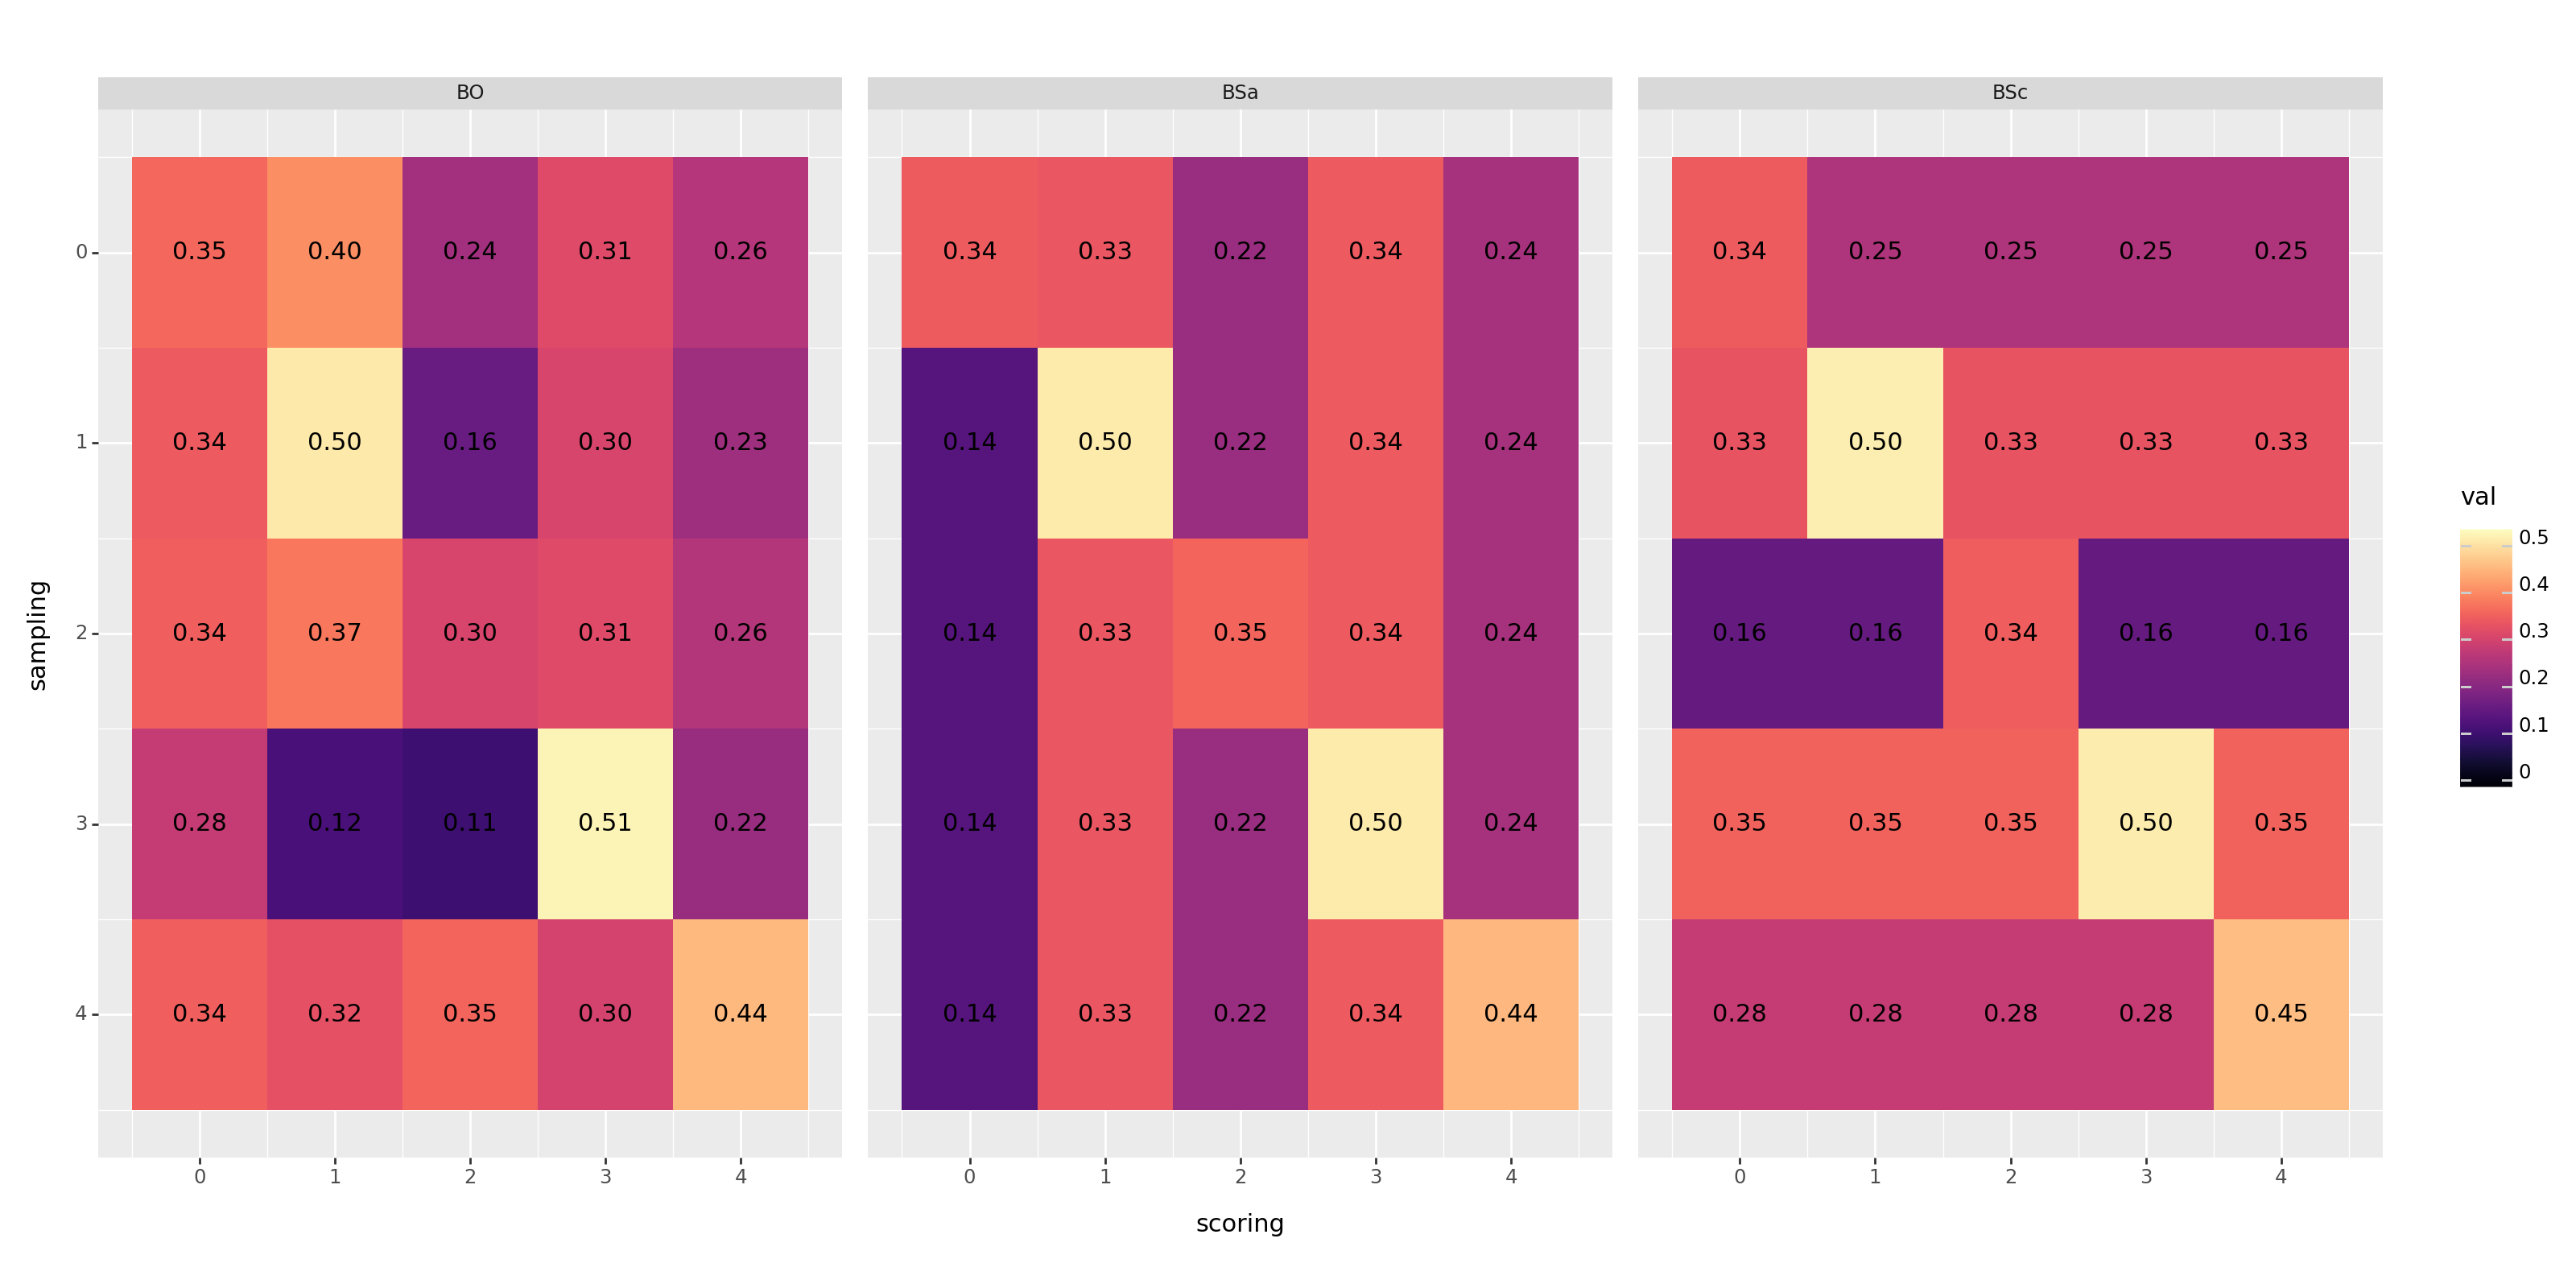

In [98]:
layers = 8
k = 5
subset = params_df[(params_df["layers"] == layers) & (params_df["k"] == k)]

entries = []
for sampling_hmm in range(5):
    for scoring_hmm in range(5):
        # BO
        val = subset[(subset["law"] == "BO") & (subset["hmm"] == sampling_hmm)][f"P_{scoring_hmm}"].mean()
        entries.append({"law": "BO", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})

        if sampling_hmm == scoring_hmm:
            val = subset[(subset["law"] == "BSc") & (subset["hmm"] == sampling_hmm)][f"gammas"].mean()
            entries.append({"law": "BSc", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})
            val = subset[(subset["law"] == "BSa") & (subset["hmm"] == sampling_hmm)][f"gammas"].mean()
            entries.append({"law": "BSa", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})
        else:
            val = subset[(subset["law"] == "BSc") & (subset["hmm"] == sampling_hmm)][f"betas"].mean()
            entries.append({"law": "BSc", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})
            val = subset[(subset["law"] == "BSa") & (subset["hmm"] == scoring_hmm)][f"betas"].mean()
            entries.append({"law": "BSa", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})

entries_df = pd.DataFrame(entries)
plot = (
    ggplot(entries_df, aes(x="scoring", y="sampling", fill="val", label="val")) + geom_tile() +
    scale_y_reverse() + facet_grid("~law") + geom_text(format_string="{:.2f}") +
    theme(figure_size=(16, 8)) + scale_fill_cmap(cmap_name="magma", limits=(0, 0.52))
)
print(plot)

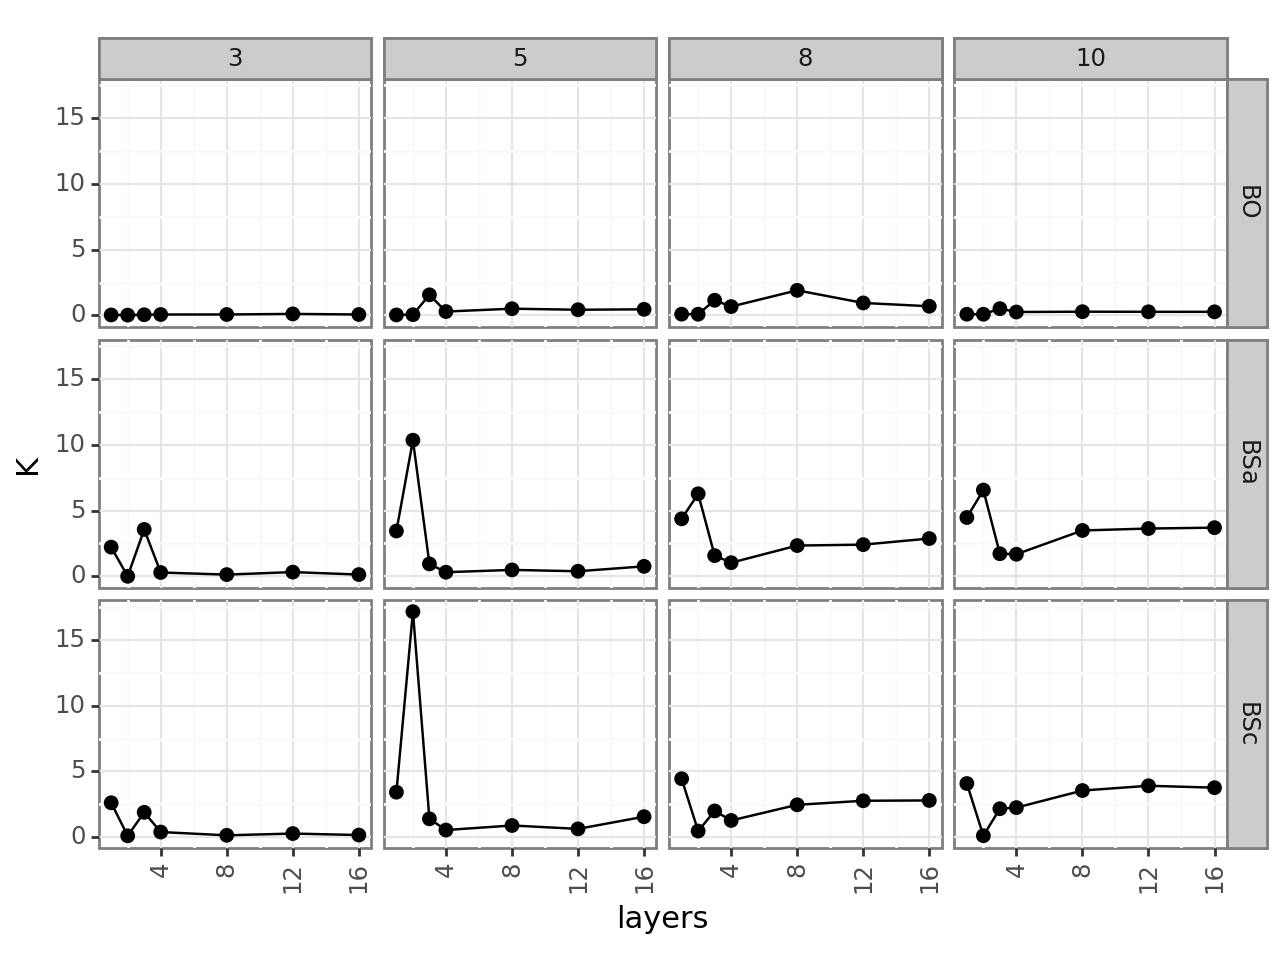

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 2.5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/K.pdf


In [100]:
plot = (
    ggplot(params_df[params_df["law"].str.startswith("B")], aes(x="layers", y="K", group="law")) +
    stat_summary(geom="line") + stat_summary() + facet_grid("law~k") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/K.pdf', width=5, height=2.5)

## SFT

In [50]:
sft_data = data
sft_data["tokens"] = sft_data["shots"] * (sft_data["k"] + 1)
sft_data['k'] = sft_data['k'].astype(str)

/tmp/aryaman/ipykernel_1529162/2836062003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/aryaman/ipykernel_1529162/2836062003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [122]:
sft_df = pd.DataFrame(sft_data)
sft_df[(sft_df["hmm"] == 0) & (sft_df["k"] == '10')]

Unnamed: 0  shots   k  hmm   sft  sft_amount      prob       acc  \
645           645      1  10    0     0           0  0.326885  0.572864   
658           658      1  10    0    60          50  0.452752  0.693467   
666           666      1  10    0   300         250  0.461383  0.763819   
672           672      1  10    0   600         500  0.463810  0.814070   
678           678      1  10    0  1200        1000  0.467097  0.844221   
...           ...    ...  ..  ...   ...         ...       ...       ...   
79786       79786     93  10    0   300         250  0.475041  0.984925   
79792       79792     93  10    0   600         500  0.478354  0.989950   
79798       79798     93  10    0  1200        1000  0.476821  0.989950   
79803       79803     93  10    0  3000        2500  0.477944  0.974874   
79807       79807     93  10    0  6000        5000  0.477809  0.989950   

            nll  layers  tokens  
645    1.290485       1      11  
658    0.912928       1      11  
666    0.856977       1      11  
672    0.839413       1      11  
678    0.823234       1      11  
...         ...     ...     ...  
79786  0.789635      16    1023  
79792  0.783069      16    1023  
79798  0.782884      16    1023  
79803  0.782773      16    1023  
79807  0.782119      16    1023  

[4557 rows x 11 columns]

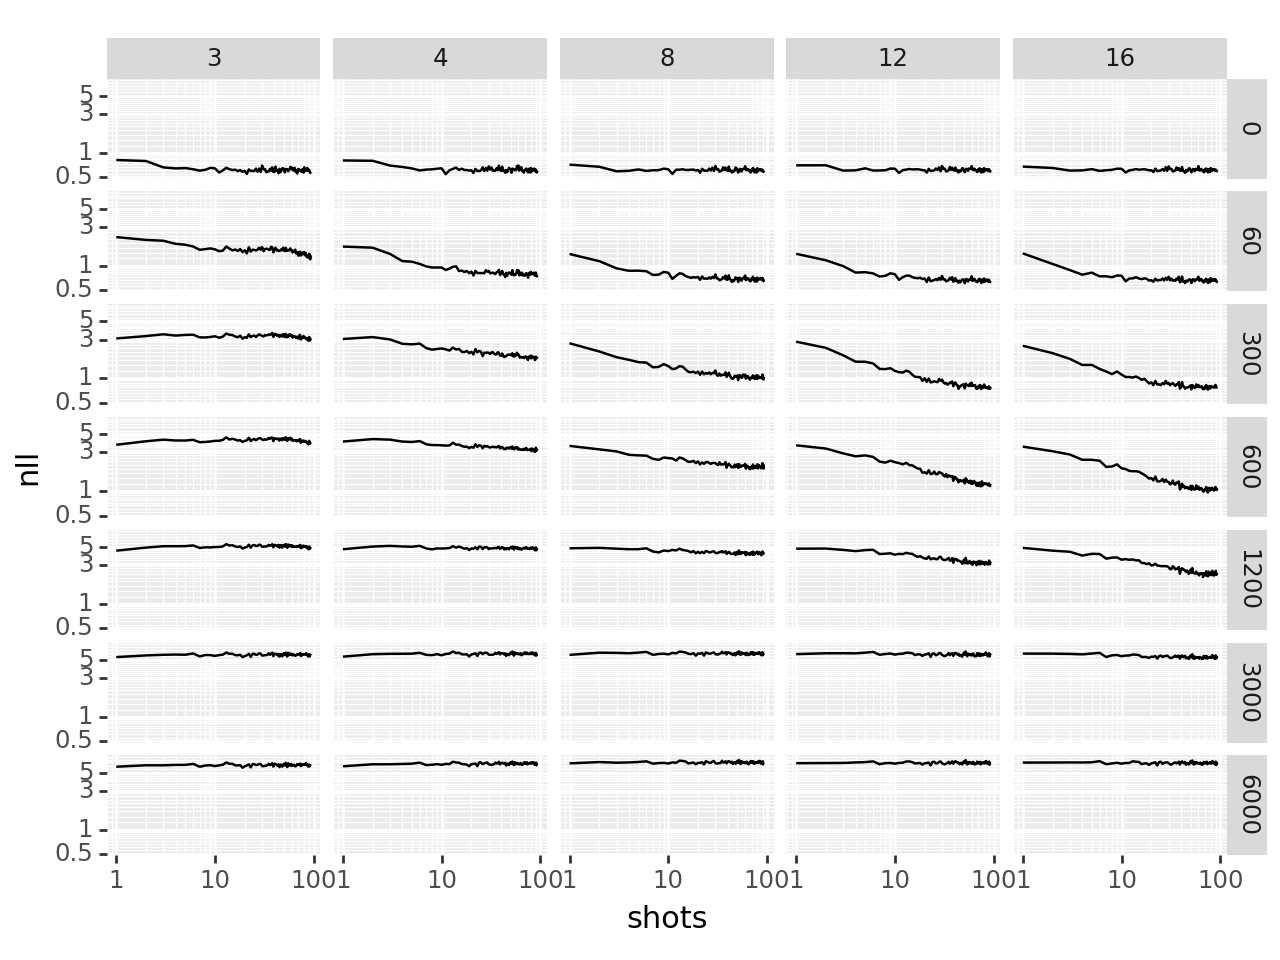

In [128]:
plot = (
    ggplot(sft_df[(sft_df["hmm"] == 1) & (sft_df["k"] == '10') & (sft_df["layers"] > 2)], aes(x="shots", y="nll")) +
    stat_summary(geom="line") + facet_grid("sft~layers") + scale_x_log10() + scale_y_log10()
)
print(plot)

In [51]:
from collections import defaultdict

all_params_sft = []
models_sft = {}
for i in range(1):
    for sft_amount in sft_data["sft_amount"].unique():
        for k in sft_data["k"].unique():
            for layers in sft_data["layers"].unique():
                print(f"sft: {sft_amount}, k: {k}, layers: {layers}")
                subset = sft_data[(sft_data["sft_amount"] == sft_amount) & (sft_data["k"] == k) & (sft_data["layers"] == layers)]
    
                # bayesian law
                torch.manual_seed(42 + i)
                np.random.seed(42 + i)
                for law in bayesian_law_mapping.keys():
                    bayesian_model = fit_bayesian_law(subset, True, law)
                    models[(law, k, layers)] = bayesian_model
                
                for hmm in range(5):
                    # bayesian
                    subset_hmm = subset[subset['hmm'] == hmm]
                    # get mse
                    for law in bayesian_law_mapping.keys():
                        bayesian_model = models[(law, k, layers)]
                        more = bayesian_model.get_params()
                        def estimate_nll(row):
                            return bayesian_model(row['shots'], torch.tensor([int(row['hmm'])], dtype=torch.int32), torch.tensor(sft_amount)).item()
                        est_nll = subset_hmm.apply(estimate_nll, axis=1)
                        bayesian_se = (subset_hmm["nll"] - est_nll)**2
                        bayesian_rmse = bayesian_se.mean()**0.5
                        bayesian_nrmse = bayesian_rmse / (subset_hmm["nll"].mean())
                        print(hmm, bayesian_rmse, bayesian_nrmse)
                        params = {
                            "sft": sft_amount,
                            "k": k,
                            "hmm": hmm,
                            "layers": layers,
                            "law": "bayesian_" + law,
                            "rmse": bayesian_rmse,
                            "nrmse": bayesian_nrmse,
                        }
                        for key in more:
                            if key == "priors": params[key] = more[key][0][0][hmm]
                            elif key == "K": params[key] = more[key][0][0]
                            else: params[key] = more[key][hmm]
                        all_params_sft.append(params)
    
                    # others
                    continue
                    for law in power_law_mapping.keys():
                        torch.manual_seed(42 + i)
                        np.random.seed(42 + i)
                        model = fit_power_law(subset_hmm, type=law)
                        models_sft[(law, sft_amount, k, layers, hmm)] = model
                        # get mse
                        def estimate_nll(row):
                            return model(row['shots']).item()
                        est_nll = subset_hmm.apply(estimate_nll, axis=1)
                        power_se = (subset_hmm["nll"] - est_nll)**2
                        power_rmse = power_se.mean()**0.5
                        power_nrmse = power_rmse / (subset_hmm["nll"].mean())
                        params = {
                            "sft": sft_amount,
                            "k": k,
                            "hmm": hmm,
                            "layers": layers,
                            "law": law,
                            "rmse": power_rmse,
                            "nrmse": power_nrmse,
                        }
                        params.update(model.get_params())
                        all_params_sft.append(params)

sft: 0, k: 3, layers: 1


  7%|████▉                                                                  | 7/100 [00:00<00:06, 14.48it/s, loss=0.115]


0 0.31267403560234786 0.17161843446797356
0 0.29783533684252295 0.16347386868784042
0 0.30235042892569614 0.16595208224753105
1 0.36655626293452453 0.22618081112424046
1 0.3617389216797132 0.22320830659314173
1 0.36982455535932374 0.2281974866155124
2 0.3223581973513221 0.1604719605185217
2 0.33639893159947404 0.16746152731233555
2 0.3152034283231255 0.15691027099908128
3 0.33587641249663014 0.199654010025765
3 0.3371434528871286 0.20040717305066233
3 0.334087240310892 0.19859047776146
4 0.37120523774598113 0.21128325539248793
4 0.3756462474236888 0.21381099715505894
4 0.3622056659360668 0.20616086315286564
sft: 0, k: 3, layers: 2


 13%|████████▉                                                            | 13/100 [00:00<00:05, 15.06it/s, loss=0.0164]


0 0.11755953803049732 0.05173107795504886
0 0.11813701234359276 0.05198519063027925
0 0.11815999029195348 0.05199530188163163
1 0.1360727878256257 0.05998026156025326
1 0.1384561169766997 0.06103082213264916
1 0.13391800261956494 0.059030442111920114
2 0.1362974053944687 0.05436897491108123
2 0.13544387678469663 0.0540285027250093
2 0.12936617152314686 0.05160410877616047
3 0.12337220762532732 0.05370302465862234
3 0.12338463663949467 0.05370843491808968
3 0.1226222848645064 0.05337658873523565
4 0.13112323170852358 0.05284624539380342
4 0.13127926738480392 0.052909132035106075
4 0.1304414224891261 0.05257145764756993
sft: 0, k: 3, layers: 3


 10%|██████▉                                                              | 10/100 [00:00<00:05, 15.02it/s, loss=0.0127]


0 0.10989332400751316 0.05728844976348433
0 0.10611139316216046 0.05531689273579676
0 0.10507354638437397 0.05477585320015262
1 0.11273141678928585 0.06212806917368915
1 0.11264673008966376 0.06208139699230384
1 0.11344560590613886 0.06252167010693988
2 0.10329610691472443 0.058960171385862965
2 0.10137130110495626 0.05786151545566296
2 0.09910370119758784 0.056567196790939384
3 0.10442345031004584 0.06201083842329705
3 0.10208785036528546 0.060623865378775225
3 0.10091359142689643 0.059926543263107215
4 0.13722210229245732 0.059120735850103225
4 0.13203151003330718 0.05688442239380025
4 0.13269855231208344 0.05717181072050241
sft: 0, k: 3, layers: 4


 11%|███████▌                                                             | 11/100 [00:00<00:05, 15.44it/s, loss=0.0194]


0 0.171081656504504 0.07357645599959288
0 0.17261121331045953 0.07423426684461064
0 0.17433478912452854 0.07497551872769882
1 0.11853234536477768 0.06783847790852465
1 0.12299112168672009 0.07039032650381133
1 0.1200133701996909 0.06868609861691478
2 0.12649846360657763 0.06113507417574241
2 0.13426669156218177 0.06488935844718585
2 0.13132021676059444 0.0634653652189975
3 0.11562243631535433 0.06562199735025821
3 0.1184537819977364 0.06722893943509878
3 0.11031930203874674 0.0626121813098969
4 0.12981940148278134 0.06697252844162412
4 0.13237770339851668 0.0682923307659059
4 0.14035818545707418 0.0724093814959195
sft: 0, k: 3, layers: 8


 12%|████████▎                                                            | 12/100 [00:00<00:05, 15.28it/s, loss=0.0133]


0 0.11601930011151057 0.05264068039787536
0 0.11619206119265117 0.05271906615652735
0 0.12113579664497517 0.05496215500180831
1 0.10485658856496653 0.06663950361887454
1 0.10642027625260403 0.06763327399368076
1 0.10504560672291498 0.0667596303213834
2 0.10782937124374586 0.06730136576059596
2 0.10767394234230666 0.0672043552965186
2 0.10368379263029333 0.06471391579835337
3 0.09923572903349993 0.069984998363874
3 0.11611121915892483 0.08188626779898583
3 0.10304730523170508 0.0726730740861284
4 0.1354316396452739 0.07706088054745615
4 0.13375503714372558 0.0761068902876041
4 0.13501206980253738 0.07682214444696205
sft: 0, k: 3, layers: 12


  9%|██████▎                                                               | 9/100 [00:00<00:06, 15.12it/s, loss=0.0136]


0 0.12496100703065066 0.05675314500033772
0 0.12933703687077297 0.058740592620548954
0 0.12588913693649953 0.0571746708216915
1 0.1098222103066709 0.07195685834562297
1 0.1144294234434658 0.07497556086605754
1 0.10662582100784183 0.06986254489708607
2 0.10594534594183938 0.06509798670377072
2 0.10076005985458028 0.06191189408438426
2 0.10601802685279241 0.06514264539956124
3 0.10045294097976046 0.06362423397292961
3 0.1043167411087294 0.0660714627054332
3 0.09986383312010988 0.06325110864745753
4 0.13273475043028313 0.0703129330849332
4 0.13170152323265824 0.06976560667212399
4 0.13274239706713345 0.07031698370064189
sft: 0, k: 3, layers: 16


  9%|██████▎                                                               | 9/100 [00:00<00:06, 15.14it/s, loss=0.0137]


0 0.13493250027708606 0.05437328314624704
0 0.13598953810794795 0.054799234026544394
0 0.13820764960004406 0.05569305874603021
1 0.10034056811195459 0.08925795719455175
1 0.10486940469233595 0.09328658399265576
1 0.09985509204929974 0.0888261019396455
2 0.10736640931828412 0.06810635213698417
2 0.10367339618620983 0.06576374186980143
2 0.10501489018659071 0.06661469947711737
3 0.0945431318924902 0.062332895181440924
3 0.10108345481198344 0.06664497216506718
3 0.09529813055449657 0.06283067065723633
4 0.1406731972090313 0.06811186059608211
4 0.13164822104650442 0.06374210196074251
4 0.1296919753709103 0.0627949170286352
sft: 0, k: 5, layers: 1


  6%|████▏                                                                 | 6/100 [00:00<00:04, 20.81it/s, loss=0.0806]


0 0.2901741715151983 0.22030140955053965
0 0.2828306305753562 0.2147261634433768
0 0.28724729956009715 0.21807931647479892
1 0.2954968817286153 0.2370546579202635
1 0.29316025208339996 0.2351801577969709
1 0.2933683737969447 0.23534711800758806
2 0.2574746749991747 0.15165267839584698
2 0.2505034547994115 0.14754662713086447
2 0.2535186915293897 0.14932260267525616
3 0.2729081337935194 0.24251796092905575
3 0.27096801227491046 0.24079388510871536
3 0.2842768148200511 0.252620662166584
4 0.2970158202766206 0.2167139771593962
4 0.29613346081635694 0.21607017432175654
4 0.29581903287836536 0.2158407558048953
sft: 0, k: 5, layers: 2


 13%|████████▊                                                           | 13/100 [00:00<00:03, 22.73it/s, loss=0.00969]


0 0.10191738109353445 0.06598116194357513
0 0.10302674569914935 0.06669936295023533
0 0.10366984153858567 0.06711570224655364
1 0.09921604728658884 0.06911904991864094
1 0.10299249161200842 0.07174991711182459
1 0.10020847759322389 0.06981042839804094
2 0.1068691929352091 0.05455830261733554
2 0.10868428402127432 0.05548493344546963
2 0.10622315433562327 0.05422849036320864
3 0.0927832196207652 0.0718003202634684
3 0.09181357996657684 0.0710499643478681
3 0.09280044488732021 0.07181365004077435
4 0.08738181060700953 0.05475757092234985
4 0.08752237815411794 0.054845657188549876
4 0.08945378511063944 0.056055968037764095
sft: 0, k: 5, layers: 3


 11%|███████▋                                                              | 11/100 [00:00<00:03, 22.47it/s, loss=0.003]


0 0.06413930788545001 0.05360931557830672
0 0.06907894163319485 0.057737991006127774
0 0.06390810281834536 0.053416068319888314
1 0.056639045246784446 0.06390570594658455
1 0.06244674417790379 0.07045851944302103
1 0.05870502248993328 0.06623674337169899
2 0.0676700690989372 0.05685386754815157
2 0.05880247786931137 0.04940364821258101
2 0.05496295902499191 0.04617782771719454
3 0.04661426727766918 0.06185741435268525
3 0.05145768861763249 0.06828466373807404
3 0.045689949935111995 0.06063083965375561
4 0.04403734399977039 0.043625491529156825
4 0.04583618720752563 0.04540751133313539
4 0.044198945175479586 0.043785581354783915
sft: 0, k: 5, layers: 4


  9%|██████▏                                                              | 9/100 [00:00<00:04, 21.30it/s, loss=0.00267]


0 0.05610553012615083 0.049539099909371616
0 0.055288859362978365 0.04881800994838386
0 0.054343601476497236 0.047983382331939974
1 0.04263900811424589 0.05521427619440502
1 0.047000094529821186 0.060861551787966296
1 0.04222285529097538 0.05467538990367392
2 0.053123113029721704 0.04723166469186099
2 0.05347266425749924 0.047542450062699096
2 0.05299195705817142 0.04711505415235566
3 0.05211632410889907 0.06542095351007968
3 0.05501751900053395 0.06906278626353202
3 0.05295328245855447 0.06647157659639458
4 0.04724942071547014 0.05292022791174828
4 0.04458706292048274 0.04993833778145886
4 0.04939277485307539 0.05532082431568516
sft: 0, k: 5, layers: 8


 15%|██████████▎                                                          | 15/100 [00:00<00:03, 22.93it/s, loss=0.0019]


0 0.05331369422694946 0.04958867355709542
0 0.050157107421336826 0.046652637048504815
0 0.05044940025460501 0.046924507420689376
1 0.03792918029095442 0.05390694142280642
1 0.040361916094583256 0.05736447320855553
1 0.04025621894294989 0.05721425087003017
2 0.05130774682021571 0.04772563801308226
2 0.047438269582730126 0.04412631273802778
2 0.04616155934835761 0.042938737483422126
3 0.04735558012003476 0.06807950815405678
3 0.0432813225195304 0.062222258536753165
3 0.04105377556515903 0.05901988406136349
4 0.03707887498310889 0.04524921874320534
4 0.03461102646381647 0.04223757889368379
4 0.03445761887852459 0.04205036789046696
sft: 0, k: 5, layers: 12


 15%|██████████▏                                                         | 15/100 [00:00<00:03, 22.82it/s, loss=0.00177]


0 0.047714495329415484 0.048091951375535666
0 0.06799909446081398 0.06853701630527093
0 0.04673308914117094 0.04710278155703798
1 0.033727466498336606 0.049915064664487495
1 0.03454776388648488 0.05112906623129806
1 0.035195607568101264 0.05208784442063986
2 0.049720410293640764 0.0457848008717262
2 0.06911473774341811 0.06364397409827297
2 0.04545834607311849 0.04186009951695722
3 0.04039241460217372 0.05893865919389548
3 0.04209039454333038 0.06141626945947532
3 0.040650680725942044 0.05931550863951615
4 0.035645987773479326 0.042612974381712646
4 0.03487044613650935 0.041685853603964394
4 0.03639577911454044 0.04350931198389403
sft: 0, k: 5, layers: 16


 14%|█████████▌                                                          | 14/100 [00:00<00:03, 22.83it/s, loss=0.00193]


0 0.06514411096123722 0.05463589046120452
0 0.060198441880273415 0.05048799389499475
0 0.058829007221860984 0.04933945904070348
1 0.032497384107086746 0.04891967782411349
1 0.061429716239059864 0.09247273310796084
1 0.033758042693413426 0.05081740016650519
2 0.045421158684413696 0.04187450309398323
2 0.058486433076605455 0.053919591524263906
2 0.045207779065486633 0.04167778496147068
3 0.03767597810733117 0.055644105993864955
3 0.04050552630914694 0.05982309982404636
3 0.03597018556713926 0.053124800439551735
4 0.03657440666552484 0.04432260528404304
4 0.038006339060512616 0.04605788905547608
4 0.03796684319065515 0.046010026082166595
sft: 0, k: 8, layers: 1


 12%|████████▎                                                            | 12/100 [00:00<00:02, 32.87it/s, loss=0.0577]


0 0.25431666357862637 0.2026791239443222
0 0.25787949880796274 0.2055185459187954
0 0.25395495316760075 0.20239085675727825
1 0.24622433749731656 0.20327532885101673
1 0.24562178386310135 0.20277787888571097
1 0.24553417690952056 0.2027055532477185
2 0.20305538449589144 0.12545503910341002
2 0.20350891306399727 0.1257352456312373
2 0.2033129784611127 0.12561419007130908
3 0.2428326342565631 0.23043239827274012
3 0.24068129064456656 0.2283909129116855
3 0.2397054439535215 0.22746489778174853
4 0.25145821145020436 0.19226475506618504
4 0.24440376346142567 0.18687092955988113
4 0.244545395574936 0.18697922136493503
sft: 0, k: 8, layers: 2


 13%|████████▊                                                           | 13/100 [00:00<00:02, 33.63it/s, loss=0.00542]


0 0.08214717983687318 0.06426623284015694
0 0.08858637685594051 0.06930381216732055
0 0.08219163932760512 0.06430101484958206
1 0.06904461055965665 0.05549402286738155
1 0.06883565328649983 0.05532607522308496
1 0.06983058941485124 0.056125746737063754
2 0.08522529979511312 0.048244019875517026
2 0.08243027347356803 0.04666182179896715
2 0.08228318290382113 0.04657855731779277
3 0.05880610847363932 0.05476688039038567
3 0.058718626092025245 0.05468540693032375
3 0.06311900854966584 0.05878353935201908
4 0.06316820450130872 0.04686591817301649
4 0.06301689501041888 0.04675365824296422
4 0.06332676431920677 0.04698355728449359
sft: 0, k: 8, layers: 3


 38%|█████████████████████████▊                                          | 38/100 [00:01<00:01, 35.41it/s, loss=0.00145]


0 0.041686719946530074 0.04617698741806916
0 0.043055851940365826 0.04769359488764514
0 0.040124506699074934 0.04444650102900795
1 0.034640323236705045 0.0534420685166028
1 0.04038646822302855 0.06230705144320681
1 0.03339652859364497 0.05152317884340924
2 0.044705553534850936 0.04228348574072217
2 0.042310244589742724 0.040017950396301225
2 0.04614141916906359 0.04364155871531343
3 0.030519640319084464 0.0496941269232075
3 0.03125989830122553 0.05089946465772308
3 0.033200792310246446 0.054059758560940085
4 0.0367825659058657 0.044495082073636574
4 0.03693039281856117 0.04467390512339092
4 0.03654046314397715 0.044202215548553636
sft: 0, k: 8, layers: 4


 33%|██████████████████████▍                                             | 33/100 [00:00<00:01, 34.81it/s, loss=0.00114]


0 0.04671831070346221 0.053184752758617275
0 0.03974392893649651 0.045245022825428784
0 0.03359674601117921 0.03824698717041171
1 0.03141350742121603 0.04887604343211102
1 0.03697910904137805 0.05753552175350173
1 0.029270051909036893 0.04554105688306652
2 0.0368115688889686 0.035709415514998254
2 0.04159924145180757 0.04035374321023557
2 0.0408335380314015 0.03961096526227559
3 0.036079306799128553 0.05701260816562971
3 0.04214989808289789 0.06660537124509075
3 0.033367901612759134 0.05272803910976111
4 0.031346545496649066 0.0395086822300043
4 0.0325827692616838 0.04106679879832465
4 0.031878770238668946 0.04017948974241925
sft: 0, k: 8, layers: 8


 37%|████████████████████████▊                                          | 37/100 [00:01<00:01, 34.68it/s, loss=0.000949]


0 0.02941646624661973 0.03494413795751138
0 0.03491012786991826 0.041470117932366095
0 0.032537424694156776 0.03865155820425591
1 0.0267105016512559 0.04236418177023919
1 0.029678298575026622 0.04707125503967245
1 0.02687742234019255 0.04262892627034832
2 0.04031430160944466 0.03968553140770669
2 0.035835787304424896 0.03527686716161475
2 0.03844832997994499 0.037848662784115056
3 0.028896962038072398 0.047297830892434126
3 0.04509962616814083 0.0738179497554897
3 0.03355990191403563 0.054930015252309776
4 0.031000357185176297 0.03993137341447808
4 0.03730949379841157 0.048058134294076016
4 0.029312183445079645 0.03775684698558423
sft: 0, k: 8, layers: 12


 45%|██████████████████████████████▏                                    | 45/100 [00:01<00:01, 35.25it/s, loss=0.000901]


0 0.03146732630929981 0.03815931595871206
0 0.030484002500478936 0.03696687388270923
0 0.033320722739902095 0.04040686439345785
1 0.024581201125923678 0.03915360714865287
1 0.0285972499311753 0.04555047914872809
1 0.025180077167910726 0.040107513231540416
2 0.03477271005567307 0.034217506026544546
2 0.03390135361983972 0.03336006224242018
2 0.03610606549873582 0.03552957223695723
3 0.028395739491441235 0.04676621814422183
3 0.030690486897175174 0.05054554066529182
3 0.03098850160400529 0.051036354464805804
4 0.028149783392844796 0.0360271920873125
4 0.028453579506445503 0.03641600221729927
4 0.028104100699034858 0.03596872559178078
sft: 0, k: 8, layers: 16


  9%|██████▏                                                              | 9/100 [00:00<00:02, 32.77it/s, loss=0.00103]


0 0.030383824653304095 0.036488237077152215
0 0.030148086783827837 0.03620513712618613
0 0.028627902436934905 0.034379532631579716
1 0.025947087567913443 0.04146381946944969
1 0.025863811917924737 0.04133074378192619
1 0.026622279775118097 0.04254278633667272
2 0.034626836233769415 0.03395446470332601
2 0.033687510592560574 0.03303337855170555
2 0.03477117659741444 0.03409600231737666
3 0.02864517418295672 0.04723936855457555
3 0.028026084695720526 0.04621841485853504
3 0.031981103752160865 0.05274072125661295
4 0.028428472989356152 0.0365596756161304
4 0.02807201452643775 0.03610126176534775
4 0.027961629616086853 0.0359593042104395
sft: 0, k: 10, layers: 1


 16%|███████████▏                                                          | 16/100 [00:00<00:02, 39.30it/s, loss=0.025]


0 0.1805017413146168 0.14482593855434056
0 0.18067851874554677 0.1449677762848976
0 0.18058068133754715 0.14488927624198347
1 0.15749333589503361 0.13395807323334508
1 0.1578745400419546 0.13428231154311157
1 0.15912979035909602 0.13534998156834924
2 0.12995398265723976 0.08194432504567387
2 0.12957586161946213 0.08170589546781336
2 0.1315932034683966 0.08297795895380392
3 0.15415310416566172 0.1522723144455658
3 0.15658346806479267 0.1546730259840627
3 0.1552207667663195 0.1533269507185689
4 0.14589473280478313 0.11444909017584197
4 0.14586252139835795 0.11442382150378114
4 0.1469694281146548 0.11529214940126059
sft: 0, k: 10, layers: 2


 15%|██████████▏                                                         | 15/100 [00:00<00:02, 41.04it/s, loss=0.00483]


0 0.06926510852965048 0.05478688667388235
0 0.06518446231713826 0.051559202398971965
0 0.06547982354733385 0.05179282539603487
1 0.0720167079910252 0.05893455600828105
1 0.06632266308985359 0.054274859425321634
1 0.0674038119897234 0.05515961286893376
2 0.07942770267201216 0.0453607814794096
2 0.08218238706007708 0.046933968571169514
2 0.07900011497411909 0.04511658818821618
3 0.06075716502820948 0.05716241372597563
3 0.06062311526356372 0.05703629513398746
3 0.06254799029092258 0.05884728323117071
4 0.0640880427780632 0.048429037748579436
4 0.06586715164183396 0.04977344657411902
4 0.0651918345226186 0.0492631336227312
sft: 0, k: 10, layers: 3


 13%|████████▊                                                           | 13/100 [00:00<00:02, 40.76it/s, loss=0.00131]


0 0.03093321685336978 0.03616695502502622
0 0.030736080078941047 0.035936463741551246
0 0.03178086045529732 0.037158015481928715
1 0.02848879479596521 0.04602501425287913
1 0.031474781437376434 0.050849018873436895
1 0.03082965641199657 0.049806788456157096
2 0.04668905086254969 0.045024325922198044
2 0.04614018701393124 0.04449503212953002
2 0.04304872557248169 0.04151379852241507
3 0.030385407459910106 0.05007374854661719
3 0.03129158890240826 0.051567093723874774
3 0.03243090957398035 0.05344464158620094
4 0.035316415246707034 0.044214727871468906
4 0.03534918499821885 0.044255754279030064
4 0.034472145505346385 0.04315773619766484
sft: 0, k: 10, layers: 4


 17%|███████████▌                                                        | 17/100 [00:00<00:02, 40.69it/s, loss=0.00134]


0 0.028435156778419103 0.03336204964680239
0 0.029450672960671703 0.034553521934205265
0 0.029348165982466284 0.034433253812503596
1 0.029315726561606296 0.04691213638319729
1 0.030881189829679107 0.04941725001837829
1 0.03195515520732555 0.05113585010700667
2 0.04336068564267836 0.042695118407503306
2 0.04211156017064594 0.041465166455780474
2 0.039884146221948816 0.0392719423203082
3 0.030382126642906775 0.049482413435985265
3 0.03286315980023649 0.05352319405290232
3 0.04179332829153074 0.06806747841235142
4 0.034073142362899995 0.043531160640410835
4 0.03403952908167126 0.0434882169890964
4 0.03476686001244204 0.044417440341874
sft: 0, k: 10, layers: 8


 43%|█████████████████████████████▏                                      | 43/100 [00:01<00:01, 42.80it/s, loss=0.00112]


0 0.022944657565148803 0.027641430382340827
0 0.02596533410393599 0.03128043959471975
0 0.023347516839133352 0.028126754974529922
1 0.027295576522094436 0.04419806162082754
1 0.025116597633578947 0.040669774057194866
1 0.025344543900135557 0.04103887353847351
2 0.04684991051354625 0.046646281400884004
2 0.03867551649289857 0.03850741668184502
2 0.042111858233362304 0.04192882265804059
3 0.03059488325256072 0.05099706762972615
3 0.025930038620693416 0.043221473416481665
3 0.04144453155977959 0.06908179911618066
4 0.033962235971965994 0.043936427977165425
4 0.035957122357225556 0.04651718214367359
4 0.04461305086794546 0.05771522516712657
sft: 0, k: 10, layers: 12


 43%|█████████████████████████████▏                                      | 43/100 [00:01<00:01, 42.22it/s, loss=0.00112]


0 0.023660517981610722 0.028784241075422413
0 0.028626692164683085 0.03482584823800417
0 0.02821247064134 0.0343219263798351
1 0.026122840548959306 0.04213554764913453
1 0.02463370837452324 0.03973361132164315
1 0.024994551878550594 0.040315643686359745
2 0.04345877199367773 0.04312719669815081
2 0.039498237208469573 0.03919687941407317
2 0.04182715078148178 0.04150802418758178
3 0.027500630730395548 0.04582691516870461
3 0.024839248362602966 0.04139200074088695
3 0.03992397679467222 0.06652911766654813
4 0.03420299496396388 0.043933273799402636
4 0.03765276220088117 0.048364452084327055
4 0.04288558516984251 0.05508594078674618
sft: 0, k: 10, layers: 16


 42%|████████████████████████████▌                                       | 42/100 [00:00<00:01, 42.64it/s, loss=0.00102]


0 0.023144434817186716 0.028065654289966727
0 0.027715710970377307 0.03360892450558441
0 0.024679309080087117 0.029926890080833466
1 0.023337995538148516 0.03780194259051237
1 0.026852607963423522 0.043494769847719376
1 0.022589118431979704 0.03658894169982027
2 0.04239827074282517 0.04196773446115078
2 0.038107151091238925 0.03772018929188765
2 0.04072416198065357 0.04031062555649591
3 0.0275935176540676 0.04593847832336826
3 0.024095689457387996 0.04011519378217655
3 0.039386915263671246 0.06557246436457084
4 0.03159250385434165 0.040717418488984115
4 0.03295736685685756 0.04247649710807035
4 0.04000609774405972 0.05156112448276944
sft: 50, k: 3, layers: 1


  6%|████▎                                                                  | 6/100 [00:00<00:06, 14.34it/s, loss=0.128]


0 0.2158941163773625 0.1999036396175672
0 0.2092933248508853 0.19379174424662907
0 0.21676071316187978 0.20070605079121442
1 0.4016049262530499 0.1293776627070426
1 0.40090564575970306 0.12915238838919513
1 0.4077224512201407 0.13134843305883726
2 0.36482887032092814 0.12676429106381443
2 0.3837457736921521 0.13333720247531114
2 0.3456183652840967 0.1200893641321009
3 0.357338548113612 0.10501287677452961
3 0.35077974203363643 0.10308540743683721
3 0.35189816226597864 0.10341408321688138
4 0.4278737142802964 0.14074103038665495
4 0.4222871716388234 0.13890344200153432
4 0.4220022943148674 0.13880973695079335
sft: 50, k: 3, layers: 2


  6%|████▎                                                                  | 6/100 [00:00<00:06, 14.33it/s, loss=0.032]


0 0.09997642833450171 0.06873095348726496
0 0.11470660024081887 0.07885752809108203
0 0.10044603184061356 0.06905379255316997
1 0.1945964610408692 0.04883340637803443
1 0.18759916514277764 0.0470774556669519
1 0.18965918330853812 0.047594411133133716
2 0.18329928124839204 0.05259586444356428
2 0.17738579206884894 0.05089904886874347
2 0.17158118754953722 0.049233476639725805
3 0.1791193864271377 0.0424833331097204
3 0.1814684544794112 0.0430404824085917
3 0.17842591289911378 0.042318855844129734
4 0.22176919090939567 0.053694104088310185
4 0.22390409322885896 0.054211000357307575
4 0.22124889437060632 0.05356813142097987
sft: 50, k: 3, layers: 3


 33%|██████████████████████▊                                              | 33/100 [00:02<00:04, 15.47it/s, loss=0.0223]


0 0.10132385707824307 0.06990103239085298
0 0.10999678275893587 0.07588428723735394
0 0.10201467363188432 0.07037761107315606
1 0.14324996000894302 0.041738994223377596
1 0.1629327047150729 0.04747399036256034
1 0.14842108483745003 0.04324571401116632
2 0.17643261234487534 0.06998666854093949
2 0.15057830306998224 0.059730872010307676
2 0.16446573127680295 0.06523968821996057
3 0.12903576923342444 0.04024324080130747
3 0.1566393136166846 0.048852141187491004
3 0.13363614399219645 0.041677990175789936
4 0.1789932766995635 0.04803987659492357
4 0.21856312863393546 0.05866000065129972
4 0.17692829106968486 0.04748565658924052
sft: 50, k: 3, layers: 4


  9%|██████▎                                                               | 9/100 [00:00<00:06, 14.91it/s, loss=0.0218]


0 0.12316754207194601 0.08070141652274808
0 0.1340163540732584 0.08780973809324337
0 0.12145531815014228 0.07957953900884121
1 0.15009471197978044 0.05450093389369543
1 0.15443828300482923 0.05607812921374539
1 0.14872251637957923 0.054002675555947593
2 0.14884739687538087 0.06256184765706702
2 0.14178249266818585 0.05959240734436638
2 0.13800007152955504 0.05800262304166871
3 0.13553226600739068 0.04867911468263444
3 0.12843956210429572 0.046131628708409665
3 0.12686184502327677 0.04556496017267158
4 0.19893692309365227 0.06982954007005962
4 0.18018366991166024 0.06324689556067709
4 0.17820102433415733 0.06255096025291228
sft: 50, k: 3, layers: 8


  9%|██████▎                                                               | 9/100 [00:00<00:06, 15.13it/s, loss=0.0158]


0 0.11143058409025036 0.07426101787050014
0 0.1296067866704747 0.08637423899060706
0 0.11385540136803124 0.07587699611083801
1 0.12957174248877915 0.053408575865558104
1 0.13638735716814948 0.05621792508539348
1 0.12964307245350395 0.053437977583550914
2 0.11533703504801542 0.06590579489342616
2 0.12617326660908196 0.0720978255311481
2 0.11980350188821362 0.06845801974770514
3 0.10376949060727104 0.04882355799099526
3 0.11791948771422193 0.055481133356169346
3 0.10655354054607245 0.05013345382686605
4 0.16703192844138073 0.06126956833731354
4 0.16212104094688148 0.05946818844696116
4 0.14678849684642317 0.05384400409302437
sft: 50, k: 3, layers: 12


 10%|██████▉                                                              | 10/100 [00:00<00:06, 15.00it/s, loss=0.0159]


0 0.10932391600064095 0.07677686270930698
0 0.12159197398508455 0.08539257131213383
0 0.11269786969971993 0.07914634954638869
1 0.12563498073612114 0.054028422822276774
1 0.1233093451872827 0.05302829992635281
1 0.124043136007232 0.05334386140812353
2 0.1116417866380411 0.06515197681497133
2 0.11742923755478327 0.06852942068522992
2 0.11360778298662806 0.06629929407295053
3 0.12078527084532018 0.04485516256655787
3 0.11274342258772534 0.041868718868534875
3 0.11135914245236914 0.041354648650581104
4 0.16392816591580833 0.06445697843611418
4 0.14767032399006394 0.05806435297989049
4 0.14864729003117505 0.05844849855178114
sft: 50, k: 3, layers: 16


 15%|██████████▎                                                          | 15/100 [00:00<00:05, 15.72it/s, loss=0.0172]


0 0.11306279768961623 0.07125023094480233
0 0.14412548926673077 0.09082540504152328
0 0.11241702164028715 0.07084327398288784
1 0.12109501162231011 0.07040538359760841
1 0.14076848202835668 0.0818436601382972
1 0.12921996973801456 0.0751292841545929
2 0.12009356979789745 0.0691320012704787
2 0.12177965882661845 0.07010260035477472
2 0.12240455794642456 0.07046232425020942
3 0.10436650387413483 0.051312558438098135
3 0.12033991967180942 0.059166005675946515
3 0.11934426265318174 0.058676483587382075
4 0.15805119049564395 0.05185880989457052
4 0.1606133189072977 0.052699480121784596
4 0.15506429567000382 0.050878767855961404
sft: 50, k: 5, layers: 1


  7%|████▉                                                                  | 7/100 [00:00<00:04, 21.90it/s, loss=0.104]


0 0.13725617700977447 0.15745250233228317
0 0.15549564175365094 0.1783757819084023
0 0.1479772771999816 0.1697511404663106
1 0.3903208976302849 0.13821753375212573
1 0.38726987529073553 0.13713712840935416
1 0.38669315989966985 0.13693290624365936
2 0.29822431875340155 0.1163157714530016
2 0.31865553618379194 0.12428451399912827
2 0.29551890015378224 0.11526058302023591
3 0.3395016752346064 0.11550537834433516
3 0.3487830968026565 0.11866310682697101
3 0.3481607032145171 0.11845135586336397
4 0.3687959644641833 0.13408847842766933
4 0.3757016996732969 0.13659929637536505
4 0.36414157772793676 0.13239621577944874
sft: 50, k: 5, layers: 2


  7%|█████                                                                   | 7/100 [00:00<00:04, 21.40it/s, loss=0.03]


0 0.0609380371214255 0.06159381825135506
0 0.0711687256390696 0.07193460372638376
0 0.061912913449295774 0.06257918565393059
1 0.19752929375730235 0.05835064061814886
1 0.1901420704104403 0.05616843661954416
1 0.19305715977564966 0.05702956120862973
2 0.17170818827644377 0.059129788856679966
2 0.17378245883445628 0.059844088980384284
2 0.17061523050203603 0.058753415644204214
3 0.18414207596480225 0.0542380692985346
3 0.18237991035179613 0.05371903278755277
3 0.20114168697931936 0.05924521432729897
4 0.20120303207547435 0.058848797068614976
4 0.20083200865813688 0.05874027841673697
4 0.2011122189110083 0.05882223561259867
sft: 50, k: 5, layers: 3


 15%|██████████▎                                                          | 15/100 [00:00<00:03, 22.75it/s, loss=0.0115]


0 0.05844601742457225 0.06016258929558498
0 0.08463475114355752 0.08712049165292049
0 0.05919675524268391 0.06093537644191202
1 0.12817842691542 0.05674603950931529
1 0.13768041108702841 0.0609526753855285
1 0.1320156132068957 0.0584448052855903
2 0.12798950781915083 0.07365271201663927
2 0.11361110164981046 0.06537852902388118
2 0.09769211617179681 0.05621780582877435
3 0.1113019340963581 0.05471172581141422
3 0.14360678948664365 0.0705915432183655
3 0.11230657120140375 0.055205566554411965
4 0.12297690404234461 0.05319644131842165
4 0.11137945223159681 0.048179701228093494
4 0.11476226296254811 0.04964301252171993
sft: 50, k: 5, layers: 4


 21%|██████████████▎                                                     | 21/100 [00:00<00:03, 23.78it/s, loss=0.00655]


0 0.0498538260220103 0.052919108890733875
0 0.06642591834376875 0.0705101430820765
0 0.04926537491767855 0.0522944766297464
1 0.07730700722437303 0.05786821423479065
1 0.07743849351436907 0.057966638388973014
1 0.08881354661609189 0.06648144233051125
2 0.08313543387778884 0.06141255898215603
2 0.07631460908239864 0.056373981741197336
2 0.07737402025148822 0.0571565740471894
3 0.07108463701791277 0.05564757744356458
3 0.07026830911959425 0.055008526984186484
3 0.08118626598022136 0.06355549121464522
4 0.06804088236746873 0.050611881519706095
4 0.07157297587489553 0.053239212205233456
4 0.08575697219796828 0.06378990932145034
sft: 50, k: 5, layers: 8


 22%|██████████████▉                                                     | 22/100 [00:00<00:03, 23.52it/s, loss=0.00427]


0 0.040046764712470366 0.04402206380915818
0 0.051631402338050365 0.0567566669767507
0 0.039277242537176064 0.043176153919892664
1 0.05935439621556482 0.055776149624405164
1 0.05978849972700744 0.0561840827169897
1 0.07502215777180554 0.07049936253801276
2 0.059909675289902126 0.051970527311038
2 0.05711134117892703 0.0495430245973928
2 0.06294040389346364 0.054599627917935906
3 0.045348383618725084 0.05114420806577259
3 0.04855440130071552 0.05475997608892567
3 0.06596345607239515 0.07439402362096527
4 0.05176129778381298 0.051148960686993726
4 0.05193125842096752 0.051316910686710945
4 0.06507240934423801 0.06430260155488723
sft: 50, k: 5, layers: 12


 26%|█████████████████▋                                                  | 26/100 [00:01<00:03, 22.98it/s, loss=0.00511]


0 0.04224227686169729 0.0477295676736739
0 0.05221406362834589 0.05899669403773032
0 0.04111102100060144 0.046451361166122376
1 0.05096432721824785 0.054730298465123915
1 0.05295801809585973 0.05687131165483251
1 0.08192308185117607 0.08797672736259053
2 0.06899287610767117 0.058883350750870964
2 0.055229400529736065 0.04713663709391576
2 0.05763257622360931 0.04918767548050901
3 0.06420362549452065 0.06354402621835079
3 0.06124987191283073 0.06062061817726641
3 0.09101803996599747 0.09008296141213769
4 0.05483723720626324 0.05016123460039178
4 0.04951379113461836 0.04529172182246113
4 0.06986979810674965 0.06391196042813008
sft: 50, k: 5, layers: 16


 26%|█████████████████▋                                                  | 26/100 [00:01<00:03, 23.23it/s, loss=0.00393]


0 0.040269912076781815 0.04480770886331829
0 0.060579409779906446 0.0674057731080755
0 0.03951287744011887 0.04396536812181468
1 0.04887976380238521 0.057927791110725574
1 0.05545256704424687 0.0657172717380416
1 0.07188521584402838 0.08519173259914763
2 0.07068177288118722 0.060759803936476856
2 0.0553402199996137 0.04757182481302732
2 0.057730643098243925 0.04962669175930698
3 0.05512636857740248 0.06497752505131797
3 0.055652883040969214 0.06559812836020912
3 0.06216557569662521 0.07327464798421157
4 0.06371985423594698 0.050388889053683876
4 0.0673055115815357 0.05322438345865176
4 0.07185956073254926 0.05682567037568915
sft: 50, k: 8, layers: 1


  7%|████▉                                                                  | 7/100 [00:00<00:04, 18.70it/s, loss=0.092]


0 0.10682680058185001 0.13007111902957427
0 0.1267153906873382 0.15428724416719156
0 0.10660737302097706 0.12980394648267385
1 0.35766283098930746 0.13085489669879377
1 0.36097177931654967 0.13206551198790628
1 0.3587897870886888 0.13126720603370767
2 0.26933559369581983 0.10869739857907625
2 0.27846041306178054 0.11237995725605553
2 0.2674765236879507 0.10794712242411704
3 0.3454145929917984 0.1250487292875369
3 0.35175973342147054 0.12734582895842522
3 0.3449531025060741 0.12488165817939909
4 0.35750219604786976 0.13329870802240085
4 0.3473159286742166 0.12950064385527366
4 0.3472727475958942 0.12948454330536088
sft: 50, k: 8, layers: 2


 23%|███████████████▊                                                     | 23/100 [00:00<00:02, 34.49it/s, loss=0.0321]


0 0.04625550709043279 0.05483027051645573
0 0.05926580304276277 0.07025239193371177
0 0.04530498703030504 0.05370354474245807
1 0.1874762566193915 0.05996787611754891
1 0.1874353235378095 0.0599547828863863
1 0.20569227293221024 0.06579461828373197
2 0.1765492888954956 0.06490919745151193
2 0.1799873195504873 0.06617320600133567
2 0.18126920806411684 0.06664449849513471
3 0.1810790483974401 0.05698213937895714
3 0.1801892664619585 0.05670214189325571
3 0.19883359636332648 0.06256915861589289
4 0.19911366580385134 0.06144486096724999
4 0.2097740426529974 0.06473456672757456
4 0.19856587650041807 0.0612758176348754
sft: 50, k: 8, layers: 3


 15%|██████████▏                                                         | 15/100 [00:00<00:02, 34.04it/s, loss=0.00968]


0 0.03835559340653065 0.045621640670497614
0 0.07842416509868454 0.09328076460959621
0 0.04296575733413008 0.05110514968332441
1 0.11222910103894705 0.06580601636123282
1 0.10954635574269646 0.06423297711184221
1 0.11292260730791985 0.06621265674648194
2 0.08887862879087194 0.06019358731112296
2 0.09707535326902784 0.06574486839245045
2 0.09970278576975172 0.0675243128977042
3 0.09537599481852797 0.0685619246452644
3 0.12046557019689834 0.08659780023163723
3 0.09389764294684172 0.06749919759514457
4 0.11033865638718034 0.0615471822893832
4 0.102266247716256 0.057044372265665146
4 0.10771378825887028 0.0600830241922264
sft: 50, k: 8, layers: 4


 11%|███████▍                                                            | 11/100 [00:00<00:02, 32.01it/s, loss=0.00341]


0 0.03421751273146053 0.04128247660907754
0 0.04888756355474613 0.058981484562085365
0 0.04139204637420522 0.04993835173396144
1 0.041595995049998585 0.04479060941133149
1 0.04355988456650937 0.04690532762291196
1 0.05432426944265208 0.05849642811133672
2 0.05321719192732011 0.04746306426255393
2 0.05178708045511582 0.04618758409816364
2 0.05824253681193583 0.05194504195738913
3 0.04128873857714183 0.04633888711587894
3 0.04624224641699145 0.05189827324702827
3 0.05360368450691176 0.06016011074593891
4 0.049923394882035704 0.0498657554321508
4 0.054593252316079054 0.05453022124540844
4 0.06662180394528103 0.06654488521531846
sft: 50, k: 8, layers: 8


 17%|███████████▉                                                          | 17/100 [00:00<00:02, 33.73it/s, loss=0.002]


0 0.03317072140141105 0.040404228013130254
0 0.03833210603172545 0.0466911507165303
0 0.03571394861472872 0.043502054285057934
1 0.030805836468732188 0.04001298864843807
1 0.03149712947712558 0.04091089315188063
1 0.05072375077709529 0.06588390697036133
2 0.03785303747741606 0.03631827598126879
2 0.03756266331432997 0.036039675116038825
2 0.04269850600145058 0.040967283692193705
3 0.028165237670388175 0.0414235035831416
3 0.03204356938822001 0.04712748839201556
3 0.03681302885230505 0.054142082890108155
4 0.03341621956157276 0.040534383005010215
4 0.036241149593258026 0.0439610661358083
4 0.0414473016594331 0.05027620784248236
sft: 50, k: 8, layers: 12


 53%|████████████████████████████████████                                | 53/100 [00:01<00:01, 35.78it/s, loss=0.00159]


0 0.03374916948723598 0.04148201892316866
0 0.03745281943452116 0.046034275453694
0 0.032512194737536915 0.03996161973248917
1 0.030148502921316277 0.04142910274612794
1 0.03185200415486626 0.04376999933449548
1 0.03644123554148788 0.0500763734565642
2 0.039150895850197695 0.037302341330268066
2 0.037595087316852356 0.035819992083971096
2 0.04681057891741482 0.044600363662841716
3 0.03022823827643569 0.042633891578979594
3 0.030658873915404856 0.04324125986071529
3 0.04433583669427014 0.06253124106674664
4 0.036956515485209375 0.043582194888993196
4 0.03957316198967297 0.046667961942945445
4 0.03927128857370122 0.046311967719086536
sft: 50, k: 8, layers: 16


 15%|██████████▏                                                         | 15/100 [00:00<00:02, 33.77it/s, loss=0.00216]


0 0.031561732198945064 0.03874507930824406
0 0.03647840242337053 0.044780767608780817
0 0.038275846854104824 0.04698730451816152
1 0.02837508092393293 0.03994098813490323
1 0.03274209234223867 0.046088027916432794
1 0.041760540523689424 0.05878246684248178
2 0.038544742434408794 0.036490560571315084
2 0.03986992752546776 0.037745121992130884
2 0.039951979147296895 0.037822800800892564
3 0.032225983795138836 0.04868137622283962
3 0.03692456772646308 0.05577917449424222
3 0.03577463815725399 0.054042062158299195
4 0.037950479879396336 0.04305911281865266
4 0.03957270334461524 0.04489970886455008
4 0.05974458065420013 0.06778698574741758
sft: 50, k: 10, layers: 1


  9%|██████▎                                                               | 9/100 [00:00<00:02, 39.52it/s, loss=0.0432]


0 0.06662979415876222 0.08182243986819414
0 0.08520981980482552 0.10463900489542671
0 0.0666425698755024 0.08183812865018641
1 0.2526762359927118 0.0942803158515005
1 0.25181153987434174 0.09395767441735374
1 0.25269784798065986 0.09428837986686751
2 0.19665166728457303 0.08060346308741138
2 0.21451032831000805 0.08792335996207758
2 0.19639195071595725 0.08049701062178688
3 0.2115255938661024 0.0781489774661331
3 0.21213312201842952 0.07837343117416196
3 0.21199660385911198 0.07832299399367126
4 0.241909476053778 0.0918551535673768
4 0.2464006062299747 0.09356047515607686
4 0.24168370640981884 0.09176942684986653
sft: 50, k: 10, layers: 2


 31%|█████████████████████▍                                               | 31/100 [00:00<00:01, 41.67it/s, loss=0.0234]


0 0.03202827914819357 0.03840264261106337
0 0.04611661795110698 0.05529488454290548
0 0.035876777994090135 0.04301708115408422
1 0.15293471318970236 0.0495491278767079
1 0.1558268941940669 0.050486162010025204
1 0.157021116410055 0.05087307658330329
2 0.15310775291839182 0.05711516596878802
2 0.1625926570601881 0.06065340530631842
2 0.1528406850949939 0.05701553924990837
3 0.16229170828450293 0.051644210433741525
3 0.16675650319566937 0.053064990400710395
3 0.16225321622440741 0.05163196155132717
4 0.18671466987233334 0.058590945536557526
4 0.18591167742930276 0.05833896701484822
4 0.19237134768963027 0.06036600746467337
sft: 50, k: 10, layers: 3


 28%|███████████████████                                                 | 28/100 [00:00<00:01, 41.69it/s, loss=0.00749]


0 0.030163510494516998 0.036686590753963175
0 0.05749123082530735 0.06992413093340304
0 0.02982544805944308 0.036275419839122226
1 0.11160486183508436 0.0728573569249431
1 0.1153631599919122 0.07531083131432031
1 0.10547968442261244 0.06885874763829303
2 0.09555797937262603 0.06905665275047147
2 0.08179224883221034 0.05910860571110132
2 0.07278781714725849 0.05260139494580974
3 0.10022575641865557 0.07792727547086775
3 0.1263962650746268 0.09827530286542076
3 0.10064310762316844 0.078251773318969
4 0.09883959420067318 0.058182332715436914
4 0.0830531176839971 0.04888955853393969
4 0.09267585713110804 0.05455402359648397
sft: 50, k: 10, layers: 4


  9%|██████▏                                                              | 9/100 [00:00<00:02, 38.81it/s, loss=0.00266]


0 0.026138726448879244 0.03184282877629537
0 0.03200318836416841 0.03898705812499286
0 0.035853765078508355 0.043677923812137844
1 0.0387644551442235 0.045670471993369564
1 0.04652151314219685 0.05480947572060696
1 0.050532520735333465 0.05953505768134905
2 0.049457499889827276 0.04530342426983016
2 0.05072193278742292 0.04646165386388792
2 0.056156308582875916 0.051439581030678284
3 0.04671447441923328 0.0558075094550021
3 0.05237653253969562 0.0625716947748818
3 0.05713863504925039 0.06826074691839147
4 0.04101836505110553 0.04327640595960613
4 0.04954291114254454 0.05227022413872796
4 0.04954549227000497 0.05227294735599105
sft: 50, k: 10, layers: 8


 12%|████████▏                                                           | 12/100 [00:00<00:02, 40.34it/s, loss=0.00158]


0 0.024058089882902537 0.029394989980029356
0 0.029589099409073765 0.03615296496443551
0 0.02688103569898845 0.03284416089849796
1 0.030550751411541788 0.04255604146112371
1 0.0375438700741996 0.05229719131834763
1 0.04322432005680736 0.06020984334190373
2 0.05856139213991034 0.056811105481287975
2 0.0413575392694274 0.04012144247302976
2 0.04898406374808208 0.04752002489704962
3 0.028034582124999038 0.04246269227695781
3 0.04171980543482921 0.06319107066175916
3 0.032619923854319284 0.0494078985214695
4 0.03408062203585571 0.042350474533516674
4 0.03394706344458854 0.04218450720720902
4 0.03766414109411505 0.04680355442324155
sft: 50, k: 10, layers: 12


 12%|████████▏                                                           | 12/100 [00:00<00:02, 40.31it/s, loss=0.00174]


0 0.023370205828611733 0.028722599641664178
0 0.030839045725837982 0.03790200095840736
0 0.02741920595930684 0.03369892764475862
1 0.028640994369006433 0.04130600127549507
1 0.0365199105247294 0.052668962930555153
1 0.038022891438439926 0.054836559863081814
2 0.05007086485376765 0.04810188777344819
2 0.045556763285682055 0.04376529786911661
2 0.049686393333578376 0.04773253513753421
3 0.030121636689638232 0.04410030694717963
3 0.034985420842399625 0.05122124716273542
3 0.045335198611795434 0.06637408833030921
4 0.03900635799000426 0.046862356147993195
4 0.035528452999253286 0.04268399060135024
4 0.03921344467004279 0.04711115071004788
sft: 50, k: 10, layers: 16


 12%|████████▏                                                           | 12/100 [00:00<00:02, 40.50it/s, loss=0.00146]


0 0.02228464167846206 0.027321781945258562
0 0.027860670799609785 0.034158196636891326
0 0.027346935694266192 0.033528338695787974
1 0.02720381682343617 0.03959252727717139
1 0.02826994257482245 0.041144170311919796
1 0.03337186941400668 0.04856953193884093
2 0.04671801731857259 0.04466133695519915
2 0.04310311159406852 0.041205571238036066
2 0.04382933398499345 0.04189982293721112
3 0.026417305126016054 0.04101253124870086
3 0.031366592087693754 0.04869623650199314
3 0.03040869967019857 0.04720912066947296
4 0.03684780722630264 0.04313467343460093
4 0.03858771769678179 0.04517144239316161
4 0.04566956950803572 0.05346157926113303
sft: 250, k: 3, layers: 1


  6%|████▎                                                                  | 6/100 [00:00<00:06, 14.19it/s, loss=0.118]


0 0.21684205354780148 0.19811907664885114
0 0.211986152097982 0.19368245240647844
0 0.22127909624299472 0.20217300801244353
1 0.37811007965769083 0.09358984787363965
1 0.3782038991715301 0.09361307008986763
1 0.3816608055862186 0.09446872394008239
2 0.3529404755126978 0.10136042638503587
2 0.37823496637389376 0.10862471188575332
2 0.3459427920541012 0.09935077255306742
3 0.3318715346552412 0.07977828547931909
3 0.33102478825610293 0.07957473691035485
3 0.3314325220732214 0.0796727516584273
4 0.3975535669094294 0.10232698177326449
4 0.3973348983996105 0.10227069831744602
4 0.39626906257513067 0.10199636104050319
sft: 250, k: 3, layers: 2


  6%|████▏                                                                 | 6/100 [00:00<00:06, 14.63it/s, loss=0.0316]


0 0.09941258200257799 0.07016356699328184
0 0.1101262239887269 0.07772505792425577
0 0.1001791645622226 0.07070460682643004
1 0.18639115537254541 0.03841965387624781
1 0.1831846292505039 0.03775871251608643
1 0.1840880997938324 0.03794493930078921
2 0.19423254055260442 0.047295200973612936
2 0.19824111662315022 0.04827128052410995
2 0.18893283314245454 0.046004733751430354
3 0.17446799568640717 0.03580430485584403
3 0.17392140794038485 0.03569213417255018
3 0.17539775140282926 0.03599510923220699
4 0.2165905808963874 0.044069652788516045
4 0.21301863731332302 0.043342869967054755
4 0.21170875140471268 0.04307634767903041
sft: 250, k: 3, layers: 3


 27%|██████████████████▋                                                  | 27/100 [00:01<00:04, 16.15it/s, loss=0.0257]


0 0.10080192158577596 0.07272765538299486
0 0.11770793995438424 0.08492519148615801
0 0.09714255879692918 0.07008745892997251
1 0.16447760463538463 0.03515722534355671
1 0.16637195532415208 0.03556214438522417
1 0.1800071802357688 0.038476685096650955
2 0.16268064594105014 0.048923086016005896
2 0.15635305578716546 0.04702018456401198
2 0.1562945000219012 0.047002575040001396
3 0.1389252869941793 0.03270604813185045
3 0.1361742099948917 0.03205838449407875
3 0.14320822825558943 0.0337143460887763
4 0.19574034967749263 0.043339197206939996
4 0.1979414638347032 0.0438265495627088
4 0.1968125208840182 0.043576588421555554
sft: 250, k: 3, layers: 4


 24%|████████████████▌                                                    | 24/100 [00:01<00:04, 15.99it/s, loss=0.0253]


0 0.11143397172388617 0.08010138191220707
0 0.16579337974372352 0.11917621371581169
0 0.11064675254799351 0.07953551009698509
1 0.16566199673797444 0.03791872621384477
1 0.16681749320981498 0.03818321025496186
1 0.17273508825828363 0.03953770115152033
2 0.16513772055377138 0.05381299506195886
2 0.18794004987728752 0.06124353020058567
2 0.16701932209401463 0.05442614761156495
3 0.13266729038018674 0.03371410448946463
3 0.1517835418191916 0.03857202611140001
3 0.13441906604289874 0.03415927486692184
4 0.21543349245494037 0.05743828479321348
4 0.19523597208030333 0.05205327750314329
4 0.1836920133599749 0.04897545900304164
sft: 250, k: 3, layers: 8


 16%|███████████                                                          | 16/100 [00:01<00:05, 15.80it/s, loss=0.0191]


0 0.10943197397779257 0.07900894724850212
0 0.13821220539341308 0.09978802764942675
0 0.1094764567601346 0.07904106343608218
1 0.14421505804325263 0.041025994177698456
1 0.14748192718964767 0.041955346191266334
1 0.14496576677700534 0.041239554207822694
2 0.12901538601248483 0.05895029768653175
2 0.1357188696520167 0.06201328395740148
2 0.1305758500068151 0.059663312000855326
3 0.11188145825339738 0.036477684359899114
3 0.11229418617558176 0.03661224963199148
3 0.11804381733277988 0.03848685185663442
4 0.19072080456416 0.05556649578133827
4 0.1732486967248863 0.05047599813604608
4 0.1678658002891451 0.048907691559469266
sft: 250, k: 3, layers: 12


 20%|█████████████▊                                                       | 20/100 [00:01<00:04, 16.02it/s, loss=0.0206]


0 0.10792934301765483 0.07954151096511056
0 0.13566224991206158 0.09998004284309119
0 0.10644963454973547 0.07845099893163211
1 0.14667478320528732 0.04646387700448689
1 0.14925018927019842 0.04727971833741157
1 0.1579581252720515 0.05003823250399981
2 0.13528888453215804 0.0599090108878138
2 0.13535877789318265 0.059939961265896145
2 0.13282928983065065 0.05881984612559573
3 0.12332827367344085 0.035217168609754344
3 0.1477765779796753 0.042198536542099464
3 0.12966471288501322 0.0370265789051606
4 0.16789681227922215 0.053146895018948315
4 0.16586561578223033 0.05250392994103516
4 0.16591951656333523 0.05252099196333286
sft: 250, k: 3, layers: 16


 25%|█████████████████▎                                                   | 25/100 [00:01<00:04, 16.07it/s, loss=0.0211]


0 0.10717153850713973 0.07867705979661473
0 0.13754544814108605 0.10097523651232701
0 0.10442540763272573 0.07666106276955696
1 0.15705448415183698 0.06438499921182131
1 0.1482388040317714 0.06077098232686978
1 0.14980369513931732 0.06141251455226312
2 0.13846561574748026 0.06297507270718518
2 0.13346714400493265 0.06070173488456061
2 0.13205923617250787 0.06006140914279913
3 0.12138335971953586 0.04548976840646741
3 0.12458977538664404 0.046691408453741076
3 0.1362921915587652 0.05107701948556535
4 0.1973701051651218 0.05635923328003823
4 0.17710906375423813 0.05057367239979659
4 0.1720428063618737 0.04912699747405691
sft: 250, k: 5, layers: 1


  7%|████▉                                                                 | 7/100 [00:00<00:04, 21.41it/s, loss=0.0919]


0 0.14095801385227485 0.16130330201801787
0 0.1780012758582807 0.203693233003775
0 0.15582146668038988 0.17831208325039694
1 0.36371756024088964 0.09418676767416655
1 0.3711910678394302 0.09612207572865988
1 0.3691211616498521 0.09558606153881435
2 0.29215589513247725 0.09238830515763538
2 0.3264788390881888 0.10324223168426186
2 0.28671550932602324 0.0906678948135825
3 0.3084020573808729 0.08102522464252829
3 0.3075242168793876 0.08079459315959588
3 0.3413342587096476 0.08967736864344063
4 0.3309176936579049 0.08951305340832355
4 0.34133735077614913 0.0923315649052821
4 0.3304466270848409 0.08938563016042328
sft: 250, k: 5, layers: 2


  8%|█████▌                                                                | 8/100 [00:00<00:04, 21.77it/s, loss=0.0301]


0 0.056353714490474605 0.0577456429126152
0 0.07065251554533211 0.07239762224100345
0 0.0591780694073048 0.06063975897861708
1 0.1914263066136644 0.04265249158392419
1 0.19114143785738716 0.04258901879147169
1 0.19408063300234157 0.0432439130868346
2 0.17719251626994395 0.04934142146567665
2 0.17846333450724602 0.049695296333379664
2 0.17584365809652225 0.04896581542410529
3 0.16887240102941567 0.03984094413843347
3 0.16988929498878513 0.040080853177346776
3 0.19101522524810505 0.04506495361177712
4 0.20772475514983127 0.0478712108399859
4 0.20918111348926607 0.04820683591787018
4 0.2100062318032687 0.048396988568424816
sft: 250, k: 5, layers: 3


 20%|█████████████▊                                                       | 20/100 [00:00<00:03, 23.25it/s, loss=0.0159]


0 0.05116121236818111 0.05514436315969252
0 0.08004038210954255 0.08627191761456864
0 0.05087911515894695 0.05484030330199417
1 0.1522909228545533 0.03979197535388202
1 0.15422705531833605 0.040297865881279205
1 0.16141632100484174 0.04217634345333491
2 0.13222873979994107 0.049223446383885386
2 0.1423203961241968 0.05298016451303919
2 0.13257179476617212 0.049351151962585965
3 0.12588529998284198 0.03714383306611933
3 0.11630806420862555 0.03431796501892997
3 0.1359128589694289 0.0401025738969329
4 0.146233099149225 0.04153039820375838
4 0.14558707203547153 0.04134692562852952
4 0.13951388039721385 0.03962213097826232
sft: 250, k: 5, layers: 4


 22%|███████████████▏                                                     | 22/100 [00:00<00:03, 22.95it/s, loss=0.0127]


0 0.04451541995808633 0.049433375147113996
0 0.08609949607924808 0.0956115587288713
0 0.0432913502408896 0.04807407318852569
1 0.12841719879284877 0.04345716080129344
1 0.13828634221080607 0.046796938934727396
1 0.1307812062320985 0.0442571552910397
2 0.12513595333840644 0.061668440061320724
2 0.12180683835036685 0.06002781382545416
2 0.12208080528455507 0.060162827888231796
3 0.11080865988935604 0.04295648425539624
3 0.10736878570531484 0.04162297023785596
3 0.11318554571084938 0.04387791637514035
4 0.11530526871978908 0.0459394520825698
4 0.11585911544760365 0.046160113423513005
4 0.11778247607825804 0.04692641087470904
sft: 250, k: 5, layers: 8


 28%|███████████████████▎                                                 | 28/100 [00:01<00:02, 24.04it/s, loss=0.0101]


0 0.044741330730949505 0.04968991423135326
0 0.06877629610523746 0.07638325009084677
0 0.039428181989271546 0.043789108400162965
1 0.09733075752735365 0.049207534604523144
1 0.10469811758436574 0.052932252608978415
1 0.11697691133128987 0.0591400453309632
2 0.10785745321321263 0.07489090754610325
2 0.08786762747341362 0.06101095630728972
2 0.09190327248351249 0.06381310959699102
3 0.07925370601436856 0.048442731814770094
3 0.08034878431922136 0.04911208328495296
3 0.1275982778952394 0.07799268282779037
4 0.08243929694910644 0.048437625481312044
4 0.08044266557418486 0.04726449462816572
4 0.0902234214218005 0.0530112271477726
sft: 250, k: 5, layers: 12


 30%|████████████████████▋                                                | 30/100 [00:01<00:02, 23.79it/s, loss=0.0118]


0 0.04734858568222311 0.05341459822318237
0 0.06368669043378436 0.07184584148966416
0 0.04093452798522803 0.04617881050262258
1 0.08352011696290627 0.054050916153730026
1 0.07998064669082439 0.05176031099342014
1 0.12045712430865362 0.07795508630595088
2 0.11743462178324036 0.0763821751725032
2 0.09520580333734094 0.06192404111774037
2 0.09874392456739428 0.06422531642711472
3 0.09130245612363731 0.0493558621240338
3 0.09124488688403638 0.04932474160906669
3 0.12887576960332656 0.06966707124567473
4 0.08573494191325981 0.05294284782778807
4 0.07910434178195037 0.0488483345998677
4 0.10993212733287049 0.06788503915541863
sft: 250, k: 5, layers: 16


 31%|█████████████████████                                               | 31/100 [00:01<00:03, 19.73it/s, loss=0.00924]


0 0.041319851779697735 0.046930888391444055
0 0.06966688350139476 0.07912731032085057
0 0.03982155681248937 0.045229132193033206
1 0.07731662075896548 0.06216660501408788
1 0.08468112620555325 0.06808805239148161
1 0.12387528774508243 0.09960220724419128
2 0.09732972125830407 0.06981890761810443
2 0.07873599386475628 0.056480805768197306
2 0.08628046441521361 0.061892787694991826
3 0.07238868271600622 0.0571428346939614
3 0.0702571305046741 0.05546021068308453
3 0.11442224546066984 0.0903236695620266
4 0.08917627966791043 0.0472100480368972
4 0.09431534077891274 0.04993067422604145
4 0.09408729174706232 0.049809944747434366
sft: 250, k: 8, layers: 1


  9%|██████▎                                                               | 9/100 [00:00<00:02, 32.33it/s, loss=0.0847]


0 0.09726002262337687 0.11843186198730232
0 0.11583191531275651 0.14104653729278532
0 0.09632694050472027 0.11729566388947259
1 0.3432732689010584 0.09117787037923632
1 0.361806197425439 0.09610045861383222
1 0.3459116094184429 0.09187864813126019
2 0.2828112557626562 0.09246591960525123
2 0.29242827716569897 0.09561023126108581
2 0.28379648108717725 0.09278804174075307
3 0.31425093448835345 0.08704461193847907
3 0.31315000396692405 0.08673966433294505
3 0.31846596733650906 0.08821213718123772
4 0.3202925166217166 0.08764218631303922
4 0.31716974069344184 0.08678769582226398
4 0.31826898576771956 0.08708848412234568
sft: 250, k: 8, layers: 2


 45%|███████████████████████████████                                      | 45/100 [00:01<00:01, 35.11it/s, loss=0.0386]


0 0.03800330233069424 0.04567231050236396
0 0.06195731730807934 0.07446020899353761
0 0.040227317275568504 0.04834512825489267
1 0.19461210441316762 0.04530147479191595
1 0.19658349852122117 0.04576037256068637
1 0.21498795438863327 0.05004453050682534
2 0.2059559240433128 0.06055240540897079
2 0.21390451706978925 0.06288934439048267
2 0.21807792026553602 0.06411635256428401
3 0.19199801675968667 0.0474299557982633
3 0.1940305962546297 0.04793207117022711
3 0.22088479202680816 0.05456595906119707
4 0.20921040792780962 0.04925614065908377
4 0.2089238579715121 0.04918867582741959
4 0.21096551553248927 0.04966936019201332
sft: 250, k: 8, layers: 3


 15%|██████████▎                                                          | 15/100 [00:00<00:02, 33.74it/s, loss=0.0159]


0 0.03128422348231175 0.03794274086045662
0 0.08332013982917957 0.10105395378546117
0 0.03281067152546493 0.039794077287939274
1 0.14142090686234096 0.04152080720459729
1 0.1611757871401882 0.047320788222713774
1 0.1415196417633559 0.04154979551248162
2 0.15101302587072288 0.06118398311028499
2 0.1698166387870483 0.06880239833275513
2 0.15274997677671473 0.06188772091225829
3 0.11322120373216943 0.039424489130559945
3 0.1263870094508258 0.04400892338262887
3 0.11358405739085033 0.03955083754985858
4 0.1387040408105144 0.04311944842952976
4 0.15288566941789475 0.047528144815081094
4 0.13629184378139797 0.042369559639044235
sft: 250, k: 8, layers: 4


 23%|███████████████▊                                                     | 23/100 [00:00<00:02, 34.09it/s, loss=0.0119]


0 0.03139723538055246 0.03821810528481322
0 0.0729117629945903 0.08875142670537793
0 0.032646498672813856 0.039738763885910036
1 0.10061324851775189 0.04507955294117802
1 0.09430036356293316 0.04225107820524793
1 0.12308062812725572 0.055146014798608985
2 0.10581688140137537 0.06228985592884431
2 0.1188305950770058 0.06995047056063892
2 0.1085352922423806 0.06389006770412183
3 0.096833054069629 0.04776582259660584
3 0.09823161779058216 0.048455706306532634
3 0.09611085401800856 0.04740957565307603
4 0.10182589036586205 0.04971458978648528
4 0.11221477232705117 0.054786767433889265
4 0.1314819826213389 0.06419362312323162
sft: 250, k: 8, layers: 8


 32%|█████████████████████▊                                              | 32/100 [00:00<00:01, 35.08it/s, loss=0.00722]


0 0.031403032258967546 0.03804342672267145
0 0.05800166913304516 0.07026653449446811
0 0.028740624069217204 0.03481803339003608
1 0.06028268713670368 0.04518122021372544
1 0.05841584173335268 0.04378203983076558
1 0.09726482147288204 0.07289892880935156
2 0.0675169182448041 0.05434921697715239
2 0.06887361759308802 0.05544132172910941
2 0.08574438355069847 0.06902181301095918
3 0.04769437722901222 0.045384967420158843
3 0.051134508748070295 0.048658524304313715
3 0.07803343902423786 0.07425498126944165
4 0.05209189184174533 0.0447670515643813
4 0.050112750250512 0.04306620464683948
4 0.10262713622254051 0.08819634182488012
sft: 250, k: 8, layers: 12


 47%|████████████████████████████████▍                                    | 47/100 [00:01<00:01, 35.25it/s, loss=0.0067]


0 0.02850027038389992 0.034799163309303584
0 0.05784428007370599 0.07062854217450215
0 0.02797261238078021 0.03415488671912791
1 0.05145635385496221 0.04916248107059593
1 0.0527846375684972 0.050431551224830104
1 0.08829400934209103 0.08435795072388264
2 0.07576840552550335 0.05831458153081888
2 0.08310362595770178 0.06396007858164417
2 0.07540283944625546 0.05803322635664899
3 0.05863097260456623 0.054550924122537744
3 0.056901502648752954 0.05294180559455291
3 0.08519592132766786 0.079267254719451
4 0.04587687487587207 0.041448098626150655
4 0.054019397541434505 0.04880457361319027
4 0.10401029691749111 0.09396954470930356
sft: 250, k: 8, layers: 16


 58%|███████████████████████████████████████▍                            | 58/100 [00:01<00:01, 35.26it/s, loss=0.00535]


0 0.028312878872158602 0.034686860386898666
0 0.0493322591187918 0.06043826176597412
0 0.028223804720573398 0.03457773327643885
1 0.052210152554099526 0.05449674412080135
1 0.0526812839176648 0.05498850911499279
1 0.0801574485637119 0.08366801761834546
2 0.05781223553681587 0.047478116321649666
2 0.05904976204875285 0.04849443107127481
2 0.06539053181229564 0.053701768265674965
3 0.03910122768216244 0.04641641341548097
3 0.03745773253970177 0.04446544781923731
3 0.06296375340316779 0.07474321859937584
4 0.04972684901684802 0.04134885709897781
4 0.04926072837273715 0.040961268577177565
4 0.10859022142884499 0.09029491385401031
sft: 250, k: 10, layers: 1


 10%|██████▉                                                              | 10/100 [00:00<00:02, 39.21it/s, loss=0.0412]


0 0.04497682829697125 0.05527778469560372
0 0.06314995120189604 0.07761306295382685
0 0.04468280915652938 0.05491642691745139
1 0.24279421890294367 0.06509169623579902
1 0.24487831515598557 0.06565043013334458
1 0.24325507965228663 0.06521525028102622
2 0.20685442391262016 0.06824982979519656
2 0.213799264622328 0.07054121997881929
2 0.20697872029540895 0.06829084031268531
3 0.19781915314751866 0.055304385119604234
3 0.19899691051581825 0.05563365124999414
3 0.1990473946787152 0.055647765128973355
4 0.23813918773911374 0.06582683344500853
4 0.24447620670282422 0.067578522849102
4 0.23884244441420305 0.06602122883393927
sft: 250, k: 10, layers: 2


 10%|██████▉                                                              | 10/100 [00:00<00:02, 38.99it/s, loss=0.0237]


0 0.028666885638319782 0.03477192997791361
0 0.04486112066217271 0.05441497085091913
0 0.027981391481132035 0.03394044953268035
1 0.1565717777626445 0.036587745723775725
1 0.1563881263162171 0.036544829991964366
1 0.15645763595520845 0.036561073027798215
2 0.16648707763173998 0.04941542532576922
2 0.17162841099096618 0.05094143670335913
2 0.16655580369185363 0.049435824071064
3 0.15391419693371278 0.038041235008300305
3 0.15515886714275684 0.038348866096746724
3 0.15379462627389856 0.038011682077766874
4 0.19766006522318139 0.047124302381518976
4 0.19809887759416692 0.047228920007925834
4 0.19893430230824716 0.047428094316599965
sft: 250, k: 10, layers: 3


 12%|████████▎                                                            | 12/100 [00:00<00:02, 40.46it/s, loss=0.0142]


0 0.027841662198594512 0.03409059084445614
0 0.11390015539664096 0.1394645034858183
0 0.028307058641009075 0.034660443304616415
1 0.11953944374951513 0.03649081119328423
1 0.1332906230939914 0.04068851927527711
1 0.120759571738673 0.036863269510702
2 0.12576840273694376 0.05245428198619411
2 0.16561228020850757 0.06907198515197388
2 0.14885647653764536 0.06208363488648596
3 0.11362948912322039 0.04049533324000451
3 0.13434334455731511 0.04787734723092661
3 0.110544295763908 0.03939583051268235
4 0.13882820592834885 0.04367717066328435
4 0.13993387915370573 0.04402502993178675
4 0.1368680533851868 0.04306048101739246
sft: 250, k: 10, layers: 4


 32%|█████████████████████▊                                              | 32/100 [00:00<00:01, 41.71it/s, loss=0.00973]


0 0.02363902250502252 0.028800136411978514
0 0.05630671339857849 0.06860017272053838
0 0.024703962471599512 0.0300975849973195
1 0.08278756443413834 0.041041034866309466
1 0.09387340182427502 0.046536718209099326
1 0.11331803151578454 0.056176181944822455
2 0.09111044407932876 0.05579384180061099
2 0.09757635777805881 0.05975341163531885
2 0.09539696789978312 0.058418805758691864
3 0.09433834463212762 0.04864522365877783
3 0.09547220473831826 0.049229894490966944
3 0.10035303564310628 0.05174667716221206
4 0.10657864727980605 0.05503746276311712
4 0.10350799788800316 0.053451772234354315
4 0.11354283045899292 0.05863378324740467
sft: 250, k: 10, layers: 8


 44%|█████████████████████████████▉                                      | 44/100 [00:01<00:01, 42.19it/s, loss=0.00611]


0 0.023310210171006193 0.028252490625946702
0 0.04039005044505397 0.04895363504700417
0 0.02384304687408373 0.028898300502752657
1 0.054449033243440435 0.04707998397154405
1 0.05901335355670471 0.05102657612183467
1 0.09182160884184015 0.07939461208039017
2 0.08114233058096565 0.06719967338268731
2 0.07373136746326582 0.061062133366337396
2 0.07796958888014631 0.0645721027361929
3 0.049873034316999264 0.05057624998136645
3 0.04226207696742697 0.04285797723576208
3 0.0789959896992972 0.08010984246842379
4 0.050297193987347825 0.04737474369752597
4 0.048972205021358746 0.0461267414196738
4 0.07950688366493351 0.07488724394372231
sft: 250, k: 10, layers: 12


 51%|██████████████████████████████████▋                                 | 51/100 [00:01<00:01, 42.85it/s, loss=0.00685]


0 0.022734122287947175 0.02764711181990639
0 0.037651818312239245 0.04578861756423118
0 0.02455386786368331 0.029860116077512138
1 0.04900729172122596 0.051566917705532594
1 0.05988125722146012 0.06300882490728295
1 0.09429417439714628 0.0992191112887546
2 0.09140983863107917 0.0726928953385528
2 0.08170638117849034 0.06497630347506696
2 0.09061784773105666 0.07206307132325422
3 0.047103944720902964 0.04793312400828395
3 0.049066885661794256 0.04993061895479373
3 0.07789367477099328 0.07926485126418911
4 0.05362796771865356 0.05114104388285174
4 0.05440195729895243 0.05187914075235453
4 0.0793846501697657 0.07570329532634305
sft: 250, k: 10, layers: 16


 32%|█████████████████████▊                                              | 32/100 [00:00<00:01, 41.50it/s, loss=0.00477]


0 0.02240406451466461 0.027303729610547316
0 0.034605326017996436 0.042173350467802705
0 0.025717763458429792 0.03134211915866254
1 0.040221731682062466 0.04471539938699714
1 0.048829337266524685 0.05428466717778756
1 0.07359806079403775 0.08182061151736919
2 0.07109599944989871 0.06003317113031999
2 0.06802714924937847 0.057441846573570814
2 0.0751322538625044 0.06344136784676423
3 0.03661075504423863 0.04583972759550435
3 0.03922205223562029 0.04910929009917847
3 0.06314172987512294 0.07905872724796592
4 0.05460306657188176 0.05056693302848617
4 0.05171840240878566 0.04789549662934314
4 0.07753128481288761 0.07180034992328936
sft: 500, k: 3, layers: 1


  6%|████▎                                                                  | 6/100 [00:00<00:06, 14.36it/s, loss=0.085]


0 0.1992619653114328 0.18214949129860206
0 0.20461809879805548 0.18704564390048423
0 0.20876850677349063 0.1908396178293552
1 0.3168367606629747 0.07134496777684148
1 0.3196823344128312 0.07198573107421054
1 0.319439099676425 0.07193095973266923
2 0.3020243026375637 0.08092747801879464
2 0.32554936119478695 0.0872310226099237
2 0.3003125739360949 0.08046881993845965
3 0.27307993952576776 0.0610595423665467
3 0.2735810520440124 0.06117158904815685
3 0.2741245782782699 0.06129311926083234
4 0.32425207666843664 0.07682199494112689
4 0.326836249281925 0.0774342386543519
4 0.32546178276369925 0.07710859922901721
sft: 500, k: 3, layers: 2


 19%|█████████████                                                        | 19/100 [00:01<00:05, 15.78it/s, loss=0.0324]


0 0.10339224738306292 0.07315698760771423
0 0.11384964297763907 0.08055630021852316
0 0.10264402902168646 0.07262757265856158
1 0.18172178350649074 0.034548979577540065
1 0.17970522292973518 0.03416559070231085
1 0.18487822257790837 0.03514908236605503
2 0.2017002697320928 0.04650104552780006
2 0.1993184639082931 0.04595193143292056
2 0.1926168294108006 0.04440690121906661
3 0.16721693853759506 0.03232791132436765
3 0.17783301050530054 0.03438030766762404
3 0.1698148396007873 0.032830161371132364
4 0.22176933075259156 0.042520519137833855
4 0.21808337832085176 0.04181380008708384
4 0.2176905099538341 0.04173847422096099
sft: 500, k: 3, layers: 3


 28%|███████████████████▎                                                 | 28/100 [00:01<00:04, 16.11it/s, loss=0.0285]


0 0.09851820072722951 0.07288968910043306
0 0.12847016257016428 0.09504995157542703
0 0.0974399152437136 0.07209190865910531
1 0.17660433173525694 0.03376426369436495
1 0.18256457237699528 0.03490377785425092
1 0.20024708633893837 0.03828442575979232
2 0.19105080781902897 0.05053192476337803
2 0.18028211504050035 0.04768366267280371
2 0.1703545485641663 0.04505787402531085
3 0.14878905371111165 0.031028282950362227
3 0.15229415684692815 0.031759232769288284
3 0.1475352305084755 0.030766812229695777
4 0.20531294602758668 0.041358306509927854
4 0.20815073694752442 0.0419299520342296
4 0.21193874617165676 0.042693009842250385
sft: 500, k: 3, layers: 4


 57%|███████████████████████████████████████▎                             | 57/100 [00:03<00:02, 16.41it/s, loss=0.0281]


0 0.11637974872323863 0.08621646478409677
0 0.1538460994170171 0.1139722929295975
0 0.11101394933500384 0.08224137238984848
1 0.17588398788896167 0.034072277565311525
1 0.17508014793815815 0.03391655754639113
1 0.21401890930189005 0.04145978135634981
2 0.17110957186369904 0.04704647900646556
2 0.18414957802366774 0.050631821248674165
2 0.17572016158473958 0.048314158015627856
3 0.1457166317247779 0.03173557298400065
3 0.15540973105616146 0.03384662961241147
3 0.1464537458979371 0.03189610881551794
4 0.21895585211560273 0.04915169010332644
4 0.19911052265019963 0.044696767001445134
4 0.18954555693188402 0.04254960251009657
sft: 500, k: 3, layers: 8


 69%|████████████████████████████████████████████████▎                     | 69/100 [00:04<00:01, 16.41it/s, loss=0.022]


0 0.09934691079170539 0.07761926178441535
0 0.15190120514465172 0.11867967824597221
0 0.10051651371226011 0.07853306689975198
1 0.1591378821123408 0.03495034787246787
1 0.15478931858679787 0.033995303065123
1 0.1605892036121039 0.035269091534367955
2 0.15407207819587093 0.0509262824093558
2 0.15849607357900464 0.052388569677089894
2 0.13725354717147997 0.04536716182963742
3 0.14459912962263394 0.036276424949130574
3 0.13343073189436339 0.03347454403152767
3 0.12227011199942141 0.03067461438422457
4 0.21108860105671678 0.05230577463439794
4 0.18866409967635564 0.04674919360814554
4 0.184709931444444 0.045769387823420604
sft: 500, k: 3, layers: 12


 38%|██████████████████████████▌                                           | 38/100 [00:02<00:03, 16.08it/s, loss=0.024]


0 0.10939160324637909 0.08333292539523089
0 0.15892893888933185 0.12106974406233766
0 0.11024936321144371 0.0839863544067315
1 0.17606666399965504 0.04088336388941504
1 0.1820398905906888 0.0422703703264521
1 0.16310367193941228 0.037873306735747715
2 0.16816297959935955 0.0570249059442737
2 0.13878430355806393 0.04706245022415306
2 0.14113343375160253 0.04785905200093261
3 0.147124583516135 0.03468033598910903
3 0.15249946959228644 0.03594730885366551
3 0.15142967070206928 0.03569513492007243
4 0.21908602175875685 0.05508986729682234
4 0.17922336723989718 0.04506627779570311
4 0.17759704851441888 0.04465733485151294
sft: 500, k: 3, layers: 16


 24%|████████████████▌                                                    | 24/100 [00:01<00:04, 15.93it/s, loss=0.0224]


0 0.10455253806073313 0.07833530675763625
0 0.13888459497262007 0.10405837632339894
0 0.10553937587450068 0.07907468854879479
1 0.16309714562261718 0.047411780493458504
1 0.15331005335891862 0.04456670636107985
1 0.15923424737886122 0.04628884923121986
2 0.1395310287510654 0.048771287948428645
2 0.14759750859779178 0.05159082289242141
2 0.14043207164147048 0.04908623597579703
3 0.12925464976448411 0.03734392898146697
3 0.12614544970431024 0.036445626704157255
3 0.12971306098126473 0.037476371999609494
4 0.20692792029853668 0.05143212078156672
4 0.20249410715332794 0.05033009253483096
4 0.18173266881317426 0.045169818354482055
sft: 500, k: 5, layers: 1


  8%|█████▌                                                                | 8/100 [00:00<00:04, 21.79it/s, loss=0.0712]


0 0.12979974042596784 0.1500640432485429
0 0.13955238034560344 0.16133926285903505
0 0.14435503426385002 0.1668917058988314
1 0.31612989621918003 0.07317669323369741
1 0.3183368980366398 0.0736875626481184
1 0.3287716891969363 0.07610297327782141
2 0.2548786459233919 0.0745374394876662
2 0.2564326098168661 0.07499188512887016
2 0.255131493770077 0.07461138303442195
3 0.27582328610956847 0.06631840544189499
3 0.2932178820424477 0.0705007276883074
3 0.30392796804791167 0.07307583958711124
4 0.28771059590929765 0.07073057791827972
4 0.29050389986119035 0.0714172818688046
4 0.2874248510714487 0.0706603306009908
sft: 500, k: 5, layers: 2


  8%|█████▌                                                                | 8/100 [00:00<00:04, 21.75it/s, loss=0.0289]


0 0.05505594582784265 0.05685815534241587
0 0.06786969562708506 0.07009135233229898
0 0.05817037468328422 0.060074532374958765
1 0.19098214990528528 0.038519163234153934
1 0.19054770227079407 0.03843153955121834
1 0.19669506145073481 0.03967139956865215
2 0.18490051167604415 0.048116038894835726
2 0.18735705682142395 0.04875529738412053
2 0.1844449983030987 0.047997502180301584
3 0.16324277211918367 0.03563609263359954
3 0.16493908318572376 0.0360063993707241
3 0.17936214394976638 0.03915497080684379
4 0.1959749639394975 0.04186675295117654
4 0.19863512180442877 0.04243505091079035
4 0.19680820692863232 0.0420447612930236
sft: 500, k: 5, layers: 3


 26%|██████████████████▏                                                   | 26/100 [00:01<00:03, 23.44it/s, loss=0.023]


0 0.04809710042035999 0.053394017239281125
0 0.09953418134477689 0.11049584586539975
0 0.04804686099009718 0.053338244958164395
1 0.18071567666173177 0.03907955447837822
1 0.19269443860313495 0.04166994778857696
1 0.1992924878919245 0.04309676825814211
2 0.15200568745788742 0.04718144148263694
2 0.17175724996506944 0.053312180445160534
2 0.15391099252369436 0.04777283408756067
3 0.14553094816153855 0.03563624770048274
3 0.14843456585825474 0.03634725825029945
3 0.16201224309208878 0.039672031951114184
4 0.1794749592706683 0.04259613894633725
4 0.19152205008254392 0.04545536541562924
4 0.17627625004628822 0.04183696528153011
sft: 500, k: 5, layers: 4


 77%|█████████████████████████████████████████████████████▉                | 77/100 [00:03<00:00, 24.28it/s, loss=0.017]


0 0.04179845243564971 0.047391465071747296
0 0.12404144406970383 0.140639316087806
0 0.04383216119229156 0.04969730253438733
1 0.18222355408786892 0.04328295881403305
1 0.16726577434040266 0.03973008680470558
1 0.157392286529177 0.03738486986267368
2 0.15887452631257118 0.05752219892125121
2 0.15500002347548514 0.05611939427982406
2 0.1442255140183659 0.05221836942293814
3 0.12682287304854153 0.035377527345152246
3 0.13889520423868146 0.03874513144157924
3 0.12828440837890095 0.03578522593195138
4 0.14118247795712507 0.03987124397692705
4 0.13344936984359118 0.03768734237131634
4 0.13119579256699848 0.03705091120283116
sft: 500, k: 5, layers: 8


 27%|██████████████████▋                                                  | 27/100 [00:01<00:03, 23.92it/s, loss=0.0127]


0 0.03974219518302284 0.04593916346992189
0 0.07235410757448776 0.08363622493114353
0 0.03592598538604945 0.041527895172050695
1 0.12707482395842343 0.03855487321405435
1 0.15946372235308895 0.04838175970699008
1 0.12602949797584956 0.03823771825392882
2 0.12971122710095467 0.05897115765039375
2 0.11833606460237701 0.053799619950882366
2 0.11759235715104269 0.0534615051219765
3 0.10552369558187487 0.037381250445660937
3 0.11757715427402068 0.04165112893715042
3 0.12864414206350755 0.04557155496048748
4 0.1224732316704531 0.04433226459271957
4 0.11897901700000071 0.04306744576495258
4 0.11595285646276807 0.041972050895340354
sft: 500, k: 5, layers: 12


 33%|██████████████████████▊                                              | 33/100 [00:01<00:02, 23.89it/s, loss=0.0148]


0 0.04231969694866656 0.04867320370077112
0 0.07372425085182606 0.0847925608671152
0 0.041496439676126796 0.04772634982861144
1 0.12074192947503244 0.044725333163483365
1 0.13201126745925643 0.04889973138676619
1 0.14101914929520734 0.05223643900740683
2 0.1212464269938773 0.05417995869367725
2 0.12285465221936855 0.054898607304177297
2 0.12517924247664378 0.055937369494878854
3 0.12568398140079412 0.04132506222459055
3 0.12933504042431523 0.04252553534495997
3 0.13512451462697062 0.04442912225401442
4 0.12319115435256203 0.0438341088904423
4 0.12118264349024928 0.04311943676719644
4 0.12236949945960308 0.04354174609672051
sft: 500, k: 5, layers: 16


 32%|██████████████████████                                               | 32/100 [00:01<00:02, 24.02it/s, loss=0.0135]


0 0.036776697161994026 0.042440961958781685
0 0.07148082573785562 0.08249014294458588
0 0.03959013870088024 0.045687723482775264
1 0.10636073373301932 0.053002014228420664
1 0.13182081722517452 0.06568936284050589
1 0.13540148563570123 0.06747369274667571
2 0.134963453624068 0.0681878485789903
2 0.12322796899866112 0.06225870682134627
2 0.12903081605635056 0.06519049054406367
3 0.09729917703109375 0.04777441566223478
3 0.10475473715323916 0.05143513550734027
3 0.12255781696055675 0.06017654279088724
4 0.11675191559842159 0.04415157517350165
4 0.11330180476498787 0.04284686143892614
4 0.10997254630371246 0.04158784993173503
sft: 500, k: 8, layers: 1


  9%|██████▎                                                               | 9/100 [00:00<00:02, 32.32it/s, loss=0.0586]


0 0.06379131878310676 0.07909554241113292
0 0.0771170068325696 0.09561820637827036
0 0.05994216628371551 0.07432293681886315
1 0.2736446951476315 0.06480722667827897
1 0.2713613089332289 0.06426645270891328
1 0.2773412010259069 0.06568266953764718
2 0.2633390722903609 0.07950509275830515
2 0.2701918583709728 0.08157402764234369
2 0.26675423394994746 0.08053616931739113
3 0.2515897938581591 0.06360355999825752
3 0.2527659310830723 0.06390089524943678
3 0.2587331586904514 0.06540944976323064
4 0.25685784829861846 0.06350947776263575
4 0.25594994890534056 0.0632849947783313
4 0.2563354646921834 0.06338031562001015
sft: 500, k: 8, layers: 2


 48%|█████████████████████████████████                                    | 48/100 [00:01<00:01, 35.13it/s, loss=0.0383]


0 0.038212625261261776 0.04631325875282214
0 0.06197363392045474 0.07511132574605846
0 0.04041281627912063 0.04897986475591797
1 0.1966664606486222 0.04106604556742328
1 0.1998648179937925 0.04173389654742507
1 0.21728862029951515 0.04537217150841596
2 0.21905852485605595 0.05996616331036215
2 0.2294223560499284 0.06280320968553132
2 0.23093159479801914 0.06321635615998059
3 0.18648629811999232 0.04249110007129294
3 0.19053587599457406 0.04341380066887051
3 0.21940803137715958 0.049992351779612094
4 0.1986807351513894 0.04302511566715185
4 0.2012159545021197 0.043574127657285966
4 0.19808160875089442 0.04289537242525726
sft: 500, k: 8, layers: 3


 16%|███████████                                                          | 16/100 [00:00<00:02, 34.02it/s, loss=0.0263]


0 0.031164266780164637 0.03865467196542779
0 0.09278161841594063 0.1150818997151048
0 0.03182215938782056 0.039470690616429896
1 0.18183535264156028 0.042109769772643926
1 0.21121517960946282 0.04891360484434891
1 0.18465722614977514 0.04276326449758165
2 0.18607641157687543 0.061267157861838575
2 0.20777527437431595 0.0684116832810851
2 0.18971114535905614 0.06246392324725993
3 0.13938706848797516 0.03780016042159259
3 0.15460359969248239 0.04192670764602298
3 0.1482375283468519 0.04020030274540699
4 0.1805417039746826 0.044363032925541175
4 0.21334555026230578 0.0524236531639892
4 0.18103107802514942 0.04448328279931443
sft: 500, k: 8, layers: 4


 64%|████████████████████████████████████████████▊                         | 64/100 [00:01<00:01, 33.38it/s, loss=0.017]


0 0.031286919276300486 0.038838246892488826
0 0.10162292973727043 0.12615036975097307
0 0.03229175882964283 0.040085611847644705
1 0.1326035133078434 0.03636284166956569
1 0.13001452210068387 0.03565288252141489
1 0.1394532206885756 0.03824118424703711
2 0.1471447493467443 0.06013477550525535
2 0.14613982026159603 0.05972408341326852
2 0.1444430780466319 0.059030662733019046
3 0.14454025255416766 0.04624473122481701
3 0.12352916837585129 0.039522368952728745
3 0.12469727605248038 0.03989609754800094
4 0.15029016126765524 0.0463128527275681
4 0.12722418572404262 0.03920492816777908
4 0.15137777436945202 0.046648007504056635
sft: 500, k: 8, layers: 8


 30%|████████████████████▋                                                | 30/100 [00:00<00:02, 34.86it/s, loss=0.0108]


0 0.026586547666585456 0.03298987961989991
0 0.06360313856711289 0.07892186345856425
0 0.028267932795761397 0.035076223950943626
1 0.09262559337827411 0.03708363728792666
1 0.09146520185224254 0.03661906225100784
1 0.10480881155680549 0.04196131771570251
2 0.10712942468376917 0.056041700626706506
2 0.1124002214457509 0.058798967503394466
2 0.1068928582660518 0.05591794765781692
3 0.07670369286800244 0.03756234692738807
3 0.08403318853661713 0.041151653371617206
3 0.10578276871874785 0.05180257832424152
4 0.08519812703706729 0.04409517918350541
4 0.10248444494398279 0.053041893296092026
4 0.12265831836103974 0.06348309187741126
sft: 500, k: 8, layers: 12


 30%|████████████████████▋                                                | 30/100 [00:00<00:02, 34.91it/s, loss=0.0129]


0 0.027873330370802453 0.0345421800405193
0 0.0691095021820691 0.08564433582663293
0 0.027565098061656478 0.03416020143318438
1 0.07812340406780041 0.04268198821057203
1 0.09283971903603327 0.050722108702915866
1 0.12111030319180495 0.06616747688727492
2 0.10609018841081372 0.05507824969985356
2 0.10511759200653799 0.05457331226488132
2 0.10243633949308395 0.05318130139510583
3 0.09395197489242672 0.04501786063178255
3 0.10151390042433299 0.048641219375364586
3 0.11601364863836677 0.055588892854742694
4 0.09247082667329816 0.0450310061774923
4 0.1203908678488789 0.05862737588548003
4 0.1428727083727328 0.06957547633977602
sft: 500, k: 8, layers: 16


 27%|██████████████████▋                                                  | 27/100 [00:00<00:02, 34.79it/s, loss=0.0109]


0 0.029640713662624447 0.036817026677033404
0 0.05752222965499539 0.07144893634598451
0 0.02948599916960341 0.03662485425899673
1 0.07666182740276105 0.05164940505517735
1 0.08012574394548753 0.05398315099698314
1 0.11246110990108528 0.07576847063297071
2 0.0964879434703361 0.05669692984064641
2 0.11760196352710886 0.06910366244119022
2 0.10278057224244179 0.060394518567003654
3 0.05282784750535787 0.040832239003021846
3 0.06386776422600414 0.04936532409730222
3 0.0906893289320965 0.07009652160450906
4 0.08513576376596775 0.046293013400881704
4 0.09402826485165226 0.051128357018148995
4 0.13062727484944964 0.07102925865267817
sft: 500, k: 10, layers: 1


 12%|████████▍                                                             | 12/100 [00:00<00:02, 39.64it/s, loss=0.034]


0 0.036708095977095324 0.04567860201254755
0 0.05116328864329315 0.06366626863589811
0 0.03640681822075929 0.04530369979110044
1 0.21460810559039506 0.0511918674596008
1 0.21219315748365605 0.05061581417837967
1 0.21481552809918575 0.051241345299913206
2 0.2048804971755232 0.06213388866238308
2 0.20988407191361813 0.06365131740731803
2 0.20503153266141974 0.062179693032218854
3 0.17272540245080822 0.043888872156528244
3 0.17563392480795054 0.044627916698244556
3 0.1740136229805793 0.0442162041258756
4 0.2139503107821805 0.0532243928269406
4 0.21544903159403156 0.0535972294212706
4 0.21482556826230545 0.053442130523962766
sft: 500, k: 10, layers: 2


 10%|██████▉                                                              | 10/100 [00:00<00:02, 39.27it/s, loss=0.0245]


0 0.027237559128503553 0.03333689888678827
0 0.04853485057795448 0.059403318725040975
0 0.0263967952422302 0.03230786172042094
1 0.1609049057097985 0.03372252055298842
1 0.16179062579340228 0.0339081501557141
1 0.16102912435114386 0.033748554350201465
2 0.18660661683659996 0.05146522656603806
2 0.19615970220882 0.05409992254531578
2 0.18680082337256793 0.0515187878145277
3 0.1501175208035477 0.03413056916145488
3 0.15274394535697045 0.0347277104171065
3 0.15007023124719096 0.03411981745529021
4 0.18969580176776324 0.041471104834395145
4 0.1924992189928184 0.04208398508030141
4 0.1905354509736089 0.04165466809681448
sft: 500, k: 10, layers: 3


 14%|█████████▋                                                           | 14/100 [00:00<00:02, 40.31it/s, loss=0.0221]


0 0.02726848638013881 0.03401568872167913
0 0.07297356725333956 0.09102984720149619
0 0.02423102782355302 0.03022665388764163
1 0.15623674465411672 0.036967495368613275
1 0.1786920435472135 0.04228068951938188
1 0.1581581834074192 0.0374221309178308
2 0.15585159761865294 0.052282760200390216
2 0.1799370368139104 0.06036258267900184
2 0.17554119467428428 0.058887931382662885
3 0.12861941046177958 0.035287620970307666
3 0.1398085231540988 0.03835743108888187
3 0.1285011574164639 0.03525517743300095
4 0.183779893050363 0.04549787552054887
4 0.2061049249148533 0.05102482138989113
4 0.1855384926858907 0.045933247127201156
sft: 500, k: 10, layers: 4


 79%|██████████████████████████████████████████████████████▌              | 79/100 [00:01<00:00, 42.64it/s, loss=0.0134]


0 0.0229110927763841 0.028438577274557477
0 0.09015774964107791 0.11190902830749448
0 0.02363829550486815 0.029341223481358206
1 0.11164883057005383 0.03239678978141065
1 0.12411471548778294 0.03601397637491938
1 0.12047025761907197 0.03495647550512071
2 0.1297995262543789 0.05468610369434717
2 0.12749204409751036 0.053713933670736534
2 0.1240796800016704 0.052276263579227426
3 0.1184686615765677 0.038391185360731266
3 0.11735631503368503 0.03803071617213005
3 0.12162840814268489 0.039415138991154765
4 0.13116994535427387 0.041272570355549834
4 0.12878208492506363 0.040521231035421025
4 0.1310305445606683 0.04122870795211461
sft: 500, k: 10, layers: 8


 36%|████████████████████████▊                                            | 36/100 [00:00<00:01, 41.87it/s, loss=0.0111]


0 0.021473126221451793 0.026562339566081835
0 0.053991147405002236 0.0667872565989642
0 0.02456725731046765 0.030389791600816493
1 0.09198681261307733 0.04225890009921191
1 0.10461002903496376 0.048058027458337226
1 0.11007212598255847 0.05056732420081181
2 0.10291709783718579 0.056117437110922985
2 0.10280089818671337 0.056054077118125545
2 0.10126971281450853 0.05521917018200299
3 0.08128757400026082 0.04259518046231431
3 0.09047898201205176 0.0474115338567918
3 0.11493556986259977 0.060226933821652284
4 0.07956635769282272 0.04645655637482522
4 0.09055175785406513 0.05287062227766606
4 0.11699683799043394 0.06831116011069055
sft: 500, k: 10, layers: 12


 54%|█████████████████████████████████████▎                               | 54/100 [00:01<00:01, 42.81it/s, loss=0.0127]


0 0.022109453254386756 0.027276379412222187
0 0.05255308995459367 0.06483462093761752
0 0.023673727944595026 0.02920622134291721
1 0.07843392883514058 0.04987510521522553
1 0.0934541103331264 0.05942624135859558
1 0.1276926396132923 0.08119807244781906
2 0.11603395833165765 0.06311642121329454
2 0.13213986426979893 0.07187719398903533
2 0.11086905672067943 0.06030698412874768
3 0.08133747839174735 0.04285156144003169
3 0.08965359370840613 0.04723279544777724
3 0.12065481306758206 0.06356537278300496
4 0.09432914729866118 0.04947203596405994
4 0.10662043031665057 0.05591834458577522
4 0.12844376737572666 0.06736385158716987
sft: 500, k: 10, layers: 16


 43%|█████████████████████████████▋                                       | 43/100 [00:01<00:01, 42.34it/s, loss=0.0103]


0 0.02139078200666131 0.026452560595509586
0 0.0455082070618954 0.05627697970662816
0 0.024257002996288805 0.029997025888299347
1 0.06490946166082923 0.04869880079010757
1 0.0883997789163226 0.0663225839990821
1 0.11132073987467214 0.08351920346052655
2 0.10534445006068606 0.06410556786691926
2 0.12022013191357576 0.073157910273546
2 0.10092463721769605 0.06141596616505309
3 0.051991316594148886 0.044401030791148315
3 0.06968593710073535 0.059512388637374666
3 0.098476587465042 0.08409985125736588
4 0.0807804589309656 0.04889063262270313
4 0.0946052646043943 0.05725779844726829
4 0.1181012011156374 0.07147820787919837
sft: 1000, k: 3, layers: 1


  6%|████▏                                                                 | 6/100 [00:00<00:06, 14.19it/s, loss=0.0705]


0 0.19877892646642184 0.179423569922414
0 0.2027727637244909 0.18302852217399457
0 0.20573176605533075 0.18569940268957938
1 0.28638213191965056 0.059111731213272754
1 0.2842810632803948 0.05867805260409483
1 0.28957874115167587 0.05977153880828836
2 0.2816729719497898 0.07063327877641291
2 0.2939779643120846 0.07371892078832215
2 0.27663836138349823 0.06937078259441169
3 0.23954945999327365 0.049811711313896286
3 0.24415169216649235 0.05076869556432345
3 0.2403608795346783 0.04998043720437434
4 0.288917752041044 0.06361233353194899
4 0.2908958351918682 0.06404785708235472
4 0.2907959051266768 0.06402585502608812
sft: 1000, k: 3, layers: 2


  7%|████▉                                                                 | 7/100 [00:00<00:06, 14.48it/s, loss=0.0323]


0 0.10406175349851213 0.0743325100171712
0 0.11176772736061646 0.07983697597165966
0 0.10536024545981283 0.07526003779251261
1 0.18453321071412246 0.032734762724561425
1 0.18171544607619025 0.03223491309598011
1 0.18262694593059678 0.03239660611233203
2 0.19736044202190883 0.04314289684510021
2 0.20253547102258732 0.04427415567315801
2 0.19288121621285637 0.04216374025705199
3 0.1638935980852274 0.03005936854646327
3 0.1649208530272349 0.030247775142289674
3 0.16447595682355198 0.030166177696705057
4 0.22416608763301546 0.04083019738438708
4 0.221314696822836 0.04031083760597916
4 0.21962474978876365 0.04000302623406774
sft: 1000, k: 3, layers: 3


 22%|███████████████▏                                                     | 22/100 [00:01<00:04, 15.85it/s, loss=0.0293]


0 0.0938263851731589 0.07044838200959745
0 0.10792684377908304 0.08103553713176698
0 0.09522561944840481 0.0714989797765425
1 0.1803281619844138 0.03157127901439911
1 0.18014263930796356 0.0315387982963723
1 0.19935370917039635 0.034902211088459666
2 0.17772865797063814 0.04243447733708441
2 0.17405181300694067 0.04155659418607468
2 0.17815160714048486 0.042535460640326164
3 0.14985293547598486 0.02838880947100254
3 0.14643169120630717 0.027740673674282
3 0.14635866635123232 0.02772683951954367
4 0.2098322693919775 0.03932264782879299
4 0.20479468325732128 0.03837860225346609
4 0.2086933925177675 0.03910922186540478
sft: 1000, k: 3, layers: 4


 22%|███████████████▌                                                       | 22/100 [00:01<00:04, 15.93it/s, loss=0.03]


0 0.10727531829677892 0.07903459721737348
0 0.11457898619842462 0.08441554094218329
0 0.10768201052628555 0.07933422584640788
1 0.1802462165836788 0.03094952695229619
1 0.17968176540019506 0.030852606764746097
1 0.1915116439111741 0.032883879047501396
2 0.18177401903648516 0.04263262354033878
2 0.19228950890074292 0.04509888864852879
2 0.1866574675172728 0.043777969953228905
3 0.14503759431440208 0.027267580803433885
3 0.1492326275477286 0.02805626189128245
3 0.14487310733163888 0.02723665666879962
4 0.20822962493098007 0.040269283156649995
4 0.20145368625509355 0.038958892316336986
4 0.20239379260126292 0.03914069838098223
sft: 1000, k: 3, layers: 8


 21%|██████████████▍                                                      | 21/100 [00:01<00:05, 14.18it/s, loss=0.0288]


0 0.10199234185856966 0.0797818333786528
0 0.12400162967985692 0.09699823709821515
0 0.10206193475307088 0.07983627127675631
1 0.1793115609327355 0.031441264190898224
1 0.17978695354081117 0.03152462158574302
1 0.18559574240271556 0.03254315973401554
2 0.17679359473109443 0.04521495231860969
2 0.16339749109550097 0.041788899536212246
2 0.1632340178094745 0.04174709125212652
3 0.1638543892300066 0.032657085561399214
3 0.14343237501780634 0.028586865235914027
3 0.1539477340328035 0.03068263441655863
4 0.22127022653122916 0.045117326785055555
4 0.2025064422882074 0.04129136339771656
4 0.21019876213694538 0.042859838803519505
sft: 1000, k: 3, layers: 12


 11%|███████▌                                                             | 11/100 [00:00<00:05, 15.25it/s, loss=0.0298]


0 0.10958685818337618 0.08613721280957698
0 0.13494976392170627 0.10607290624278087
0 0.10706584146884558 0.08415564899037659
1 0.18009724607932937 0.03285377983170973
1 0.19190568526279025 0.0350079041702833
1 0.1909295925623572 0.03482984295405993
2 0.16016374497528738 0.040643924347940306
2 0.16187603257284078 0.04107844270655895
2 0.16990191771626004 0.04311513002705537
3 0.14239102494824527 0.028058308063783094
3 0.14058448686197755 0.02770232774710316
3 0.1437319609429494 0.028322540976264056
4 0.22259860528726122 0.04622946473333756
4 0.20397358230266854 0.042361404364708186
4 0.21193596427281453 0.04401503851936608
sft: 1000, k: 3, layers: 16


 63%|███████████████████████████████████████████▍                         | 63/100 [00:03<00:02, 16.45it/s, loss=0.0253]


0 0.10980583589919415 0.08405460956820093
0 0.17409734051801745 0.13326872715160926
0 0.11117355831268641 0.08510157918072053
1 0.2218303060836826 0.04676043400644283
1 0.19347583353269784 0.04078348944050218
1 0.17349381078339812 0.03657140466011428
2 0.1839885210849407 0.0505122450514969
2 0.15833405220611751 0.04346906207990888
2 0.1559815169271016 0.04282319657805465
3 0.1839639211088192 0.041364783112239074
3 0.15735810054952418 0.035382392704788525
3 0.1345118245806403 0.03024534602368287
4 0.2565709753806013 0.054924847113794605
4 0.2189815266589429 0.04687797150338599
4 0.1930188326068186 0.0413200669143739
sft: 1000, k: 5, layers: 1


  9%|██████▎                                                               | 9/100 [00:00<00:04, 21.34it/s, loss=0.0488]


0 0.09049350236923122 0.10502936278148355
0 0.10439115786777665 0.12115938165524867
0 0.09642500486612697 0.11191363525713435
1 0.2609393724598266 0.054769417091024244
1 0.26421505876227935 0.05545696158715432
1 0.27130131444304006 0.0569443189350876
2 0.22910753192611283 0.06247783498716389
2 0.22859668292295232 0.06233852599345908
2 0.22584979065691554 0.0615894459423488
3 0.23164914961288155 0.051578925084450125
3 0.23242828322623868 0.051752406723995455
3 0.25165785620656494 0.05603405725375445
4 0.2284429745648498 0.05179166391831444
4 0.23318118324910075 0.052865891358300346
4 0.2287082395080766 0.05185180370950339
sft: 1000, k: 5, layers: 2


  8%|█████▌                                                                | 8/100 [00:00<00:04, 22.11it/s, loss=0.0297]


0 0.05689852717964925 0.05930812073078757
0 0.06924391090790705 0.07217631864233723
0 0.05990685823190111 0.062443851479701315
1 0.19515922509426592 0.036085895473657446
1 0.19516037039383827 0.03608610724515138
1 0.2002879107596123 0.03703421454362475
2 0.1930030202847876 0.047155710756953254
2 0.19428901703626356 0.04746991356454403
2 0.19177876383173084 0.04685659272705148
3 0.16668907876341363 0.03408630556113702
3 0.16878120575218836 0.03451412530998388
3 0.17837089285378438 0.03647512363816255
4 0.1929124116024639 0.03860950208440655
4 0.19902041310230092 0.039831957885360855
4 0.19271856862119946 0.038570706338051985
sft: 1000, k: 5, layers: 3


  8%|█████▌                                                                | 8/100 [00:00<00:04, 21.48it/s, loss=0.0258]


0 0.042512876930195495 0.04731797124697391
0 0.07540744726413859 0.08393050950917622
0 0.042402704552497186 0.04719534643829067
1 0.18374172459996652 0.034601883188015665
1 0.1833445137706344 0.03452708121939646
1 0.19793942849603632 0.03727556709306992
2 0.17351915430543108 0.046650067836443695
2 0.17774642105284388 0.04778655493678094
2 0.17458463641093053 0.04693651928152494
3 0.1540828095978512 0.032896906086813865
3 0.15507321720533987 0.03310835956521458
3 0.16194580557219881 0.034575667272466054
4 0.1751124479036039 0.036656486443722866
4 0.17751991138655798 0.03716044349293986
4 0.17904256734792032 0.037479182784602647
sft: 1000, k: 5, layers: 4


  8%|█████▌                                                                | 8/100 [00:00<00:04, 22.04it/s, loss=0.0229]


0 0.04174503139469144 0.04728896194130321
0 0.07044470348713178 0.07980008137191119
0 0.04169389842681027 0.04723103828209652
1 0.1725217939989816 0.03257187496441273
1 0.17214473382350948 0.0325006865272602
1 0.17910433161471595 0.033814648918928346
2 0.17289237765456048 0.048265480497222187
2 0.18008012383110877 0.050272046822524986
2 0.17322077584918413 0.04835715774102527
3 0.15228101163937363 0.032980819118972354
3 0.14974774554629672 0.032432167715251356
3 0.15357854060053483 0.033261836216961084
4 0.16009289243602798 0.035352471002831634
4 0.1585432057702308 0.03501026185111703
4 0.1619065627938328 0.035752974284128845
sft: 1000, k: 5, layers: 8


 41%|████████████████████████████▎                                        | 41/100 [00:01<00:02, 24.16it/s, loss=0.0233]


0 0.04110292625945514 0.047266372896777605
0 0.10423753548556478 0.11986811330661457
0 0.03847764429188859 0.04424742588422415
1 0.17896039604722372 0.03591052755634328
1 0.18127697448440505 0.03637537651534357
1 0.1789551152191554 0.03590946789551297
2 0.1643022060974016 0.05041688208372889
2 0.1640517931514097 0.05034004172795893
2 0.1625850227507072 0.04988995653377546
3 0.17142310596873195 0.03980276612035347
3 0.1596065030071876 0.037059066656051284
3 0.1637947966199632 0.03803154740869315
4 0.167934221663604 0.039756380519587256
4 0.1525047410966966 0.03610363902020236
4 0.15729052740899907 0.03723661560968189
sft: 1000, k: 5, layers: 12


 47%|████████████████████████████████▍                                    | 47/100 [00:01<00:02, 24.33it/s, loss=0.0227]


0 0.04245918295359429 0.048998065834451855
0 0.12231031866031379 0.14114659371803853
0 0.04054881695160923 0.04679349587757192
1 0.20355331808094124 0.04548484153440651
1 0.21425220957895288 0.047875553653318574
1 0.1552496516028467 0.034691184933764406
2 0.1641065792765033 0.0491009077425853
2 0.172614815078119 0.05164658326022195
2 0.16573197466754588 0.049587228214882366
3 0.16729469524803328 0.038025482911108556
3 0.14184775506396374 0.03224148487294773
3 0.17090410450965562 0.03884588866272865
4 0.1769208465903151 0.04226510268149659
4 0.14873781283777474 0.03553238102441851
4 0.1668516626658159 0.03985964792198308
sft: 1000, k: 5, layers: 16


 27%|██████████████████▋                                                  | 27/100 [00:01<00:03, 23.67it/s, loss=0.0173]


0 0.03728461807811971 0.042972624232383475
0 0.07194740091840654 0.08292343554881992
0 0.03717123858581063 0.04284194797579831
1 0.14132202017307932 0.040238610303395615
1 0.16767047910747215 0.047740805430931864
1 0.14988248003146154 0.042676029523963196
2 0.15150202248744868 0.05249165246977299
2 0.15063234756365107 0.052190331912382794
2 0.15048577726680712 0.05213954897920471
3 0.12608065635649632 0.036956343186892206
3 0.126956757222308 0.03721314296251935
3 0.13539301461234635 0.03968595070582348
4 0.14647488104184367 0.03834166480575606
4 0.15580102520318043 0.04078290176611913
4 0.13503459593941639 0.035347024540069515
sft: 1000, k: 8, layers: 1


 10%|██████▉                                                              | 10/100 [00:00<00:02, 32.50it/s, loss=0.0485]


0 0.0445458006338487 0.05530282465951449
0 0.060725309782899674 0.07538939948396768
0 0.043700768568157536 0.05425373227604355
1 0.24219681446647198 0.051853671511464965
1 0.23944630183508517 0.05126479432581638
1 0.24575935820397998 0.05261640232242507
2 0.26198108473023174 0.07356704738073074
2 0.2671943215470413 0.07503097917681488
2 0.264890800332977 0.07438412616270478
3 0.21816689403946102 0.05095682754420283
3 0.22161265074414876 0.05176164640057934
3 0.22535519176078966 0.052635784605652665
4 0.22765642536764985 0.05168041318866044
4 0.22880796122825464 0.05194182399216185
4 0.22767434283623322 0.051684480643282855
sft: 1000, k: 8, layers: 2


 55%|█████████████████████████████████████▉                               | 55/100 [00:01<00:01, 35.39it/s, loss=0.0402]


0 0.03653224580617803 0.04424064250489717
0 0.06311706963644716 0.07643493171915922
0 0.038966954989757295 0.04718908151315285
1 0.2039259137196088 0.03877539051265995
1 0.20790371118528606 0.03953174681529239
1 0.22101099943657923 0.042024025561213346
2 0.23737880353086852 0.0610212092050853
2 0.24893463189156623 0.06399178033210885
2 0.2482380538717789 0.06381271618467507
3 0.18368545913274315 0.03922187921820252
3 0.19079616221874934 0.040740209187883396
3 0.21731899421063797 0.04640356064652423
4 0.19852466503112837 0.04010577321729589
4 0.20208383713230615 0.04082479394506682
4 0.19772685110448796 0.039944599569646494
sft: 1000, k: 8, layers: 3


 11%|███████▌                                                             | 11/100 [00:00<00:02, 32.88it/s, loss=0.0291]


0 0.029062249695432595 0.03583625446705804
0 0.08001122266818063 0.09866072192642358
0 0.02962977121678148 0.03653605733392925
1 0.19249225775647857 0.03751885230841998
1 0.20572871922672392 0.04009878382762163
1 0.191862964535052 0.037396196157421624
2 0.21920212733748243 0.06149876826783396
2 0.22670029931973695 0.06360243553954381
2 0.2192279248778825 0.06150600595744133
3 0.15500913173737263 0.03515250338618093
3 0.1608277578523694 0.03647203386750051
3 0.15527721437496955 0.03521329835819502
4 0.17697641042350998 0.03715781023972722
4 0.18805305001155498 0.03948345166799155
4 0.17765379883851873 0.03730003411082536
sft: 1000, k: 8, layers: 4


  9%|██████▎                                                               | 9/100 [00:00<00:02, 32.32it/s, loss=0.0218]


0 0.0297039514873191 0.03666490051492204
0 0.07963598923555672 0.09829822217342363
0 0.029892614462041285 0.03689777556530015
1 0.14672993150370583 0.029587002749682536
1 0.1604919053619504 0.03236200273920177
1 0.14612890494943673 0.02946581020136227
2 0.19385976129877047 0.05800134236723655
2 0.20262411099580985 0.0606235680627522
2 0.19285203949431254 0.05769983979135535
3 0.15449917363823443 0.03631981312917559
3 0.14952451497005348 0.03515036562369681
3 0.15229973449739467 0.035802766877709266
4 0.15473024304208155 0.035096807025229916
4 0.15438164216830777 0.03501773536247593
4 0.1546368135787909 0.03507561481497344
sft: 1000, k: 8, layers: 8


 74%|███████████████████████████████████████████████████                  | 74/100 [00:02<00:00, 35.33it/s, loss=0.0198]


0 0.025347955154256575 0.031265033054294934
0 0.11901429720350833 0.14679629632280297
0 0.026926626910911806 0.0332122206815943
1 0.1426344150505261 0.03154818645887082
1 0.14333966405974355 0.03170417495039192
1 0.14470894528997244 0.03200703551563903
2 0.16792883114110876 0.055852025613477144
2 0.1784057919968359 0.059336593939768686
2 0.1673899279011497 0.0556727899375253
3 0.14437701556243962 0.037490297322301205
3 0.1390458724355412 0.036105962425804286
3 0.14053913844658597 0.036493717959586905
4 0.1656468241002621 0.044356764773079795
4 0.1553235255501088 0.04159240072349039
4 0.16181230110677133 0.043329959488021715
sft: 1000, k: 8, layers: 12


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.91it/s, loss=0.0211]


0 0.02720138809334362 0.03353431306912965
0 0.12176343565193813 0.1501119412550905
0 0.027501609516139496 0.0339044309155994
1 0.16372781764950686 0.042824042294850095
1 0.159646444128027 0.041756533335077055
1 0.13730570439184503 0.03591317209631338
2 0.1736308058844063 0.05661008103015819
2 0.16966276621131482 0.05531635295995538
2 0.17505095015844224 0.05707310072311067
3 0.17126633479166808 0.04359865373796176
3 0.14734961602256622 0.03751026081806486
3 0.15625682618644945 0.03977773721486396
4 0.18399888357435554 0.04913830035740378
4 0.14479780031866873 0.03866935312286741
4 0.17019072094498067 0.04545072557713666
sft: 1000, k: 8, layers: 16


 31%|█████████████████████▍                                               | 31/100 [00:00<00:01, 34.91it/s, loss=0.0163]


0 0.026790268096931844 0.03309620038284346
0 0.06873835558175487 0.08491808973652813
0 0.02811428791936285 0.03473186991759708
1 0.11517431933282103 0.038897336569411925
1 0.13596406611416698 0.04591856996962892
1 0.13776293462058598 0.04652609423496535
2 0.15851707362232156 0.05995955676966629
2 0.15013168064014915 0.05678775681738829
2 0.1469295929819889 0.05557655759238651
3 0.10560517909043371 0.03865914562529788
3 0.11158968736873702 0.040849909175148115
3 0.11859370021229854 0.043413885249170316
4 0.13667577418793866 0.04260840284805294
4 0.1429101697484016 0.04455196335928917
4 0.14571382918946646 0.04542599865649827
sft: 1000, k: 10, layers: 1


 15%|██████████▌                                                           | 15/100 [00:00<00:02, 40.54it/s, loss=0.025]


0 0.026000959520688167 0.03230776999016831
0 0.04068835541576864 0.05055775064781455
0 0.02439685885791658 0.030314577576916576
1 0.171081979223212 0.0368481456109459
1 0.168818962026923 0.0363607302353023
1 0.17120027536631632 0.03687362458614897
2 0.18518267063149907 0.05215672687161743
2 0.19256021972035 0.054234614675573195
2 0.1852903789150425 0.05218706292578183
3 0.15758915486944797 0.03687078416264135
3 0.16211328845342082 0.03792928563779559
3 0.1588021526941165 0.03715458656655777
4 0.17983986992694342 0.04106495184064709
4 0.18281798296390211 0.0417449794034361
4 0.18068565360216393 0.04125807957091427
sft: 1000, k: 10, layers: 2


 11%|███████▌                                                             | 11/100 [00:00<00:02, 39.50it/s, loss=0.0257]


0 0.027701054022578626 0.033794919865277405
0 0.04950996118233939 0.060401498416860676
0 0.0267919386118098 0.03268581107720822
1 0.16137577642959425 0.030787880095541308
1 0.1622176883927869 0.03094850323953025
1 0.16161716450947264 0.03083393302507148
2 0.1971382182084337 0.05091879132500566
2 0.207467633407535 0.053586773930368786
2 0.19735743184240975 0.05097541197109581
3 0.15224782161989228 0.03232942085573705
3 0.15429199800928106 0.03276349628678595
3 0.15194683084033853 0.03226550626252741
4 0.19395369849351957 0.03948499342892999
4 0.19675791411165863 0.040055874191274536
4 0.1945729884188579 0.03961106815100292
sft: 1000, k: 10, layers: 3


 10%|███████                                                               | 10/100 [00:00<00:02, 39.03it/s, loss=0.024]


0 0.023827939792894832 0.02943862960676816
0 0.069146864760941 0.08542865887102906
0 0.02407517458203201 0.029744079991760618
1 0.1650552821025975 0.032395371708525605
1 0.17208245317264625 0.03377459336065136
1 0.1658486136351977 0.03255107875139808
2 0.18814820508638813 0.052979465501000654
2 0.19679813443679242 0.05541514450944734
2 0.18937307978536003 0.05332437023621955
3 0.1461649387684392 0.03309432993842241
3 0.15118360228058747 0.03423064421132805
3 0.149131177041998 0.0337659387998105
4 0.17735492217023793 0.03730412136846407
4 0.1827639457086269 0.03844183363543605
4 0.17775607176078323 0.0373884975607315
sft: 1000, k: 10, layers: 4


 10%|███████                                                               | 10/100 [00:00<00:02, 39.24it/s, loss=0.019]


0 0.022112206450740936 0.027278146756429728
0 0.07050768260551461 0.0869799636618601
0 0.022311129056654236 0.027523542440906643
1 0.12806913052342261 0.02643175355120131
1 0.1321016611757489 0.027264013877747836
1 0.1282161672801147 0.026462099968796005
2 0.16880822738780402 0.051190975712740755
2 0.16929004038837095 0.05133708516482002
2 0.16923169878215516 0.05131939311394638
3 0.15167567384476532 0.03564609879665581
3 0.14320953090335922 0.0336564259633916
3 0.14854051748398617 0.03490928919135499
4 0.16223075118161373 0.03723988722331586
4 0.16135871623191642 0.037039712577356394
4 0.15990668537218602 0.03670640051988709
sft: 1000, k: 10, layers: 8


 94%|████████████████████████████████████████████████████████████████▊    | 94/100 [00:02<00:00, 42.88it/s, loss=0.0208]


0 0.022474584362270785 0.02756743006302297
0 0.12464245973509182 0.15288702279178107
0 0.022802886427981884 0.027970126908942402
1 0.1565383733919479 0.036337126951156755
1 0.1324972454350322 0.03075647921801514
1 0.16795604379772053 0.038987501616685044
2 0.16480894025235024 0.055804624765365886
2 0.16547261975595798 0.05602934792423448
2 0.16409246029781283 0.05556202327206312
3 0.17169299434814267 0.045197087902900834
3 0.13388147413240273 0.035243445883775565
3 0.1316844887830049 0.03466510347478494
4 0.17661787808130813 0.04995038340651453
4 0.15007806154050526 0.04244449540608589
4 0.14880915650832915 0.04208562860532819
sft: 1000, k: 10, layers: 12


 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:01<00:00, 42.66it/s, loss=0.0209]


0 0.022109952073282875 0.027076101222997966
0 0.070172998016286 0.08593465924813659
0 0.022011435828940603 0.02695545709880087
1 0.12552152464276176 0.03567947079228466
1 0.14424463650779715 0.04100151197072354
1 0.13490182950421029 0.038345820761178845
2 0.17157500808375745 0.056468475296392005
2 0.16801337572851413 0.055296276903904054
2 0.18151939670380718 0.059741355591725415
3 0.13969893124294464 0.03626827129821944
3 0.1573167446015072 0.040842161942082275
3 0.13834792815089744 0.035917527407545786
4 0.16298429029356923 0.04529465857296987
4 0.16306582741708092 0.045317318402109424
4 0.16577757811931682 0.046070935956117526
sft: 1000, k: 10, layers: 16


 33%|██████████████████████▊                                              | 33/100 [00:00<00:01, 41.57it/s, loss=0.0165]


0 0.021698328300212875 0.026621223168145185
0 0.07084730302439962 0.08692106776978051
0 0.02670560954837983 0.03276455134204019
1 0.12396405890725166 0.044829369027875196
1 0.1368426274166304 0.04948667135684837
1 0.1499754492633839 0.054235919825599624
2 0.14494422453734102 0.05597152167587965
2 0.14553512667237398 0.05619970387330691
2 0.14423072793295308 0.05569599851663933
3 0.10567506396404942 0.0412783241004591
3 0.113022348672347 0.04414828781820647
3 0.11138272098808615 0.04350782373504272
4 0.1422854066732619 0.04698803634773057
4 0.12973363256638293 0.04284296460951018
4 0.13949711146756869 0.04606723554646375
sft: 2500, k: 3, layers: 1


  7%|████▉                                                                 | 7/100 [00:00<00:08, 10.78it/s, loss=0.0307]


0 0.09940839561650805 0.08988106107260681
0 0.10348663543045146 0.09356844099170201
0 0.09929155688822267 0.08977542020789375
1 0.1778428059364747 0.03316132272881448
1 0.17643541997942974 0.0328988955832248
1 0.17989854809081252 0.03354464511662912
2 0.18549253934951004 0.04315998768325295
2 0.19147215816455032 0.04455131196676715
2 0.18376642299031506 0.04275835880338548
3 0.16603554082702626 0.03162899127007609
3 0.1660983553980944 0.03164095715105585
3 0.16622725843690536 0.031665512574966484
4 0.2147636218631114 0.04365893670048831
4 0.21327015989736486 0.043355333320821546
4 0.21346414464696156 0.043394768155408665
sft: 2500, k: 3, layers: 2


  7%|████▉                                                                 | 7/100 [00:00<00:06, 14.69it/s, loss=0.0309]


0 0.10870479619188307 0.07797712860732588
0 0.11660262353597543 0.08364247107705151
0 0.1089035518418119 0.07811970184621568
1 0.1774546320623048 0.02971705524300936
1 0.17628773684507362 0.029521643665242892
1 0.17874773932455654 0.029933602647271983
2 0.19374532064510572 0.04053583587624373
2 0.20473001972239827 0.0428340795575076
2 0.19313097739225574 0.040407301586041076
3 0.16108079406315254 0.02829194807073666
3 0.16450747192133455 0.028893803758018782
3 0.16676148868936808 0.029289695308731975
4 0.20807366859124188 0.03664898066449776
4 0.20745084399253275 0.03653927967815957
4 0.20795805849490565 0.036628617721824935
sft: 2500, k: 3, layers: 3


  7%|████▉                                                                 | 7/100 [00:00<00:06, 14.60it/s, loss=0.0287]


0 0.09712964149114447 0.07423043643384596
0 0.10135226548144664 0.07745753803624131
0 0.09713002446091644 0.07423072911497684
1 0.177111363729228 0.02893141654278131
1 0.17681302880809552 0.028882683069723435
1 0.18027778106420864 0.02944865573589521
2 0.1792159688688097 0.038929346964398176
2 0.1865809631644147 0.04052917325294896
2 0.18034788069948457 0.03917522119462208
3 0.1461265530125946 0.025974622932919942
3 0.14824773481469744 0.02635167211628803
3 0.1495058842713381 0.02657531359044696
4 0.20980830144415277 0.03747085601566635
4 0.2081478028158423 0.037174298135985905
4 0.2092217812500477 0.03736610604346641
sft: 2500, k: 3, layers: 4


  7%|████▉                                                                 | 7/100 [00:00<00:06, 14.74it/s, loss=0.0316]


0 0.10639174081081076 0.08122693681681871
0 0.11061428088026393 0.0844507208513131
0 0.10657728919142863 0.08136859749906764
1 0.19031209984788686 0.02987420697357746
1 0.19200684179656408 0.03014023878018384
1 0.1911606250987275 0.03000740406922288
2 0.19155341600868117 0.04056261860783608
2 0.2085830042320796 0.044168739065238424
2 0.19223570651535457 0.04070709783550324
3 0.16091468580607643 0.027590739344169776
3 0.16269933602399472 0.027896738878870047
3 0.16127218137428354 0.02765203621704181
4 0.20748686251470347 0.03688973617940194
4 0.2060195124804957 0.036628851441984286
4 0.2044664744814499 0.03635273197414412
sft: 2500, k: 3, layers: 8


 25%|█████████████████▎                                                   | 25/100 [00:01<00:04, 16.10it/s, loss=0.0313]


0 0.10133861766685992 0.08188113834068296
0 0.1064783342368728 0.08603400575875463
0 0.1022650651445156 0.08262970365398414
1 0.18850667377336827 0.028937930724028452
1 0.18739757048314035 0.028767670682110814
1 0.20901254451568196 0.03208581644658046
2 0.17815261433325347 0.038263012469474895
2 0.19580064029215977 0.042053395450125916
2 0.18193783341747505 0.03907598894787974
3 0.15800728633031683 0.02684412480091422
3 0.15496255661961902 0.026326850526814233
3 0.15586652833110745 0.026480427807984434
4 0.2114961446950636 0.03766580066685358
4 0.2078307874824031 0.03701302936294193
4 0.2086255815394127 0.03715457593612267
sft: 2500, k: 3, layers: 12


  7%|████▉                                                                 | 7/100 [00:00<00:06, 14.47it/s, loss=0.0298]


0 0.110346144594 0.08709402858688185
0 0.11399045090244958 0.08997040744882825
0 0.11037165124053336 0.08711416047830865
1 0.18266876242241473 0.02814476097944003
1 0.18089269456604912 0.027871112630166808
1 0.1835677729305222 0.028283276374919522
2 0.1778477413025378 0.03864372319738197
2 0.18734149323962052 0.040706577182899516
2 0.17914403086480635 0.03892538803417485
3 0.15358644208548866 0.026541575176730964
3 0.15221632233218907 0.026304802087000274
3 0.1516440029185885 0.026205898443326263
4 0.20952653589010978 0.037388354911735935
4 0.20899775927542258 0.037293998902579555
4 0.20804222634412745 0.03712349160042165
sft: 2500, k: 3, layers: 16


 25%|█████████████████▎                                                   | 25/100 [00:01<00:04, 15.94it/s, loss=0.0326]


0 0.10602740383153857 0.08466846025597746
0 0.12389373544358497 0.09893566602872408
0 0.10600305319891545 0.08464901499469639
1 0.1910171957463843 0.03052405759960921
1 0.1951517722864112 0.03118475231855659
1 0.20351477690718087 0.03252113899177055
2 0.17761562571052525 0.038659552035164746
2 0.1833758270364669 0.03991330885978218
2 0.17964323633693965 0.03910087873829319
3 0.1691308337880846 0.029981925727154926
3 0.16044367348535454 0.028441947539010436
3 0.1601224440439553 0.028385003000645094
4 0.214642363588337 0.03836285656513241
4 0.2126774598129922 0.038011670897784795
4 0.2137955083649833 0.03821149881393256
sft: 2500, k: 5, layers: 1


 13%|████████▉                                                            | 13/100 [00:00<00:03, 22.84it/s, loss=0.0288]


0 0.03487170128350452 0.04155201633796258
0 0.04536387666140774 0.054054160674970646
0 0.034407042785378046 0.04099834396767138
1 0.19087636609193673 0.03580505184310602
1 0.18914901789988586 0.03548103167846349
1 0.20341686545697313 0.038157429138927425
2 0.19653662835285335 0.049365912035411824
2 0.19918532022898172 0.05003120832782156
2 0.19504094232165617 0.04899022682259688
3 0.1763013504492319 0.03583267721302693
3 0.17803583203274967 0.03618520496483237
3 0.18807837528648944 0.0382263192835383
4 0.17667817395639715 0.03683197260968108
4 0.18140204339100746 0.037816754293411955
4 0.17695144957548084 0.03688894218261468
sft: 2500, k: 5, layers: 2


  9%|██████▍                                                                | 9/100 [00:00<00:04, 22.58it/s, loss=0.029]


0 0.05386268981650532 0.05734391138308333
0 0.06745757171790652 0.07181744966483739
0 0.05499998691961402 0.058554713601076495
1 0.19247679173308294 0.03288812597528315
1 0.19169038474323308 0.03275375417950898
1 0.19554385858046708 0.033412189577669386
2 0.19487555780532373 0.04495290307440501
2 0.19683986242661985 0.045406018879404736
2 0.19629858902308878 0.0452811606821033
3 0.16713500287491184 0.03201931713537816
3 0.16940169308840236 0.03245356413059155
3 0.1744269697885749 0.03341629441202922
4 0.1864980870503573 0.035300679804056906
4 0.19163261933320236 0.03627255293652161
4 0.18618553042411476 0.03524151854638328
sft: 2500, k: 5, layers: 3


 10%|██████▉                                                              | 10/100 [00:00<00:04, 22.18it/s, loss=0.0272]


0 0.03758189181441809 0.043081383491028476
0 0.05252626088174765 0.06021261514909229
0 0.03731893678032142 0.04277994931308034
1 0.19072133817788955 0.03247571939968755
1 0.18828886023853855 0.03206152101077622
1 0.20323951485486846 0.03460729417281595
2 0.19065111934466233 0.04560042425354188
2 0.19604491309398178 0.04689052569197309
2 0.1912397941998537 0.04574122501692785
3 0.15792800979693203 0.030555721929079602
3 0.15982678910337678 0.03092309547204401
3 0.15955231228310168 0.030869990026043088
4 0.17884703039288283 0.03413992586082901
4 0.18485021360570758 0.03528586733586826
4 0.17865781631926322 0.03410380698073909
sft: 2500, k: 5, layers: 4


  9%|██████▎                                                               | 9/100 [00:00<00:04, 22.09it/s, loss=0.0279]


0 0.03726978687027412 0.04316848112333876
0 0.05121658729260492 0.05932264355141952
0 0.03728763922612507 0.043189158973986015
1 0.1951231024642908 0.03179275920743845
1 0.19289383197802715 0.03142952871918297
1 0.2025480923506813 0.03300256426175733
2 0.19484794762865168 0.04634848977463563
2 0.19933780060023046 0.047416491296208944
2 0.1952103040283207 0.04643468350718057
3 0.16518533854587986 0.03105219623890777
3 0.16943243724193952 0.031850582725971355
3 0.1656835559390139 0.031145853123940206
4 0.1732993131440896 0.03337758315249381
4 0.1767576730496783 0.034043665973168706
4 0.17315586155969284 0.03334995426522535
sft: 2500, k: 5, layers: 8


  9%|██████▎                                                               | 9/100 [00:00<00:04, 21.91it/s, loss=0.0272]


0 0.033047713440410915 0.03867246061003143
0 0.05472281444261365 0.06403668107985512
0 0.03371050286940739 0.03944805732814714
1 0.18465878704556207 0.02965738180760958
1 0.18551991619103758 0.02979568465396547
1 0.19473961006374715 0.03127642643564284
2 0.19233436104047802 0.04577244248687475
2 0.19372442685353608 0.04610325548948629
2 0.19236224147848757 0.04577907757661326
3 0.17012259657537118 0.03146562784810162
3 0.1690950660509091 0.03127557729787407
3 0.17148895534926584 0.031718347578177625
4 0.1698291358479313 0.0317712484202704
4 0.17219395233983373 0.03221365291027416
4 0.16996925589089035 0.03179746175917295
sft: 2500, k: 5, layers: 12


  9%|██████▎                                                               | 9/100 [00:00<00:04, 21.83it/s, loss=0.0267]


0 0.03621980798787339 0.042245821188490906
0 0.052831145704510245 0.06162084391400146
0 0.03668884133891484 0.042792889220606645
1 0.18402481697356862 0.029912739855505452
1 0.18671127455036868 0.030349416320936816
1 0.18933045219733693 0.030775156614434127
2 0.19108297176699535 0.045889952432409356
2 0.1962035105977934 0.04711968672636916
2 0.19087947723372076 0.04584108175405496
3 0.17118276305711605 0.0317474923086996
3 0.16986654438900933 0.03150338687836289
3 0.17157039171929564 0.03181938177789267
4 0.16784602079762342 0.031774401367328085
4 0.17383719729421004 0.03290857211358948
4 0.16779185154543866 0.031764146756867215
sft: 2500, k: 5, layers: 16


  8%|█████▌                                                                | 8/100 [00:00<00:04, 22.06it/s, loss=0.0306]


0 0.03657144274925456 0.04276551665011889
0 0.08014009656335161 0.09371335600349011
0 0.03670128848721772 0.04291735424938681
1 0.2025000690929599 0.03476256089664695
1 0.21115845774092468 0.036248919711189084
1 0.20475870766075063 0.035150294397717004
2 0.1941959138881892 0.04701126376977764
2 0.192700305476787 0.04664920444465091
2 0.19619151142725197 0.04749436127893129
3 0.17916177687628945 0.03525657240862847
3 0.17319372787671614 0.034082142486352204
3 0.19560427151721582 0.038492229103898865
4 0.16871771751114747 0.03236332932946583
4 0.17325810623572258 0.03323426391621135
4 0.17438684297252216 0.03345077750635577
sft: 2500, k: 8, layers: 1


 10%|██████▉                                                              | 10/100 [00:00<00:02, 32.43it/s, loss=0.0342]


0 0.026678997697103173 0.033781855786700794
0 0.04544968049247834 0.05754993382361002
0 0.02629956257497678 0.033301402108432555
1 0.1941142145169092 0.03697294775157497
1 0.1909633738652465 0.0363728069165651
1 0.19444506329133565 0.0370359645403299
2 0.24780567980158977 0.06386203959710682
2 0.2527950572749111 0.06514785282794672
2 0.25007848498098706 0.06444776456708892
3 0.1749129393168548 0.03715687760255318
3 0.180320684821986 0.038305648749071525
3 0.1824823086647303 0.03876484400850349
4 0.17626691476748244 0.03658763088434171
4 0.17774430084552936 0.03689429113631554
4 0.17634392928654824 0.03660361674759932
sft: 2500, k: 8, layers: 2


 61%|██████████████████████████████████████████                           | 61/100 [00:01<00:01, 35.42it/s, loss=0.0381]


0 0.03239642358543304 0.03978180649572274
0 0.05755414384596331 0.07067470912241743
0 0.03398696183235366 0.041734938284982745
1 0.18824671476422963 0.032800070844096224
1 0.1912795562988102 0.03332851256122128
1 0.19580670529685767 0.0341173221191661
2 0.24721550434986747 0.05986807430419911
2 0.2556702952930604 0.06191556745696348
2 0.25883710467465004 0.0626824723477503
3 0.17851870002702339 0.035666606534177
3 0.1870886401921427 0.03737881194371941
3 0.21208097412461346 0.042372080103331045
4 0.1885367388329414 0.03579687298231174
4 0.1900324718045704 0.03608086306049115
4 0.19137435421658405 0.03633564202058876
sft: 2500, k: 8, layers: 3


 11%|███████▋                                                              | 11/100 [00:00<00:02, 33.46it/s, loss=0.034]


0 0.027119963168060878 0.034034399847158635
0 0.053802596915223086 0.06751996987904227
0 0.026278302955396998 0.03297815209211069
1 0.19492304716111802 0.03374240813160891
1 0.19662969606006314 0.034037839813620165
1 0.19463770046230794 0.033693012819405024
2 0.24761439550096104 0.06121858131058899
2 0.2535250451670246 0.06267989209766282
2 0.24896281040671872 0.06155195468890785
3 0.17225719823386407 0.0346026577943114
3 0.17855731417955442 0.035868211619453964
3 0.17420418272232888 0.034993763876820155
4 0.18851105335790302 0.035577526404260304
4 0.19152609047401553 0.03614655172504434
4 0.18771560559373432 0.03542740224268559
sft: 2500, k: 8, layers: 4


 10%|██████▉                                                              | 10/100 [00:00<00:02, 32.61it/s, loss=0.0315]


0 0.025724437250220854 0.0322248749891691
0 0.05321141447973356 0.06665767507087274
0 0.026224449143092656 0.03285123740806918
1 0.18774391467817947 0.0315454459778856
1 0.18868233990308014 0.03170312375022316
1 0.18756705453194247 0.031515729264039914
2 0.23408570214761812 0.05815143072483553
2 0.24143183136948024 0.05997635177136495
2 0.23527173678716526 0.05844606474368469
3 0.1735502260744386 0.03434300482401152
3 0.1812420784314991 0.03586510784040753
3 0.17637377003142113 0.03490174211827392
4 0.17911824752245992 0.0345603150650991
4 0.1793708758531988 0.03460905892467494
4 0.1773898512306751 0.03422682631547328
sft: 2500, k: 8, layers: 8


 10%|██████▉                                                              | 10/100 [00:00<00:02, 31.21it/s, loss=0.0294]


0 0.025351769833257008 0.03155480496285578
0 0.055832968526454106 0.06949410017277605
0 0.024614526166731224 0.03063717356038051
1 0.17522582981969168 0.029052512157850856
1 0.17962705394399203 0.02978223686517419
1 0.17529932848243432 0.02906469826531637
2 0.2354330391756678 0.058363904018545215
2 0.23559090787821635 0.058403039705852894
2 0.2349333924868021 0.058240041490608414
3 0.16896158188562133 0.03295266132440645
3 0.1724500215321241 0.03363301344314819
3 0.16934068272988503 0.03302659755055563
4 0.17327079307417467 0.0328082649924383
4 0.17248378361433223 0.0326592472933099
4 0.17078770630277387 0.03233810053280856
sft: 2500, k: 8, layers: 12


 10%|██████▉                                                              | 10/100 [00:00<00:02, 33.18it/s, loss=0.0298]


0 0.024350289853486168 0.030298275626741606
0 0.05385269304905561 0.06700715872624409
0 0.024228922361067808 0.03014726199365783
1 0.1721892544367438 0.029198132951609734
1 0.18030053501367752 0.0305735628497636
1 0.17200188497587873 0.029166360710959145
2 0.23856556746262506 0.05968390612278466
2 0.2400069734673463 0.06004451449383166
2 0.2383205587331713 0.05962261027794204
3 0.17327602599223138 0.03363223584810122
3 0.17732776350650808 0.0344186631157768
3 0.17584732771780337 0.03413131600403083
4 0.1690970523522656 0.03243425962846602
4 0.17057167611998506 0.03271710506823681
4 0.1680665920754966 0.032236608541775756
sft: 2500, k: 8, layers: 16


 10%|██████▉                                                              | 10/100 [00:00<00:02, 32.46it/s, loss=0.0297]


0 0.02505743455698193 0.031217469170516977
0 0.08615944392859588 0.10734058901653935
0 0.0243288015703675 0.030309711524995373
1 0.17556613030614623 0.031668446743668165
1 0.19249637911362955 0.03472230845254053
1 0.17947098727256394 0.03237280102126718
2 0.23231655363451026 0.05863649928392636
2 0.22887753917168482 0.05776849497716429
2 0.22919417408828766 0.05784841335908837
3 0.17896892472544557 0.03777103487463864
3 0.16941177757826134 0.035754018016811905
3 0.17894669517894204 0.03776634337315301
4 0.1675067157983366 0.032871796836033265
4 0.16522273157403317 0.03242358396862564
4 0.16715632353045454 0.032803035273920124
sft: 2500, k: 10, layers: 1


 17%|███████████▋                                                         | 17/100 [00:00<00:02, 40.71it/s, loss=0.0262]


0 0.022857592787945552 0.02876893428802221
0 0.03913800705947621 0.049259725803323405
0 0.023113131376719432 0.029090559270000482
1 0.16788009300822843 0.03199762664968026
1 0.16431357989436793 0.031317856028794895
1 0.16766110421638697 0.031955887802171616
2 0.20290156538965431 0.052089330401212525
2 0.21306325769718712 0.054698062113193315
2 0.20308519394017882 0.05213647192139251
3 0.15724636747266676 0.03321320436743914
3 0.16242687649034887 0.034307419181409615
3 0.15868265527982686 0.03351657366770588
4 0.18195591079932466 0.037768079008103715
4 0.18508298052502659 0.038417156116647956
4 0.18254882160104544 0.037891147843327457
sft: 2500, k: 10, layers: 2


 11%|███████▌                                                             | 11/100 [00:00<00:02, 39.55it/s, loss=0.0271]


0 0.026637139878519615 0.032875306835371806
0 0.04971025993160578 0.06135193401283641
0 0.025984343561307202 0.03206963177689209
1 0.15510855691021874 0.027088150512006366
1 0.1558460252836027 0.027216941951331227
1 0.15612599382009942 0.027265835642345575
2 0.2068389503624968 0.0502526725342023
2 0.21661706658504298 0.05262832021406057
2 0.20729708185871953 0.05036397812735551
3 0.15966650519204517 0.031660816619627455
3 0.1584936102827484 0.031428239282303795
3 0.15843270897455156 0.0314161629539067
4 0.20096390341146342 0.03836895833589527
4 0.20179958193620384 0.038528509946675435
4 0.2008912641886492 0.03835508971936067
sft: 2500, k: 10, layers: 3


 12%|████████▎                                                            | 12/100 [00:00<00:02, 40.36it/s, loss=0.0278]


0 0.022770125974184135 0.02852060837004089
0 0.04582478352886227 0.05739760536021408
0 0.02266410700320968 0.02838781483370361
1 0.1707586668834521 0.029550874524790074
1 0.1684265900486837 0.029147293780197786
1 0.17177013119207848 0.02972591486339217
2 0.2137584256681662 0.052765328822215546
2 0.22662750686379063 0.05594200501078854
2 0.2146360666398773 0.0529819706426043
3 0.16090259588120753 0.03205710914301801
3 0.16334044358016717 0.032542808887833195
3 0.16007019239245385 0.03189126688706269
4 0.187509127225628 0.03529914711196007
4 0.18958840768521745 0.035690577800780644
4 0.1876537731825696 0.03532637714064602
sft: 2500, k: 10, layers: 4


 13%|████████▉                                                            | 13/100 [00:00<00:02, 40.18it/s, loss=0.0267]


0 0.021728681345242865 0.027082159202837103
0 0.04363044588533184 0.05438004556203863
0 0.02216608894434719 0.027627334588644286
1 0.1724530920482886 0.02913839548343745
1 0.16861657987426354 0.028490162345509936
1 0.1734634560684316 0.029309110812756795
2 0.2056225652101663 0.05090826434494926
2 0.21528157081712307 0.053299651740810756
2 0.20588731654067138 0.050973811775044064
3 0.15971937688861573 0.031414345811789486
3 0.16175239703520136 0.03181420961774281
3 0.1594040230222344 0.031352320554713146
4 0.18366677489926883 0.03551861458675877
4 0.1852059614993433 0.035816271991888964
4 0.1824352210681461 0.035280449105307456
sft: 2500, k: 10, layers: 8


 12%|████████▎                                                            | 12/100 [00:00<00:02, 40.40it/s, loss=0.0272]


0 0.021469492898956773 0.026522279255980753
0 0.050374326722180625 0.062229786560194345
0 0.02183850097269874 0.02697813236930564
1 0.1708878918227163 0.028566996301958546
1 0.16961534383696997 0.02835426693175487
1 0.17245422053744094 0.028828836424883174
2 0.21040141482150193 0.05196013607760906
2 0.21727883282803098 0.0536585637036068
2 0.21038555393165578 0.05195621911728151
3 0.1694987563368591 0.032873710982726005
3 0.16489136250018432 0.031980122518457714
3 0.16719071478639513 0.032426074123873286
4 0.17991430768607133 0.034380913968750246
4 0.18178174520661028 0.034737773907025385
4 0.17853501206233025 0.034117336019963314
sft: 2500, k: 10, layers: 12


 11%|███████▌                                                             | 11/100 [00:00<00:02, 39.96it/s, loss=0.0291]


0 0.021133743408272773 0.026102471749807923
0 0.04955975129175216 0.0612116832796445
0 0.021341941935640485 0.026359619576105463
1 0.18479280299630504 0.03171027888953379
1 0.18859426509221786 0.03236260636817373
1 0.1852958403897511 0.031796599654084115
2 0.21405226050474135 0.0533244844901314
2 0.2215695716352593 0.0551971895007749
2 0.21404802565446515 0.0533234295084772
3 0.17895285345135037 0.03457247539566993
3 0.17816336830988647 0.03441995223047811
3 0.17954292942374345 0.034686474064278376
4 0.1744097155594421 0.03371914237082109
4 0.18151240592630957 0.03509232635273429
4 0.1753980960961136 0.03391022888183151
sft: 2500, k: 10, layers: 16


 17%|███████████▋                                                         | 17/100 [00:00<00:02, 41.28it/s, loss=0.0312]


0 0.022364414320982004 0.027626385304619763
0 0.08698282546735787 0.10744842305086603
0 0.022202309490665765 0.02742613993097477
1 0.19916976077703352 0.036483178520765165
1 0.20123012349120473 0.03686058812564382
1 0.20344300871933124 0.037265936239276806
2 0.21012403077058225 0.05297156633599644
2 0.21668805697067597 0.05462633541697374
2 0.2106472614674627 0.053103471047072026
3 0.17888074155072112 0.038054430926090274
3 0.1663984137106479 0.03539898641893413
3 0.18248091370640734 0.038820318306883296
4 0.17902925935590203 0.03557922260167896
4 0.17957779419335893 0.03568823519077679
4 0.18121496247841606 0.036013596391845384
sft: 5000, k: 3, layers: 1


  7%|████▉                                                                  | 7/100 [00:00<00:06, 14.56it/s, loss=0.027]


0 0.08358386929519919 0.07519157613524123
0 0.0926375771416038 0.08333624051342245
0 0.08363108640312104 0.07523405237850599
1 0.16567180155182065 0.028535881517056685
1 0.1640102196079793 0.028249684922124946
1 0.1663770464984682 0.028657355334867154
2 0.17832028686715531 0.03926584661220296
2 0.19363770778975883 0.04263871860006358
2 0.17840887907772215 0.039285354477585355
3 0.15381889864687537 0.027312376175083565
3 0.1543739924171895 0.027410939680612686
3 0.15395786747358156 0.02733705174424313
4 0.19992970250300163 0.03813027372545548
4 0.19892103545968326 0.03793790235702913
4 0.20091597399186997 0.03831837384948582
sft: 5000, k: 3, layers: 2


  7%|████▉                                                                 | 7/100 [00:00<00:06, 14.51it/s, loss=0.0313]


0 0.1082451681041374 0.0775053012380927
0 0.1164803706377352 0.08340184021809734
0 0.10824090594397974 0.07750224946208523
1 0.1837104723688817 0.029301376383227995
1 0.18379923668509113 0.029315534077153198
1 0.18477724756836775 0.02947152444954873
2 0.19778597054638142 0.040298476783181485
2 0.2075910294886162 0.042296236983512356
2 0.19678103915507597 0.04009372411933308
3 0.15729498215969243 0.026785659973732726
3 0.15914391664620356 0.027100513822148026
3 0.16198817224310996 0.027584860253617626
4 0.20921224775963254 0.03588784959816205
4 0.20806587986690045 0.03569120394782804
4 0.20703527966098 0.03551441685442421
sft: 5000, k: 3, layers: 3


 27%|██████████████████▋                                                  | 27/100 [00:01<00:04, 15.97it/s, loss=0.0318]


0 0.09983556621417271 0.07771268549946406
0 0.10506964266130102 0.08178692629600788
0 0.10175835135984848 0.0792093945679376
1 0.17765325879511756 0.0276885630372121
1 0.17800012679619553 0.02774262495861212
1 0.20830773748963824 0.03246628831769786
2 0.19142301201412878 0.03971649740262549
2 0.20000622129902387 0.0414973439460106
2 0.19968178464313632 0.04143002974242925
3 0.15588537585948456 0.026306487410173177
3 0.15726082772680505 0.026538602238337566
3 0.15957351135290318 0.026928879917422127
4 0.20915956953212717 0.03625179012536957
4 0.20586764198868726 0.03568122925321031
4 0.20526201881416892 0.03557626191049292
sft: 5000, k: 3, layers: 4


  7%|████▉                                                                 | 7/100 [00:00<00:06, 14.73it/s, loss=0.0333]


0 0.10647776485487974 0.08149129353746391
0 0.11069472233479542 0.08471868397244509
0 0.10653006185373605 0.08153131832658995
1 0.19801506254626405 0.02945859697248965
1 0.19828724673523992 0.029499089671490522
1 0.20001328160074786 0.02975587097292098
2 0.19687156767795558 0.039849110779732175
2 0.22310190482379436 0.0451584381907075
2 0.1977169383471356 0.04002022370296138
3 0.1676290593250455 0.027448227091108553
3 0.16868641685731242 0.027621362881400616
3 0.16755255974963168 0.027435700756314418
4 0.211061870990219 0.036084881474005064
4 0.21028323886137917 0.03595176009140186
4 0.2089608461374371 0.03572567290435258
sft: 5000, k: 3, layers: 8


  7%|████▉                                                                 | 7/100 [00:00<00:06, 14.47it/s, loss=0.0327]


0 0.10399249094667481 0.08278341733878408
0 0.1089751362045789 0.08674986143567275
0 0.10404498329485327 0.08282520397094176
1 0.19539965768794496 0.028020128992362982
1 0.194259039455934 0.02785656539982574
1 0.19877810561349776 0.028504595279500243
2 0.19060238986151107 0.03835585217428339
2 0.21638888624523941 0.04354499510216387
2 0.191114170706711 0.03845884033963841
3 0.16073145499533953 0.025896172073903274
3 0.16177702168260447 0.026064628054401545
3 0.16055871741530714 0.02586834154069322
4 0.2180017757879042 0.03691462086357459
4 0.21754303024409344 0.036836940680642936
4 0.21810547250641635 0.03693218000975511
sft: 5000, k: 3, layers: 12


  7%|████▉                                                                 | 7/100 [00:00<00:06, 14.47it/s, loss=0.0328]


0 0.11121425668181563 0.08793634579247178
0 0.11525675945742807 0.09113272485887439
0 0.11132767100151697 0.08802602171292151
1 0.19496658324737268 0.0282006846415436
1 0.1935935056104502 0.02800207763524408
1 0.1965497402545869 0.028429678301661508
2 0.18848010491681394 0.038177611248442836
2 0.20614194649955772 0.041755107781433265
2 0.1886280517805618 0.03820757864395169
3 0.1651032895017613 0.02666585411291813
3 0.16594203056545132 0.026801319292990344
3 0.16449109055946973 0.026566977780820237
4 0.21394440893105385 0.03636936745899818
4 0.2146722945110751 0.0364931039859781
4 0.2133192120798945 0.03626308744856168
sft: 5000, k: 3, layers: 16


  7%|████▉                                                                 | 7/100 [00:00<00:06, 14.70it/s, loss=0.0314]


0 0.11092405016801996 0.08681733357869678
0 0.11729188523107789 0.09180127042563142
0 0.11157766146899338 0.08732889793522237
1 0.1881712933392836 0.027170134091724987
1 0.18671885664568988 0.026960416131964097
1 0.189393633914849 0.027346628373900044
2 0.18271295097301163 0.036939717979128255
2 0.2009143895946461 0.0406195666484046
2 0.18276926505353605 0.036951103194252564
3 0.16597690281171695 0.02694386128648597
3 0.16634993195368988 0.027004416973975435
3 0.1650624927168823 0.02679542051950687
4 0.20626710248817287 0.03515625083470842
4 0.2079096244246557 0.03543620295748482
4 0.20598047051234541 0.035107397161399004
sft: 5000, k: 5, layers: 1


 12%|████████▎                                                            | 12/100 [00:00<00:03, 22.65it/s, loss=0.0279]


0 0.03179510433614182 0.03791891932106053
0 0.04477360214818281 0.053397107605661714
0 0.031576996442969935 0.03765880331335584
1 0.1909443490018 0.03298865598460308
1 0.18916784989580482 0.03268173766954953
1 0.19747141827605474 0.03411631042424315
2 0.19748232214467915 0.046809619839081794
2 0.20126203862597952 0.04770553340576328
2 0.19700820116758366 0.04669723801951156
3 0.1722354989718207 0.03271994647935107
3 0.17469600706061988 0.033187374468691945
3 0.17474767027173074 0.03319718903951265
4 0.16973658603715563 0.033245370529066814
4 0.17491610152831194 0.034259853709651344
4 0.16965226298776023 0.033228854637668614
sft: 5000, k: 5, layers: 2


 10%|██████▉                                                              | 10/100 [00:00<00:04, 22.12it/s, loss=0.0291]


0 0.05077462733267305 0.05501062735323206
0 0.06372533442248711 0.06904177950745341
0 0.0508593746943178 0.05510244497505454
1 0.1995420166392862 0.032212385268615404
1 0.19810049608703997 0.03197967831203732
1 0.2015566336693271 0.0325376081015474
2 0.19813163365795733 0.044372118675454465
2 0.19910774023019714 0.044590720399286646
2 0.200498876297563 0.04490226910826982
3 0.17136205504063065 0.031582415460638884
3 0.17315027422897306 0.031911988313435995
3 0.17372436161885807 0.03201779392164818
4 0.17450443963461965 0.03200360565603416
4 0.1848381343413852 0.03389877514889996
4 0.1743682540878973 0.03197862962366227
sft: 5000, k: 5, layers: 3


 10%|██████▉                                                              | 10/100 [00:00<00:04, 19.17it/s, loss=0.0303]


0 0.036477602248931644 0.04229855454724865
0 0.050173958114317976 0.0581805210130555
0 0.03633763431411574 0.042136251079897
1 0.19768454457667656 0.03163335673206563
1 0.19534713291879446 0.03125932558581791
1 0.20576405397358616 0.03292623475406692
2 0.20339547823453558 0.04586952398732764
2 0.20511111247614114 0.04625643192983393
2 0.20361527752782155 0.0459190928815985
3 0.17233183768857357 0.03132164611878019
3 0.1769481260083197 0.03216066548439874
3 0.17383112397142023 0.03159414431187047
4 0.18672062292417488 0.03401215904427858
4 0.19329606916710423 0.03520991170758475
4 0.1866974460030786 0.034007937244275255
sft: 5000, k: 5, layers: 4


 10%|███████                                                               | 10/100 [00:00<00:04, 22.31it/s, loss=0.031]


0 0.03888200952398128 0.045089414074544205
0 0.04904211806290575 0.05687155565010571
0 0.0388890335698408 0.04509755948976621
1 0.19913675213378912 0.0301866908239662
1 0.19634305438899272 0.029763200487932587
1 0.20633692358613792 0.03127814856435144
2 0.21070474976196768 0.046956802941617214
2 0.2123169143871539 0.04731608338830783
2 0.21099746972632602 0.04702203732147329
3 0.17555389656328976 0.031073807124310262
3 0.1817124338015842 0.03216389513749003
3 0.17600200581585804 0.03115312442092125
4 0.18371534966988895 0.033450827916946244
4 0.188366969083706 0.03429779318591431
4 0.18371613318188873 0.03345097057854269
sft: 5000, k: 5, layers: 8


  9%|██████▎                                                               | 9/100 [00:00<00:04, 22.16it/s, loss=0.0314]


0 0.03393450321148566 0.03967233236472134
0 0.05006644421234824 0.0585319491118933
0 0.03501783146256965 0.04093883560978873
1 0.1985803492405653 0.02899222710619808
1 0.19918626121470961 0.029080688716966403
1 0.20629462900463694 0.030118492377339146
2 0.20897017302287915 0.04563116035489435
2 0.2095700074137781 0.045762141436459965
2 0.2090696242302188 0.045652876726776315
3 0.18462574888106395 0.031643143559470704
3 0.1869929899775954 0.0320488667606569
3 0.1846662718052681 0.03165008881340096
4 0.1803116188629043 0.031722891054886744
4 0.18425109131816736 0.03241597703736609
4 0.18036560698133577 0.031732389384556574
sft: 5000, k: 5, layers: 12


 10%|██████▉                                                              | 10/100 [00:00<00:04, 22.38it/s, loss=0.0305]


0 0.038127361461688686 0.044229140600666496
0 0.049955792450910856 0.05795055528165022
0 0.03886234590657514 0.045081749569814554
1 0.19492280786650903 0.028798916112257524
1 0.194121985068591 0.02868059835955093
1 0.2012636981985256 0.02973575244632998
2 0.20749626327391849 0.04557828648010996
2 0.21112855183671064 0.04637614898655336
2 0.207514446972846 0.045582280681383314
3 0.1831623375702628 0.03144183564967346
3 0.1847217689313447 0.03170952924439664
3 0.18323419722661424 0.0314541711523473
4 0.1783936091384921 0.03163175834117308
4 0.18348125479353078 0.032533871251287295
4 0.17841565880616267 0.031635668065084305
sft: 5000, k: 5, layers: 16


 10%|██████▉                                                              | 10/100 [00:00<00:04, 22.26it/s, loss=0.0298]


0 0.03704503403363874 0.04317343947703722
0 0.050245156878252095 0.05855727484357726
0 0.03794776071539281 0.044225505341617774
1 0.19479294601694208 0.028754427548967145
1 0.19574200156422636 0.028894522709147934
1 0.1974890327504539 0.0291524113170126
2 0.20665835504617344 0.04530551834722018
2 0.208692431182592 0.04575144696064384
2 0.2066028806949329 0.04529335675695993
3 0.1766441515244425 0.030599233126209716
3 0.17721406147714222 0.030697955939012228
3 0.17663867459402172 0.030598284383387974
4 0.1780955161959346 0.03171119068603155
4 0.18408117657038622 0.032776980670925014
4 0.17810626936451243 0.03171310536522468
sft: 5000, k: 8, layers: 1


 10%|██████▉                                                              | 10/100 [00:00<00:02, 32.96it/s, loss=0.0355]


0 0.024963015991463333 0.03146723045847915
0 0.04606081019492639 0.0580621400075885
0 0.024939470476862208 0.031437550065113604
1 0.19429179195399884 0.03407719467269688
1 0.19269589067776968 0.033797286613166805
1 0.1944818510875171 0.03411052949362313
2 0.25961816263910115 0.06306677267506286
2 0.2647114546677687 0.0643040416214047
2 0.2608499363940811 0.06336599671471689
3 0.1748979153103955 0.034678438053320965
3 0.18329125353922068 0.03634265377202933
3 0.1811227735271595 0.03591269153014286
4 0.1832345895790109 0.03562847526095109
4 0.1843245073737078 0.035840400909236424
4 0.18278397074286584 0.035540856094217345
sft: 5000, k: 8, layers: 2


 10%|██████▉                                                              | 10/100 [00:00<00:02, 32.80it/s, loss=0.0369]


0 0.03005393132079668 0.03697389454912458
0 0.05452813542709541 0.06708332123746817
0 0.029954784712149 0.036851919283595644
1 0.1979420763871281 0.03248537891703728
1 0.2004125796031173 0.03289082698827105
1 0.1980139837066171 0.03249718002857024
2 0.25909763546773595 0.060731489056031644
2 0.2683481349656917 0.06289977055350167
2 0.2595469037999857 0.060836795824864134
3 0.18323767995092619 0.03513879278462432
3 0.19456857868705577 0.037311676128590744
3 0.18859543148504376 0.036166228413580546
4 0.19089151548483924 0.03495083992140907
4 0.19163555349394093 0.03508706783748752
4 0.1899760299170097 0.03478322121163928
sft: 5000, k: 8, layers: 3


 10%|██████▉                                                              | 10/100 [00:00<00:02, 33.11it/s, loss=0.0374]


0 0.025585380977862105 0.032037834377720016
0 0.04963405639900645 0.06215141684939867
0 0.02529315498526484 0.03167191104205436
1 0.1995319605107286 0.03227927786277813
1 0.2009757608443897 0.03251284862522304
1 0.19956145222109611 0.03228404888347659
2 0.267326048702837 0.06210212760063145
2 0.2733557649798561 0.06350288226501245
2 0.2679326357653888 0.062243042963508625
3 0.1831183866280396 0.034364050022529916
3 0.19304462251543034 0.03622681035397932
3 0.18614956443126687 0.034932881736129864
4 0.19246509395583247 0.034521428565076534
4 0.19348174958400322 0.03470378061615148
4 0.19068889028081248 0.03420284046671569
sft: 5000, k: 8, layers: 4


 10%|██████▉                                                              | 10/100 [00:00<00:02, 32.65it/s, loss=0.0373]


0 0.025836744982498206 0.03214545865637543
0 0.04602005850270812 0.05725705343164874
0 0.02604676636999287 0.0324067622313125
1 0.20259647362509356 0.03135714543085867
1 0.2012490952831968 0.03114860311093937
1 0.20308191586191807 0.031432280414928314
2 0.2581907025642682 0.05973265711866474
2 0.26436525643911857 0.061161145851233854
2 0.2592205920769283 0.05997092300709085
3 0.19340742057046306 0.035723632453585924
3 0.20627429663798041 0.03810022974290435
3 0.19733759790572408 0.03644956225601109
4 0.1864026087986579 0.0336996613172361
4 0.18869020838475087 0.03411323563241134
4 0.18506182967847784 0.03345726233718698
sft: 5000, k: 8, layers: 8


 10%|██████▉                                                              | 10/100 [00:00<00:02, 32.73it/s, loss=0.0373]


0 0.024616695870181993 0.03056330949560032
0 0.0448272961294555 0.05565615030874352
0 0.024785406370676104 0.03077277510662105
1 0.19515843825427565 0.029141752886302316
1 0.19738678640666243 0.029474497766730678
1 0.1953437392446589 0.029169422689973835
2 0.27031092253428585 0.061113652556841105
2 0.2725626153947976 0.06162272993281943
2 0.27038941209573847 0.06113139798770636
3 0.19194359665815036 0.03434600792642237
3 0.2015117707299399 0.03605811808916125
3 0.19498786475940508 0.03489074324531955
4 0.18570944888561272 0.03256807390990118
4 0.1860304276797771 0.032624364320295404
4 0.1829051342152295 0.03207627810737356
sft: 5000, k: 8, layers: 12


 11%|███████▌                                                             | 11/100 [00:00<00:02, 33.46it/s, loss=0.0377]


0 0.024856791489059313 0.030768826913820102
0 0.045108390830555824 0.055837144968497586
0 0.024736674990576066 0.030620141442770796
1 0.19357383547457913 0.02922247892975336
1 0.19471477905216109 0.029394719147932562
1 0.19382640424608552 0.029260607458774672
2 0.27326395304470974 0.062018372101581155
2 0.27715211422739894 0.06290080618896146
2 0.273027616084378 0.06196473446154887
3 0.19391060699032672 0.03464200231268372
3 0.20333073036789678 0.0363249011540443
3 0.19678859335162194 0.035156152681924915
4 0.1865576370375369 0.032827869645731984
4 0.1866713782857662 0.03284788427997321
4 0.1842607045432196 0.03242368677921485
sft: 5000, k: 8, layers: 16


 10%|██████▉                                                              | 10/100 [00:00<00:02, 32.74it/s, loss=0.0365]


0 0.024628956604301262 0.030519502718035333
0 0.04478301662856988 0.055493840834441456
0 0.024748263246200494 0.030667344116281466
1 0.1878589879515071 0.028431348231912745
1 0.18995295002156648 0.028748257023168678
1 0.18856779529301787 0.028538622036459328
2 0.2677003382773231 0.060647021992035186
2 0.270182032470928 0.06120924527238511
2 0.2676754761250626 0.060641389516915375
3 0.19528226558015005 0.035335130338444244
3 0.2023479064714335 0.03661361479824109
3 0.1969220774931985 0.03563184426433998
4 0.18404349833057548 0.032699754899476643
4 0.18475640775554067 0.03282642040884452
4 0.18174743497160661 0.032291804008774204
sft: 5000, k: 10, layers: 1


 15%|██████████▎                                                          | 15/100 [00:00<00:02, 40.56it/s, loss=0.0272]


0 0.02207941368492516 0.027562671881010612
0 0.039735281065504516 0.04960324262849405
0 0.022186755404744067 0.027696671118704677
1 0.17533666074044296 0.030835386531717336
1 0.17096842016260294 0.030067170768325872
1 0.17519767516324153 0.03081094398800034
2 0.21052043213583785 0.05088562911432538
2 0.2219016255465331 0.05363661713434499
2 0.21081019467028236 0.05095566862882465
3 0.15949500740526484 0.031396448545733695
3 0.16466071781881325 0.032413313987728586
3 0.16090722384692333 0.031674442080247965
4 0.1790962047850492 0.034825754285435884
4 0.18180621738759795 0.03535272376041761
4 0.17921110184742292 0.034848096338228954
sft: 5000, k: 10, layers: 2


 11%|███████▌                                                             | 11/100 [00:00<00:02, 39.68it/s, loss=0.0291]


0 0.025179642930714587 0.031036684650775158
0 0.0466009892457086 0.05744085456704194
0 0.024374130566924068 0.030043801896795716
1 0.1627926505061781 0.026776261218073055
1 0.16347037100788944 0.026887733211005422
1 0.16450825493214527 0.027058445162580033
2 0.21528273196468978 0.05049682688827351
2 0.226532478766445 0.053135573208523273
2 0.215932883972926 0.050649326873345946
3 0.17047081394412317 0.032444900669491995
3 0.16867761571842502 0.03210360976480636
3 0.16943563318894433 0.032247879631112045
4 0.2005539014684935 0.036897990477084947
4 0.20012760683209618 0.03681956061200106
4 0.1997143097675101 0.03674352204560249
sft: 5000, k: 10, layers: 3


 13%|████████▉                                                            | 13/100 [00:00<00:02, 40.74it/s, loss=0.0315]


0 0.02230212213703341 0.027766027076903604
0 0.04236451829900937 0.052743606862281356
0 0.02279531536573247 0.028380050103863186
1 0.18451248072877488 0.029780980797289393
1 0.1814319180632811 0.029283766856944764
1 0.1859150219048471 0.030007356008695352
2 0.23100364497545886 0.05343828552420839
2 0.2434170601883499 0.05630989227546765
2 0.23165339151075215 0.05358859198744648
3 0.16975005942583934 0.031572556042942984
3 0.17374059243297643 0.03231477273161574
3 0.16997767263543448 0.03161489081938055
4 0.1944385394836848 0.03479864827390888
4 0.1946708162048495 0.034840218818223245
4 0.19355648014871124 0.03464078619247189
sft: 5000, k: 10, layers: 4


 15%|██████████▎                                                          | 15/100 [00:00<00:02, 41.36it/s, loss=0.0315]


0 0.021809056779208618 0.026977967294336835
0 0.037005627948696725 0.04577624014707911
0 0.02241799948660966 0.027731234004158587
1 0.18977882140376037 0.029471903064373813
1 0.18500187863766426 0.028730062678259703
1 0.19067837497896556 0.0296116001895512
2 0.2283431370146179 0.05249220618862567
2 0.2376632018258317 0.05463473068118474
2 0.2284430571597541 0.05251517613170984
3 0.1707218159797939 0.031268962965944766
3 0.1759590613252914 0.03222820317676416
3 0.17089774384507042 0.03130118545533452
4 0.1924310715979582 0.03477780738569912
4 0.19680084256308533 0.035567550183901286
4 0.19187883375673534 0.03467800218733039
sft: 5000, k: 10, layers: 8


 14%|█████████▋                                                           | 14/100 [00:00<00:02, 40.80it/s, loss=0.0336]


0 0.022658822116259143 0.027859332237093203
0 0.03816383417229506 0.04692295699185404
0 0.022959300017077695 0.02822877393295265
1 0.18735804076511547 0.028106683612878526
1 0.18509166180451825 0.027766690751444573
1 0.18891225774653578 0.028339840859742078
2 0.24145653391679256 0.054306035598719236
2 0.24944570296021637 0.05610288114867594
2 0.2415756969023515 0.05433283656877724
3 0.18429009599782756 0.03278227590433346
3 0.18820548105444787 0.033478760609617596
3 0.1849944258978182 0.03290756498720115
4 0.19488304655026953 0.03427085528026705
4 0.19594873347679173 0.034458259998529674
4 0.19348045453932033 0.03402420464197205
sft: 5000, k: 10, layers: 12


 14%|█████████▋                                                           | 14/100 [00:00<00:02, 40.58it/s, loss=0.0334]


0 0.021841985323046674 0.026798643986793384
0 0.03742933109010792 0.04592326675951204
0 0.02218065435587938 0.02721416806603809
1 0.18514955408994868 0.02809969836042265
1 0.18337928111178486 0.027831028327991225
1 0.18653646881971794 0.02831018704212485
2 0.24283828238953786 0.054784008979708684
2 0.25296675706879446 0.057068980040775
2 0.2429993455482376 0.054820344624342966
3 0.18536523321018544 0.03293679412171814
3 0.18967438601404712 0.03370246995144012
3 0.18640498128152472 0.0331215427262492
4 0.18998293693708967 0.03350216556680536
4 0.1940771729623171 0.03422415552757836
4 0.1893506101723326 0.0333906591530887
sft: 5000, k: 10, layers: 16


 13%|████████▉                                                            | 13/100 [00:00<00:02, 39.47it/s, loss=0.0323]


0 0.022137012971043864 0.02718328153571303
0 0.03853407427503471 0.047318154039413376
0 0.022346858030394805 0.027440962069878883
1 0.19139704181357103 0.02914927896743611
1 0.18920904595696147 0.028816052805738013
1 0.19347435870358776 0.029465649006163483
2 0.23487395838651443 0.0529464583609747
2 0.24450288547659502 0.0551170590982299
2 0.235072369014106 0.052991185073566933
3 0.17862087405229243 0.0322119800914039
3 0.1783643636757661 0.03216572174010121
3 0.1778038534255689 0.03206464091673062
4 0.18598204246753644 0.03312819465729109
4 0.1903078114348981 0.03389872558862141
4 0.18535144005007517 0.03301586811565382


In [104]:
params_sft_df = pd.DataFrame(all_params_sft)
params_sft_df.to_csv('paper/params_sft.csv', index=False)
params_sft_df['hmm'] = pd.Categorical(params_sft_df['hmm'], categories=params_sft_df['hmm'].unique(), ordered=False)
params_sft_df['k'] = params_sft_df['k'].astype(int)
params_sft_df['law'] = params_sft_df['law'].map({
    "bayesian_original": "Bayes. (original)",
    "bayesian_sampling": "Bayes. (sampling)",
    "bayesian_scoring": "Bayes. (scoring)",
    "power": "Power",
    "bounded": "Bounded",
    "logistic": "Logistic",
})
params_sft_df

sft   k hmm  layers                law      rmse     nrmse    priors  \
0        0   3   0       1  Bayes. (original)  0.312674  0.171618  0.034821   
1        0   3   0       1  Bayes. (sampling)  0.297835  0.163474  0.299224   
2        0   3   0       1   Bayes. (scoring)  0.302350  0.165952  0.245707   
3        0   3   1       1  Bayes. (original)  0.366556  0.226181  0.630592   
4        0   3   1       1  Bayes. (sampling)  0.361739  0.223208  0.173333   
...    ...  ..  ..     ...                ...       ...       ...       ...   
2935  5000  10   3      16  Bayes. (sampling)  0.178364  0.032166  0.029291   
2936  5000  10   3      16   Bayes. (scoring)  0.177804  0.032065  0.000818   
2937  5000  10   4      16  Bayes. (original)  0.185982  0.033128  0.000058   
2938  5000  10   4      16  Bayes. (sampling)  0.190308  0.033899  0.020443   
2939  5000  10   4      16   Bayes. (scoring)  0.185351  0.033016  0.001202   

           P_0       P_1       P_2       P_3       P_4         K    gammas  \
0     0.166168  0.185514  0.138246  0.171273  0.165353  0.029133       NaN   
1          NaN       NaN       NaN       NaN       NaN  2.936223  0.162456   
2          NaN       NaN       NaN       NaN       NaN  3.104234  0.170396   
3     0.145512  0.183611  0.144800  0.173923  0.157929  0.029133       NaN   
4          NaN       NaN       NaN       NaN       NaN  2.936223  0.200729   
...        ...       ...       ...       ...       ...       ...       ...   
2935       NaN       NaN       NaN       NaN       NaN  0.000792  0.076913   
2936       NaN       NaN       NaN       NaN       NaN  0.010814  0.043569   
2937  0.653074  0.043269  0.074552  0.048753  0.128893  0.006616       NaN   
2938       NaN       NaN       NaN       NaN       NaN  0.000792  0.089862   
2939       NaN       NaN       NaN       NaN       NaN  0.010814  0.034830   

         betas  
0          NaN  
1     0.029873  
2     0.102319  
3          NaN  
4     0.115637  
...        ...  
2935  0.001320  
2936  0.003777  
2937       NaN  
2938  0.001059  
2939  0.003456  

[2940 rows x 16 columns]

In [105]:
params_sft_df.loc[params_sft_df['sft'] == 0, 'sft'] += 1

In [106]:
len(params_sft_df)

2940

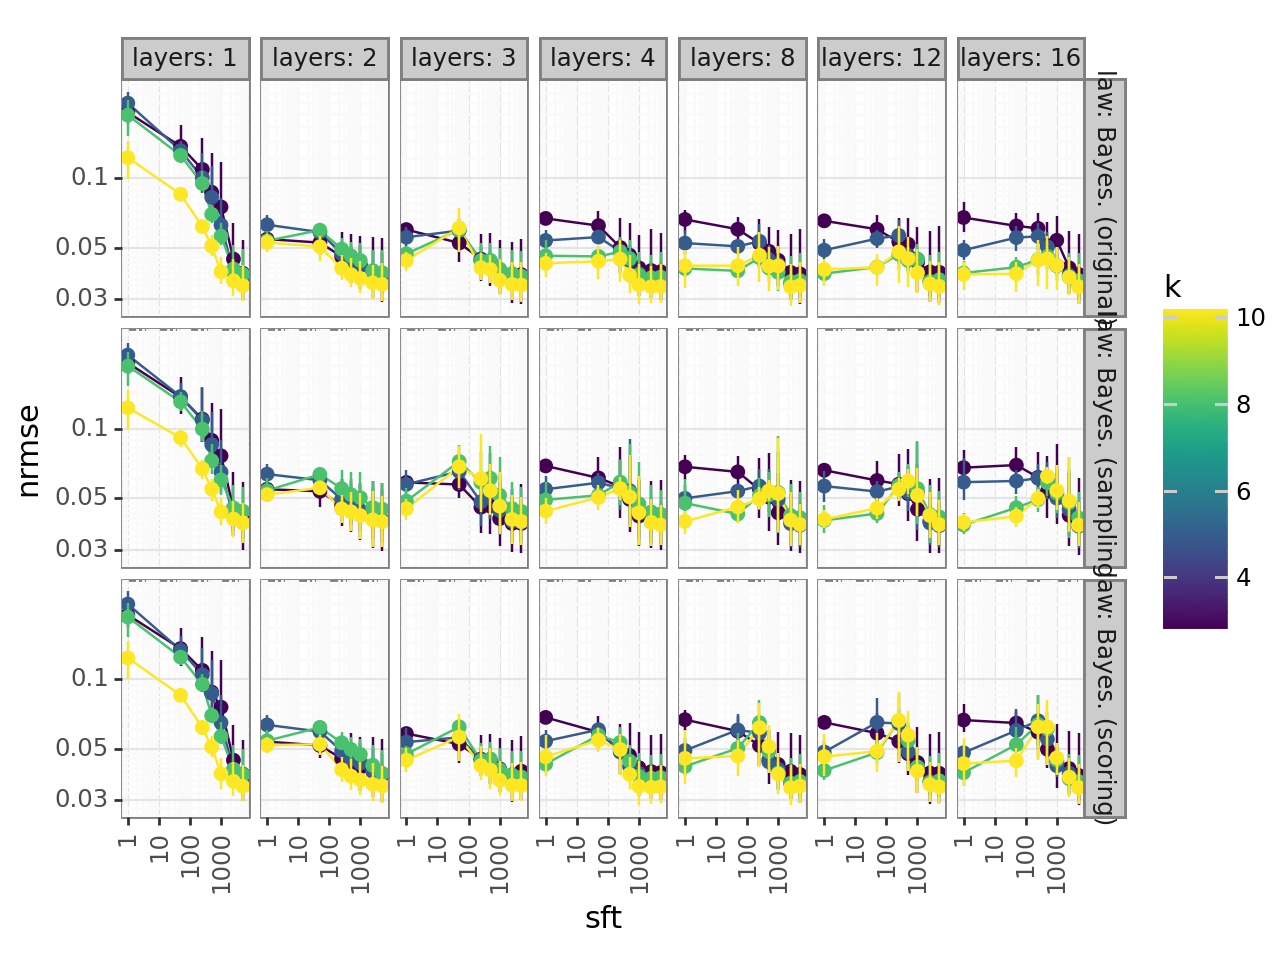

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 2.5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/law_comparison_sft.pdf


In [107]:
plot = (
    ggplot(params_sft_df, aes(x="sft", y="nrmse", group="k", color="k")) +
    stat_summary(geom="line") + stat_summary() + facet_grid("law~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10() + scale_y_log10()
)
print(plot)
plot.save('paper/law_comparison_sft.pdf', width=7, height=2.5)

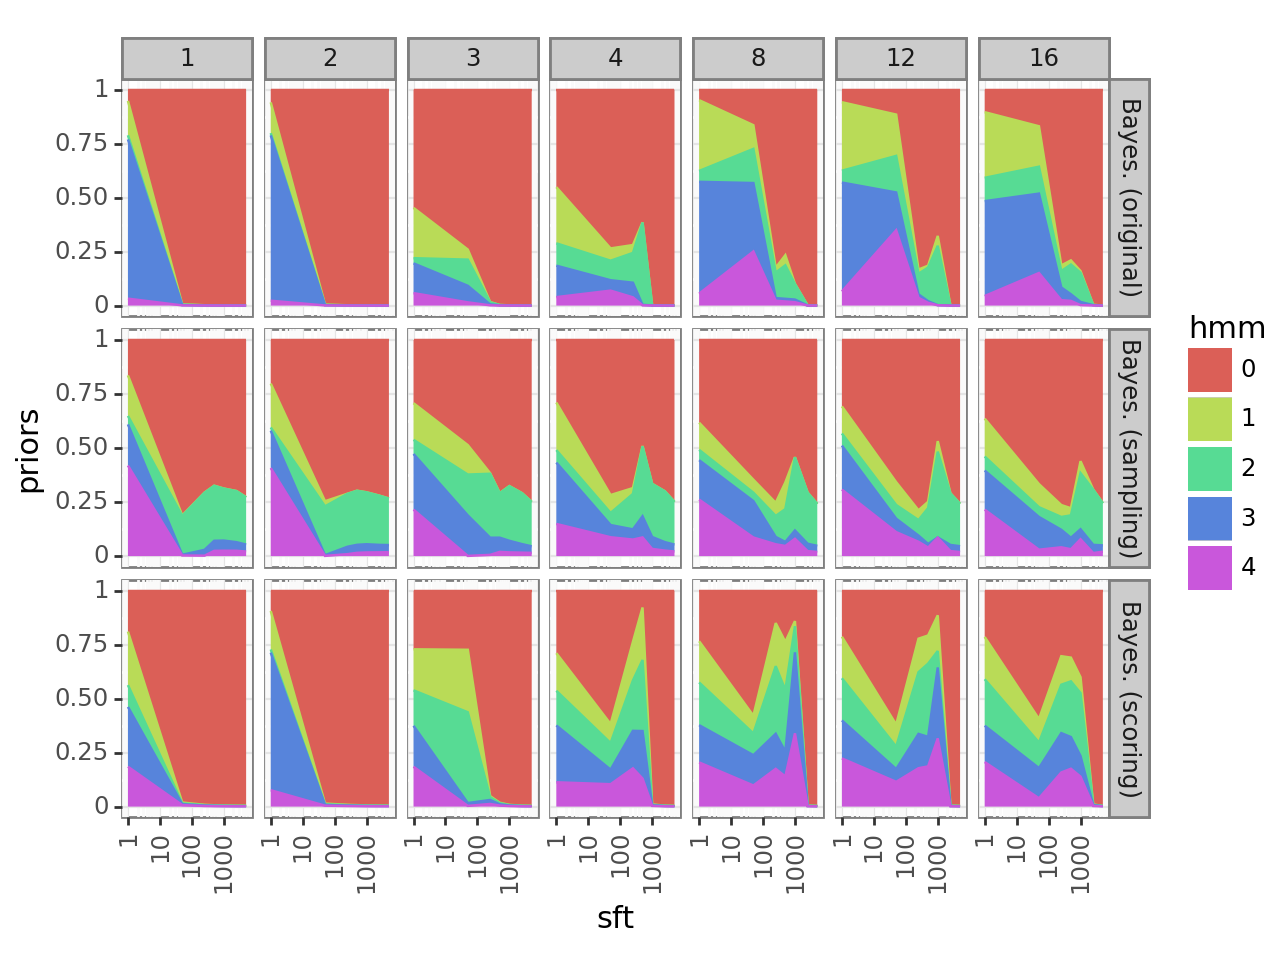

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 2.5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/priors_sft.pdf


In [117]:
plot = (
    ggplot(params_sft_df[((params_sft_df["k"] == 10))], aes(x="sft", y="priors", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="area", position="stack") + facet_grid("law~layers", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10()
)
print(plot)
plot.save('paper/priors_sft.pdf', width=7, height=2.5)

['1', '50', '250', '500', '1000', '2500', '5000']


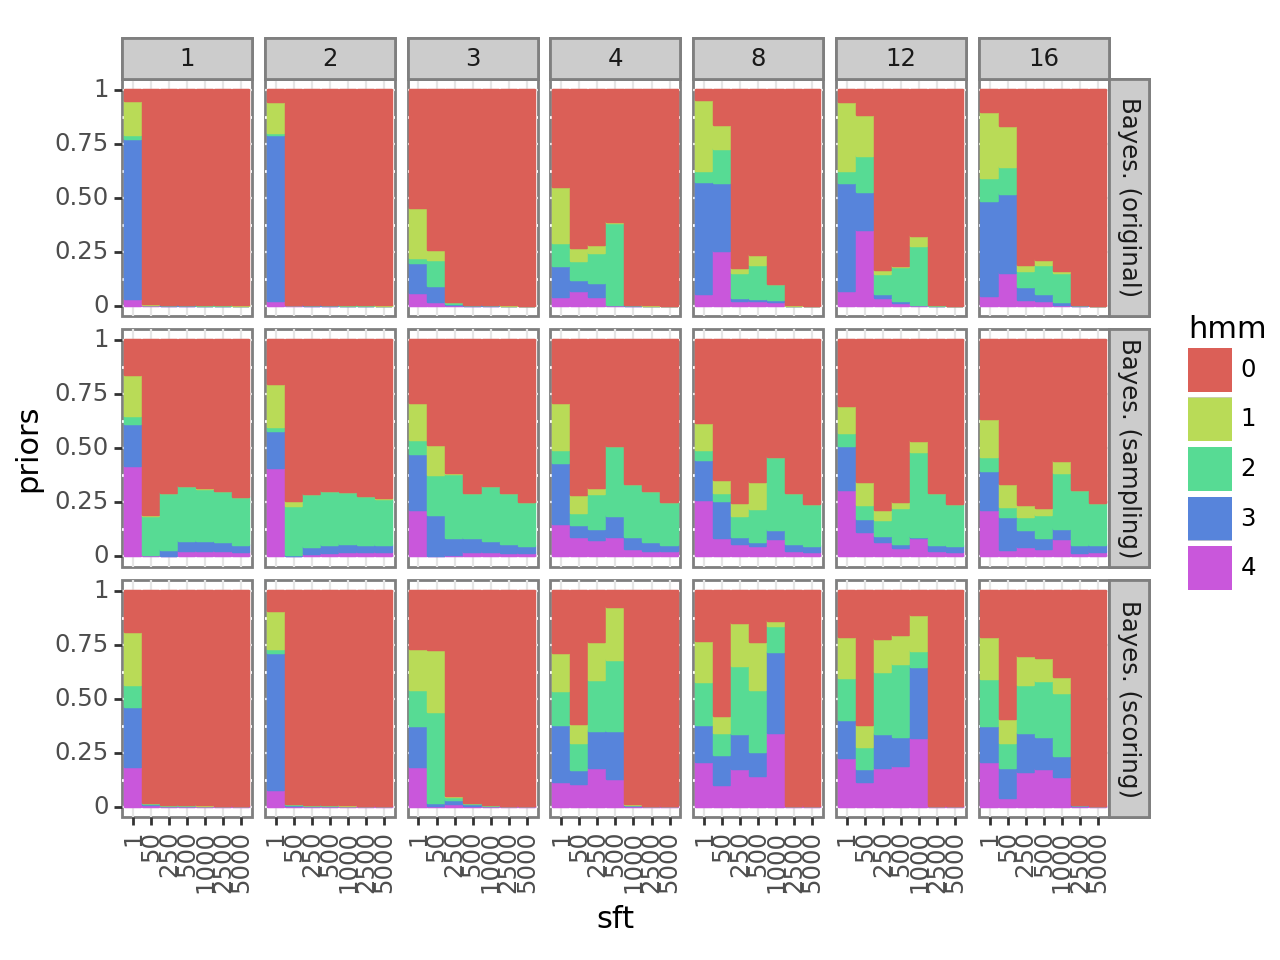

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 2.5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/priors_sft2.pdf


In [116]:
params_df_sft_temp = params_sft_df.copy()
order = list(map(str, sorted(map(int, params_df_sft_temp["sft"].unique()))))
print(order)
params_df_sft_temp["sft"] = pd.Categorical(params_df_sft_temp['sft'].astype(str), categories=order, ordered=True)
plot = (
    ggplot(params_df_sft_temp[((params_df_sft_temp["k"] == 10))], aes(x="sft", y="priors", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="bar", position="stack") + facet_grid("law~layers", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/priors_sft2.pdf', width=7, height=2.5)

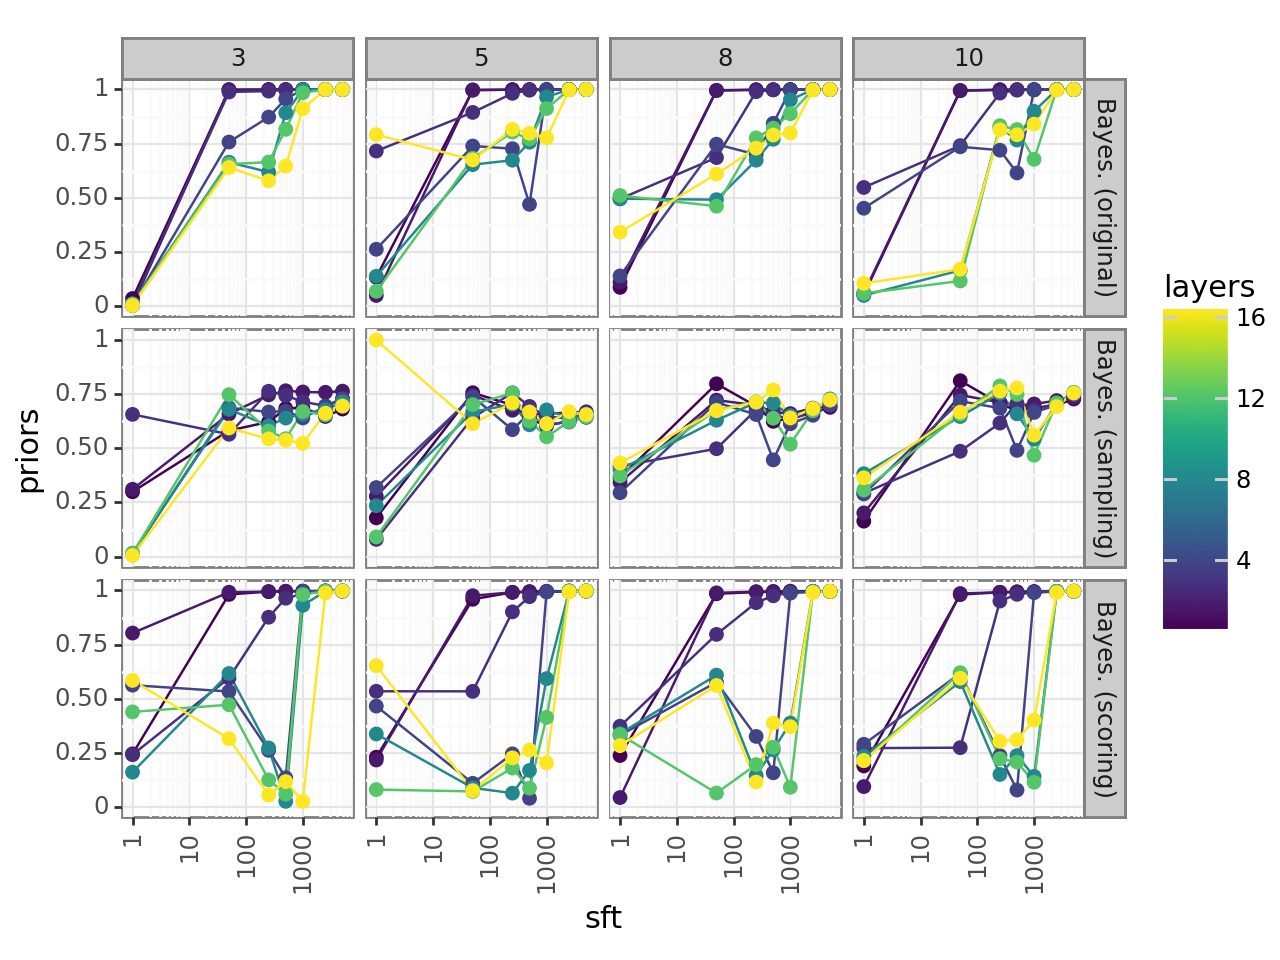

In [118]:
plot = (
    ggplot(params_sft_df[params_sft_df["hmm"] == 0], aes(x="sft", y="priors", group="layers", color="layers", fill="layers")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("law~k", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10()
)
print(plot)
# plot.save('paper/priors.pdf', width=5, height=2.5)

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 245 rows containing non-finite values.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 245 rows containing non-finite values.


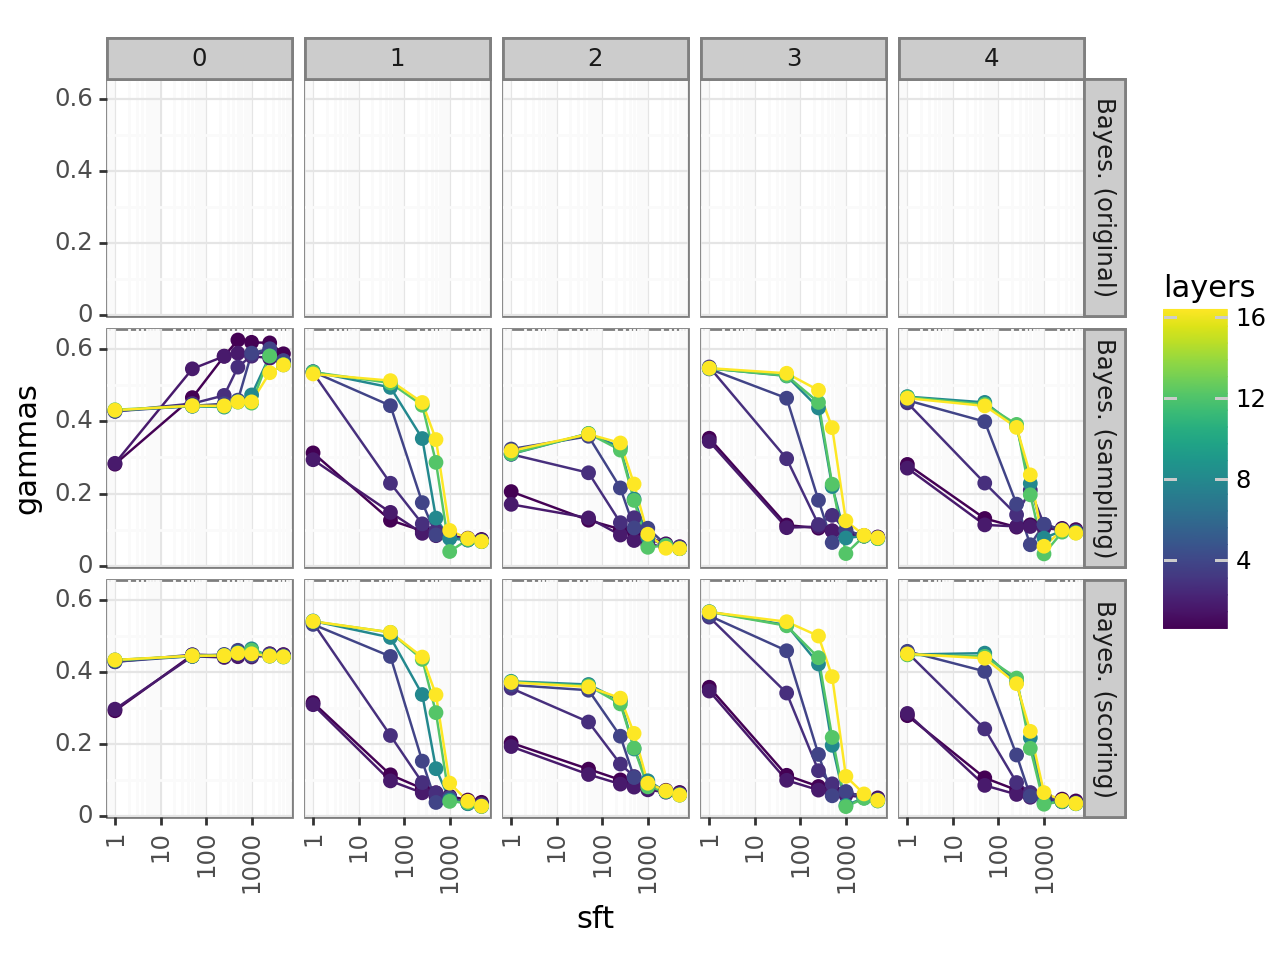

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 3.5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/gammas_sft.pdf
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 245 rows containing non-finite values.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 245 rows containing non-finite values.


In [119]:
plot = (
    ggplot(params_sft_df[((params_sft_df["k"] == 10))], aes(x="sft", y="gammas", group="layers", color="layers", fill="layers")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("law~hmm", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10()
)
print(plot)
plot.save('paper/gammas_sft.pdf', width=7, height=3.5)

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 245 rows containing non-finite values.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 245 rows containing non-finite values.


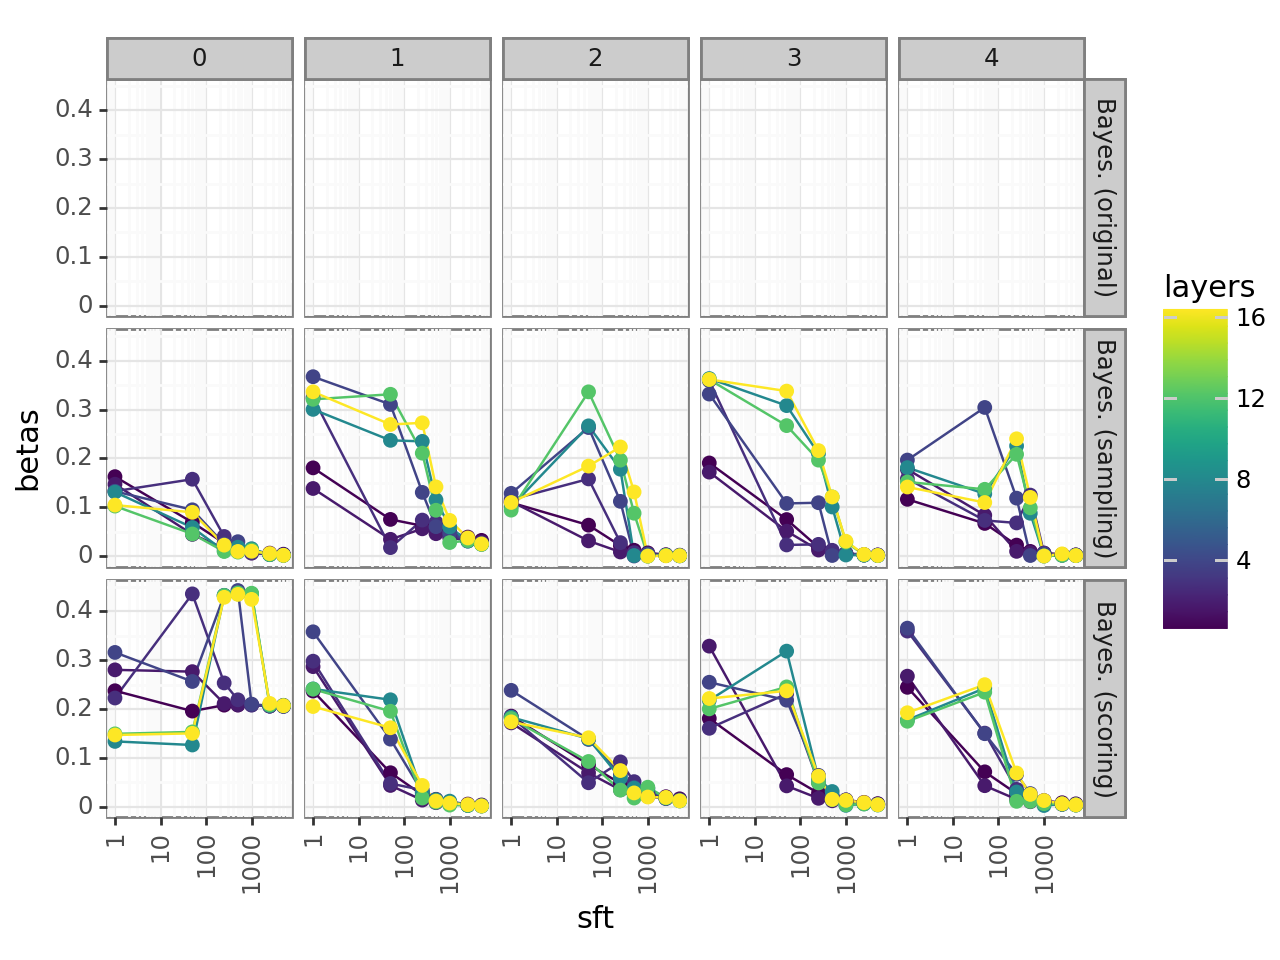

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 3.5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/betas_sft.pdf
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 245 rows containing non-finite values.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 245 rows containing non-finite values.


In [120]:
plot = (
    ggplot(params_sft_df[((params_sft_df["k"] == 10))], aes(x="sft", y="betas", group="layers", color="layers", fill="layers")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("law~hmm", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10()
)
print(plot)
plot.save('paper/betas_sft.pdf', width=7, height=3.5)

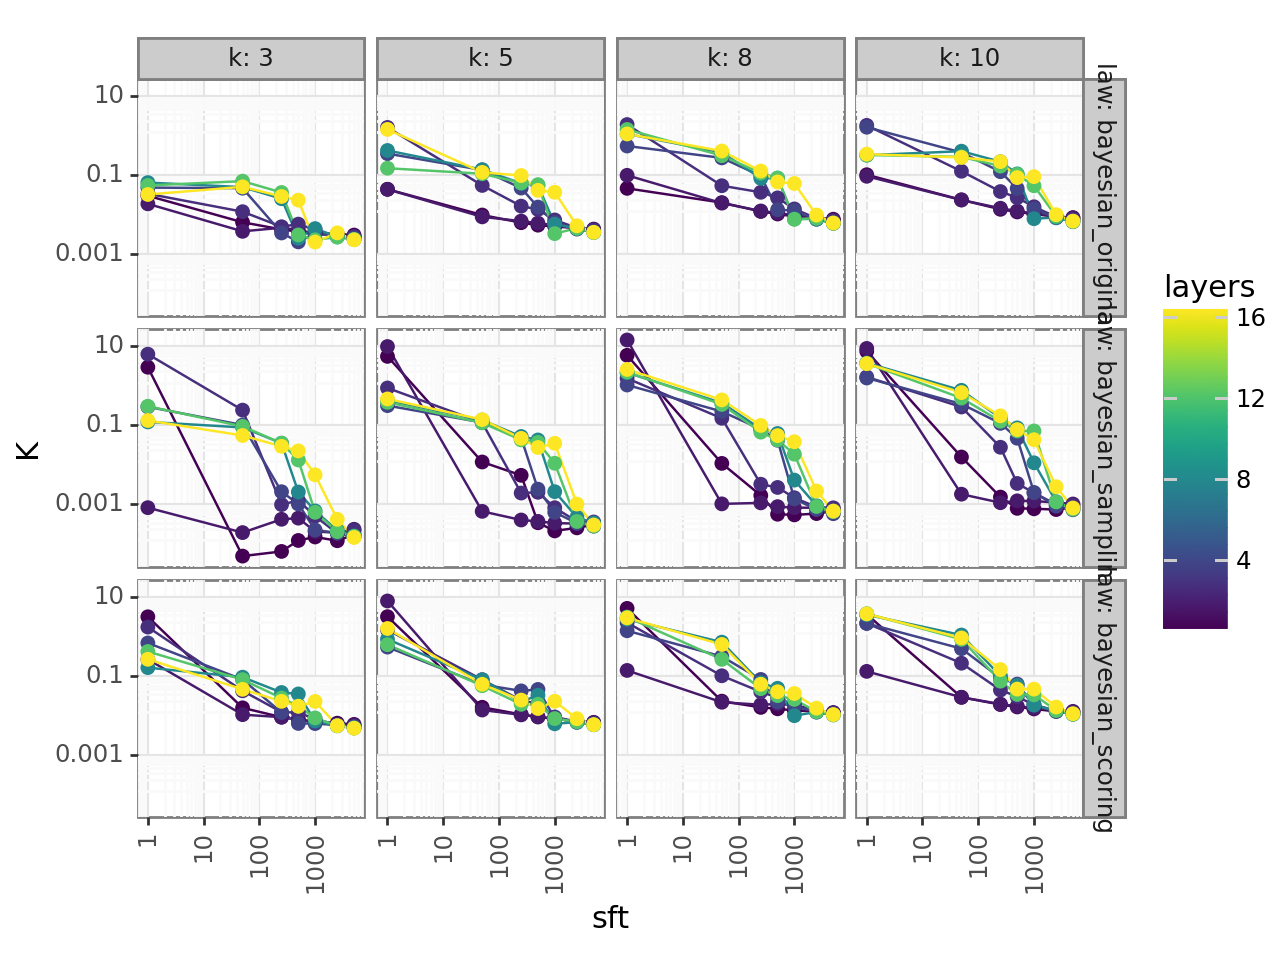

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 2.5 in image.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: paper/K_sft.pdf


In [60]:
plot = (
    ggplot(params_sft_df, aes(x="sft", y="K", group="layers", color="layers", fill="layers")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("law~k", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10() + scale_y_log10()
)
print(plot)
plot.save('paper/K_sft.pdf', width=7, height=2.5)

## MSE

In [25]:
data

Unnamed: 0  shots  k  hmm   sft  sft_amount      prob       acc  \
0                0      0  3    0     0           0  0.226609  0.370370   
13              13      0  3    0    60          50  0.391857  0.675926   
21              21      0  3    0   300         250  0.433783  0.726852   
27              27      0  3    0   600         500  0.453057  0.814815   
33              33      0  3    0  1200        1000  0.452990  0.861111   
...            ...    ... ..  ...   ...         ...       ...       ...   
135858      135858    255  3    4   300         250  0.153366  0.215116   
135864      135864    255  3    4   600         500  0.115279  0.174419   
135870      135870    255  3    4  1200        1000  0.087596  0.110465   
135875      135875    255  3    4  3000        2500  0.083008  0.110465   
135879      135879    255  3    4  6000        5000  0.078674  0.093023   

             nll  
0       1.772636  
13      1.081651  
21      0.952783  
27      0.894260  
33      0.879554  
...          ...  
135858  3.358529  
135864  4.186858  
135870  4.986712  
135875  5.508345  
135879  5.662209  

[22120 rows x 9 columns]

In [43]:
mses = []
for law in tqdm(laws):
    for k in laws[law]:
        model = laws[law][k]
        subset = data[(data['k'] == k)]
        for sft in subset['sft_amount'].unique():
            overall_mse = []
            vals = []
            for hmm in subset['hmm'].unique():
                for shots in subset['shots'].unique():
                    subsubset = subset[(subset['hmm'] == hmm) & (subset['sft_amount'] == sft) & (subset['shots'] == shots)]
                    nll = subsubset['nll'].mean()
                    pred = model(torch.tensor(shots), torch.tensor(hmm), torch.tensor(sft)).item()
                    mse = (nll - pred)**2
                    vals.append(nll)
                    overall_mse.append(mse)
            mse = sum(overall_mse) / len(overall_mse)
            rmse = mse**(0.5)
            nrmse = rmse / (sum(vals) / len(vals))
            mses.append({"k": k, "sft": sft, "mse": mse, "rmse": rmse, "nrmse": nrmse})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:35<00:00, 15.51s/it]


In [47]:
mses2 = []
for law in tqdm(laws2):
    for (k, sft) in laws2[law]:
        model = laws2[law][(k, sft)]
        subset = data[(data['k'] == k) & (data['sft_amount'] == sft)]
        overall_mse = []
        vals = []
        for hmm in subset['hmm'].unique():
            for shots in subset['shots'].unique():
                subsubset = subset[(subset['hmm'] == hmm) & (subset['sft_amount'] == sft) & (subset['shots'] == shots)]
                nll = subsubset['nll'].mean()
                pred = model(torch.tensor(shots), torch.tensor(hmm), torch.tensor(sft)).item()
                mse = (nll - pred)**2
                vals.append(nll)
                overall_mse.append(mse)
        mse = sum(overall_mse) / len(overall_mse)
        rmse = mse**(0.5)
        nrmse = rmse / (sum(vals) / len(vals))
        mses2.append({"k": k, "sft": sft, "mse": mse, "rmse": rmse, "nrmse": nrmse})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:30<00:00, 15.07s/it]


In [48]:
mses_all = []
for mse in mses:
    mse['law'] = 'tied'
    mses_all.append(mse)
for mse in mses2:
    mse['law'] = 'untied'
    mses_all.append(mse)

      k   sft       mse      rmse     nrmse     law
0     3     0  0.025573  0.159916  0.081242    tied
1     3    50  0.043223  0.207901  0.084564    tied
2     3   250  0.026246  0.162006  0.049050    tied
3     3   500  0.030578  0.174867  0.045550    tied
4     3  1000  0.030354  0.174223  0.039714    tied
..   ..   ...       ...       ...       ...     ...
555  10   250  0.008879  0.094228  0.056446  untied
556  10   500  0.017714  0.133093  0.051629  untied
557  10  1000  0.019321  0.138999  0.039567  untied
558  10  2500  0.026743  0.163532  0.038908  untied
559  10  5000  0.031638  0.177869  0.039368  untied

[560 rows x 6 columns]


/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 80 rows containing non-finite values.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 80 rows containing non-finite values.


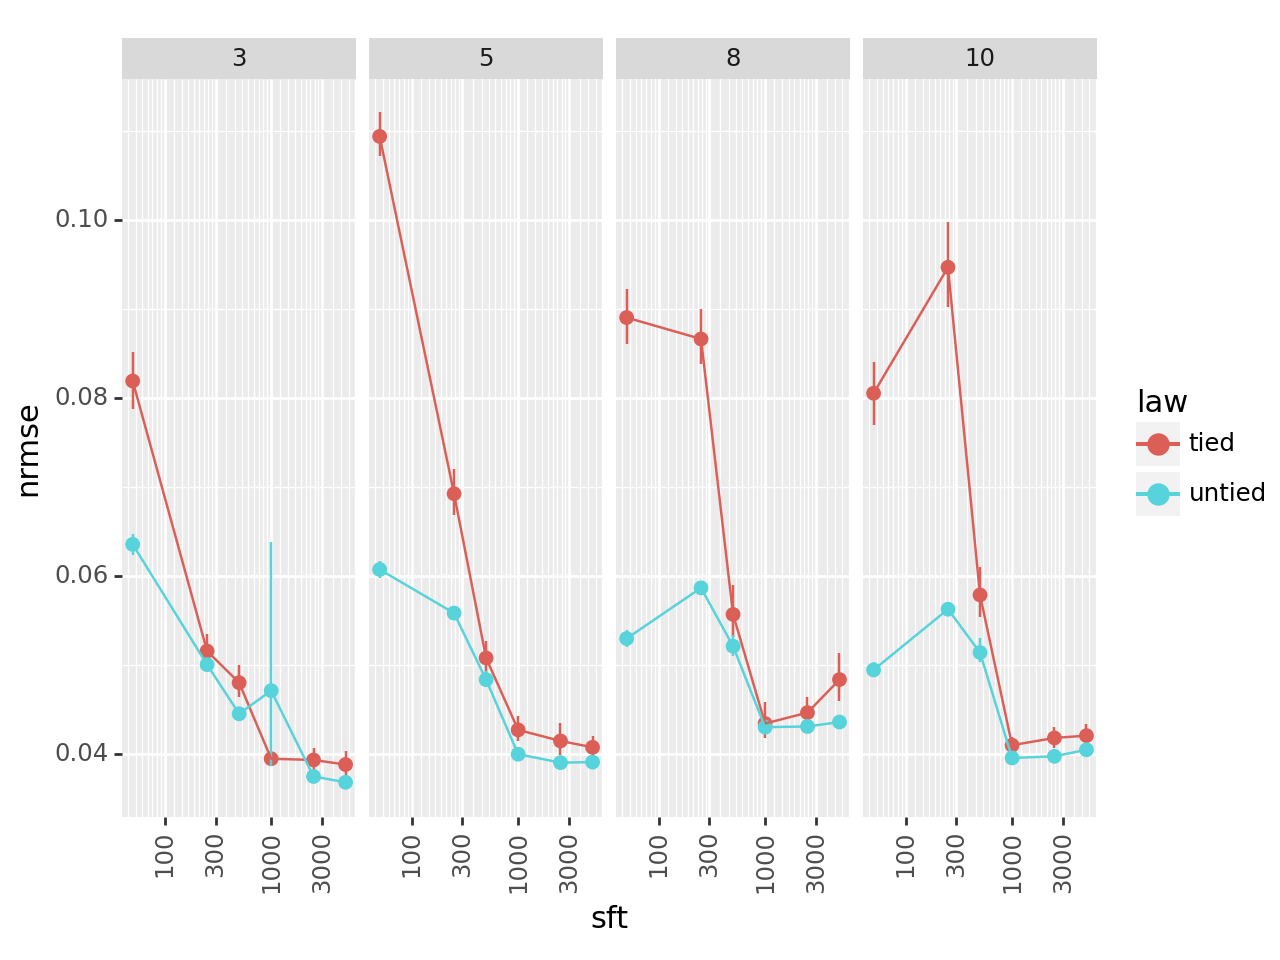

In [50]:
mse_df = pd.DataFrame(mses_all)
print(mse_df)
plot = (
    ggplot(mse_df, aes(x="sft", y="nrmse", color="law")) + stat_summary() +
    stat_summary(geom="line") + facet_grid("~k") + theme(axis_text_x=element_text(rotation=90)) +
    scale_x_log10()
)
print(plot)

      k   sft       mse      rmse     nrmse     law
0     3     0  0.025573  0.159916  0.081242    tied
1     3    50  0.043223  0.207901  0.084564    tied
2     3   250  0.026246  0.162006  0.049050    tied
3     3   500  0.030578  0.174867  0.045550    tied
4     3  1000  0.030354  0.174223  0.039714    tied
..   ..   ...       ...       ...       ...     ...
555  10   250  0.008879  0.094228  0.056446  untied
556  10   500  0.017714  0.133093  0.051629  untied
557  10  1000  0.019321  0.138999  0.039567  untied
558  10  2500  0.026743  0.163532  0.038908  untied
559  10  5000  0.031638  0.177869  0.039368  untied

[560 rows x 6 columns]


/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 80 rows containing non-finite values.
/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 80 rows containing non-finite values.


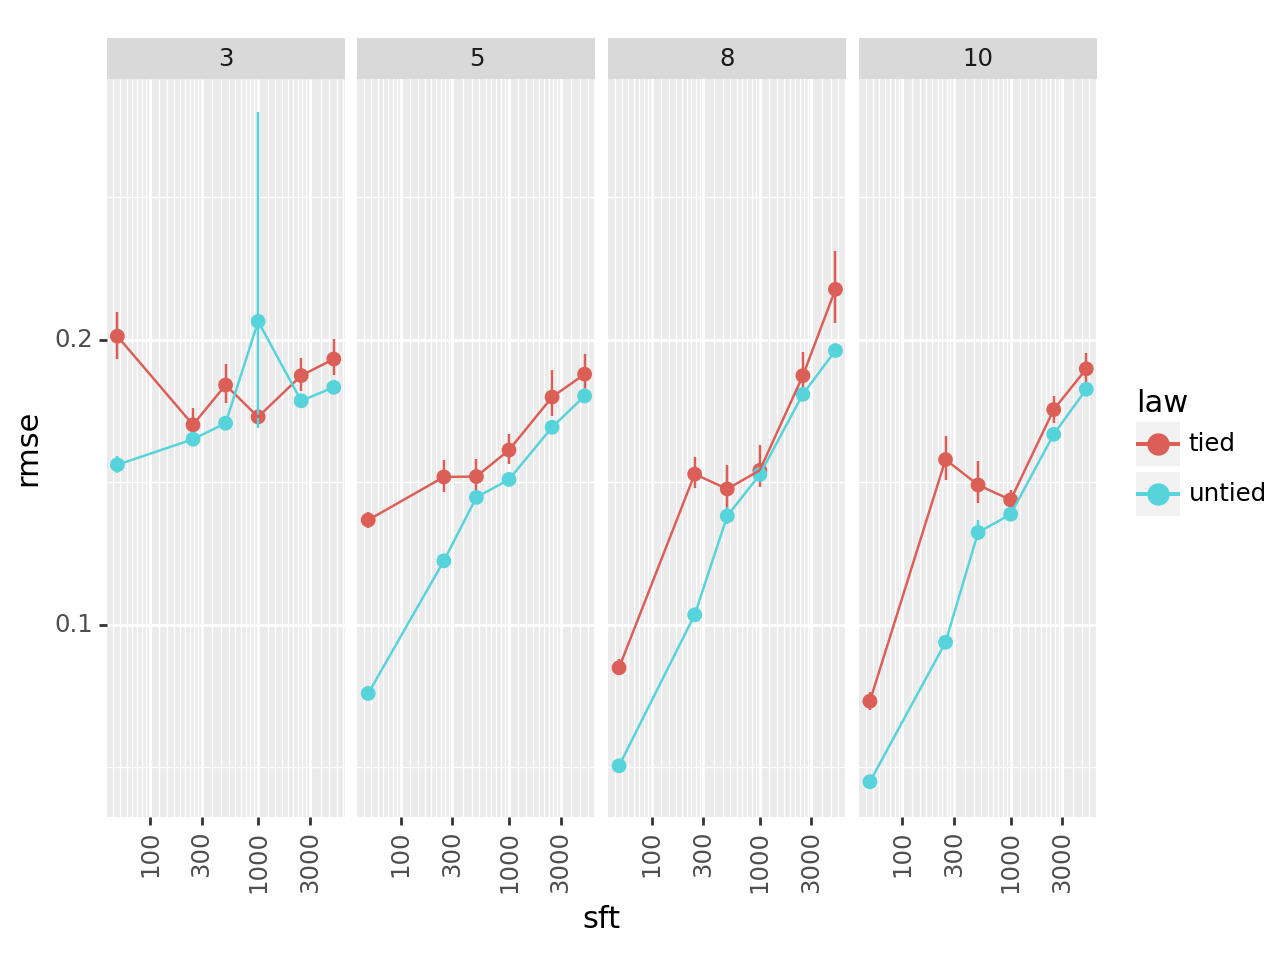

In [51]:
mse_df = pd.DataFrame(mses_all)
print(mse_df)
plot = (
    ggplot(mse_df, aes(x="sft", y="rmse", color="law")) + stat_summary() +
    stat_summary(geom="line") + facet_grid("~k") + theme(axis_text_x=element_text(rotation=90)) +
    scale_x_log10()
)
print(plot)

## Checking a single ICL curve

In [78]:
data = pd.read_csv(f"logs/4-1,1,1,1,1-1,0,0,0,0/in_context_probs.csv")
print(data["sft"].unique())
print(data["sft_amount"].unique())
data

[   0    1   10   20   30   40   50   60  100  150  200  250  300  400
  500  600  800 1000 1200 1500 2000 2500 3000 4000 5000 6000]
[   0   50  250  500 1000 2500 5000]


Unnamed: 0  shots  k  hmm   sft  sft_amount      prob       acc  \
0                0      0  3    0     0           0  0.226609  0.370370   
1                1      0  3    0     1          50  0.391075  0.680556   
2                2      0  3    0     1         250  0.434198  0.736111   
3                3      0  3    0     1         500  0.453500  0.819444   
4                4      0  3    0     1        1000  0.456069  0.865741   
...            ...    ... ..  ...   ...         ...       ...       ...   
135875      135875    255  3    4  3000        2500  0.083008  0.110465   
135876      135876    255  3    4  3000        5000  0.079005  0.093023   
135877      135877    255  3    4  4000        5000  0.077644  0.093023   
135878      135878    255  3    4  5000        5000  0.076812  0.087209   
135879      135879    255  3    4  6000        5000  0.078674  0.093023   

             nll  
0       1.772636  
1       1.083433  
2       0.949646  
3       0.892285  
4       0.871469  
...          ...  
135875  5.508345  
135876  5.541188  
135877  5.652903  
135878  5.676421  
135879  5.662209  

[135880 rows x 9 columns]

In [80]:
filter = (data['sft_amount'] == -1)
for sft_amount in data['sft_amount'].unique():
    maxi = data[data['sft_amount'] == sft_amount]['sft'].max()
    filter |= ((data['sft'] == maxi) & (data['sft_amount'] == sft_amount)) 
data = data[filter]

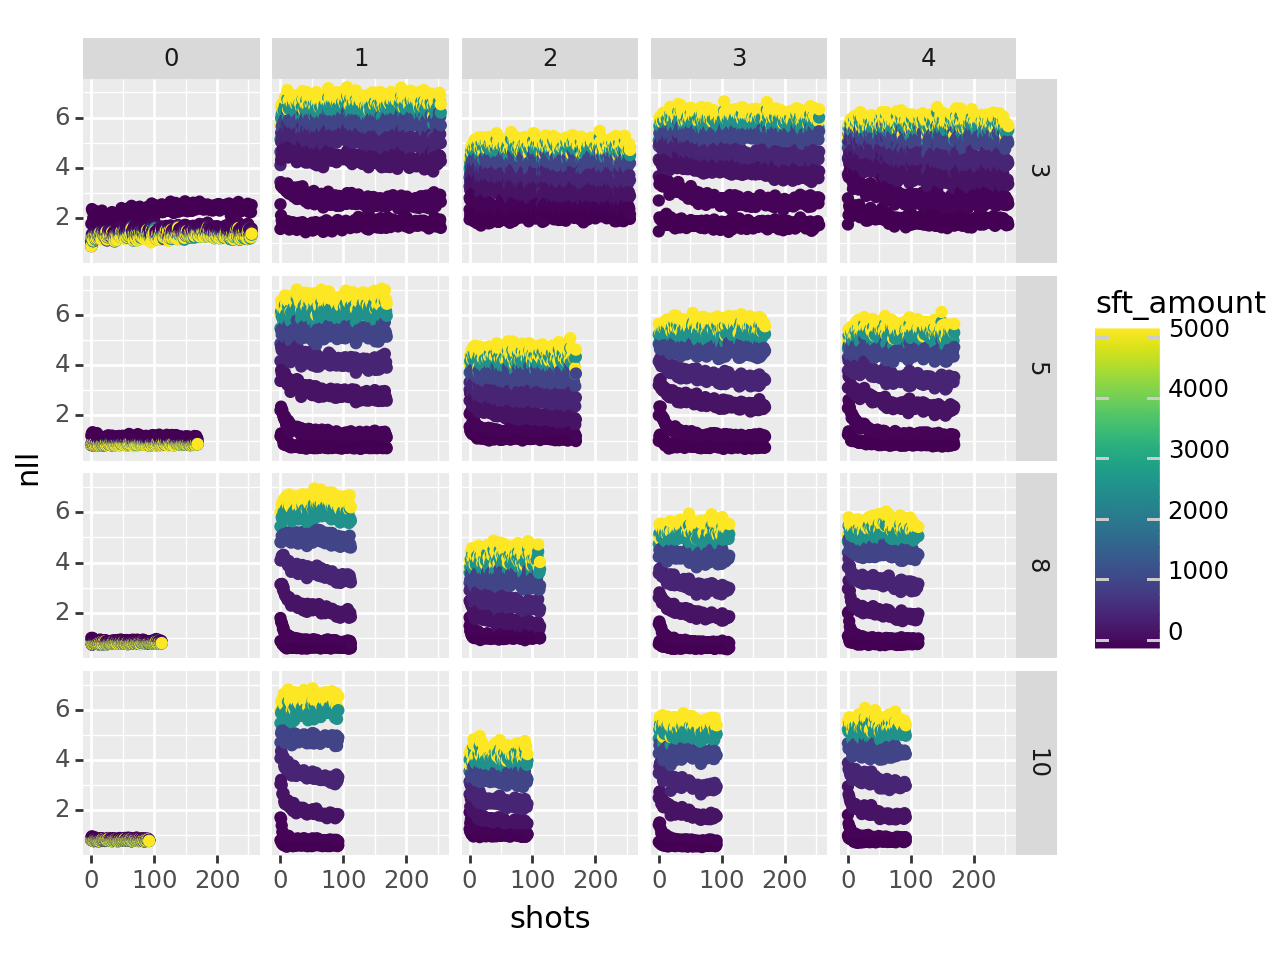

In [81]:
plot = (
    ggplot(data, aes(x="shots", y="nll", color="sft_amount")) + geom_point() +
    facet_grid("k~hmm")
)
print(plot)

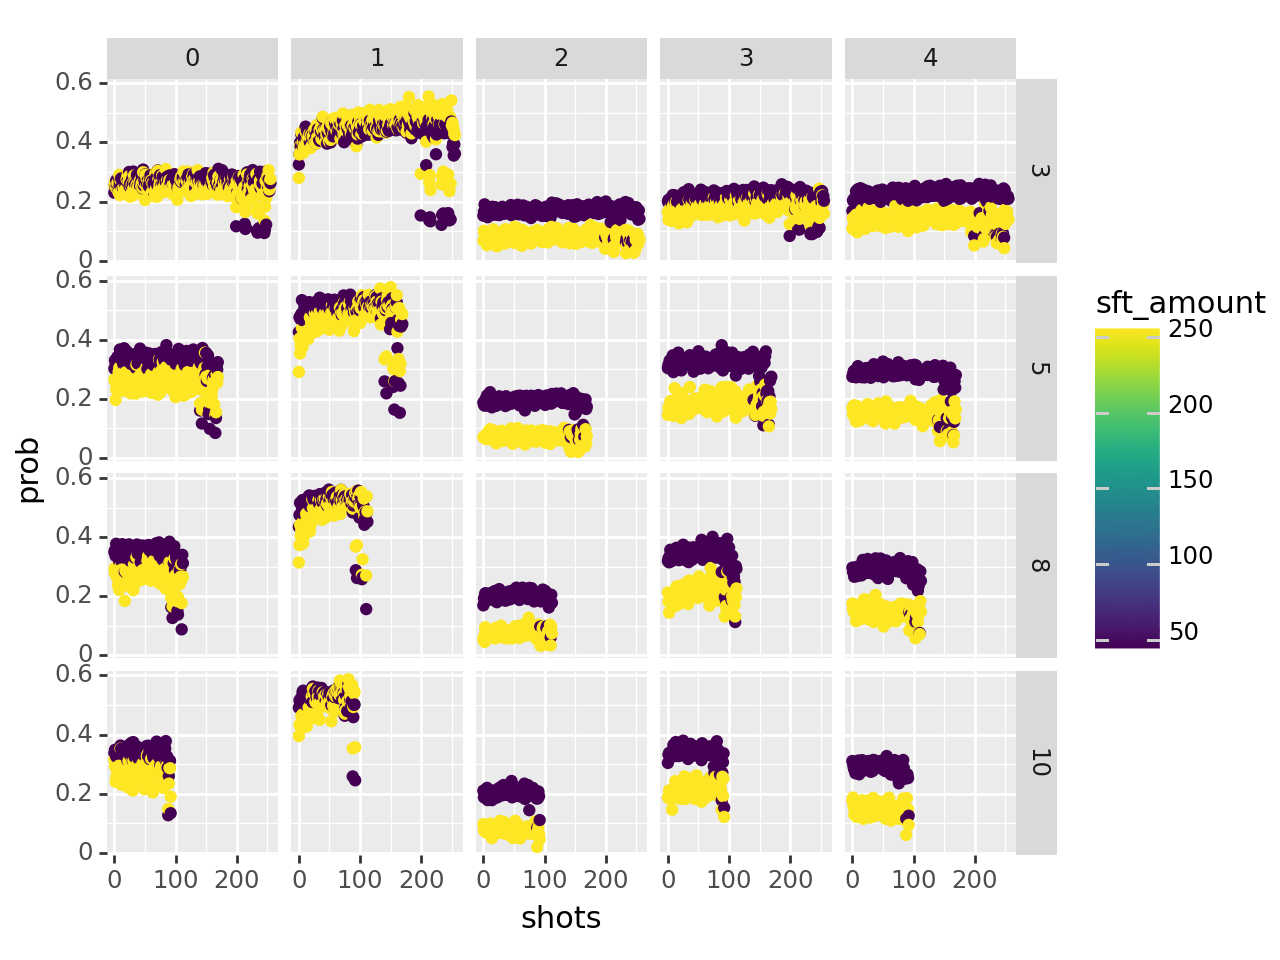

In [32]:
plot = (
    ggplot(data[data["sft"] == 1], aes(x="shots", y="prob", color="sft_amount")) + geom_point() +
    facet_grid("k~hmm")
)
print(plot)

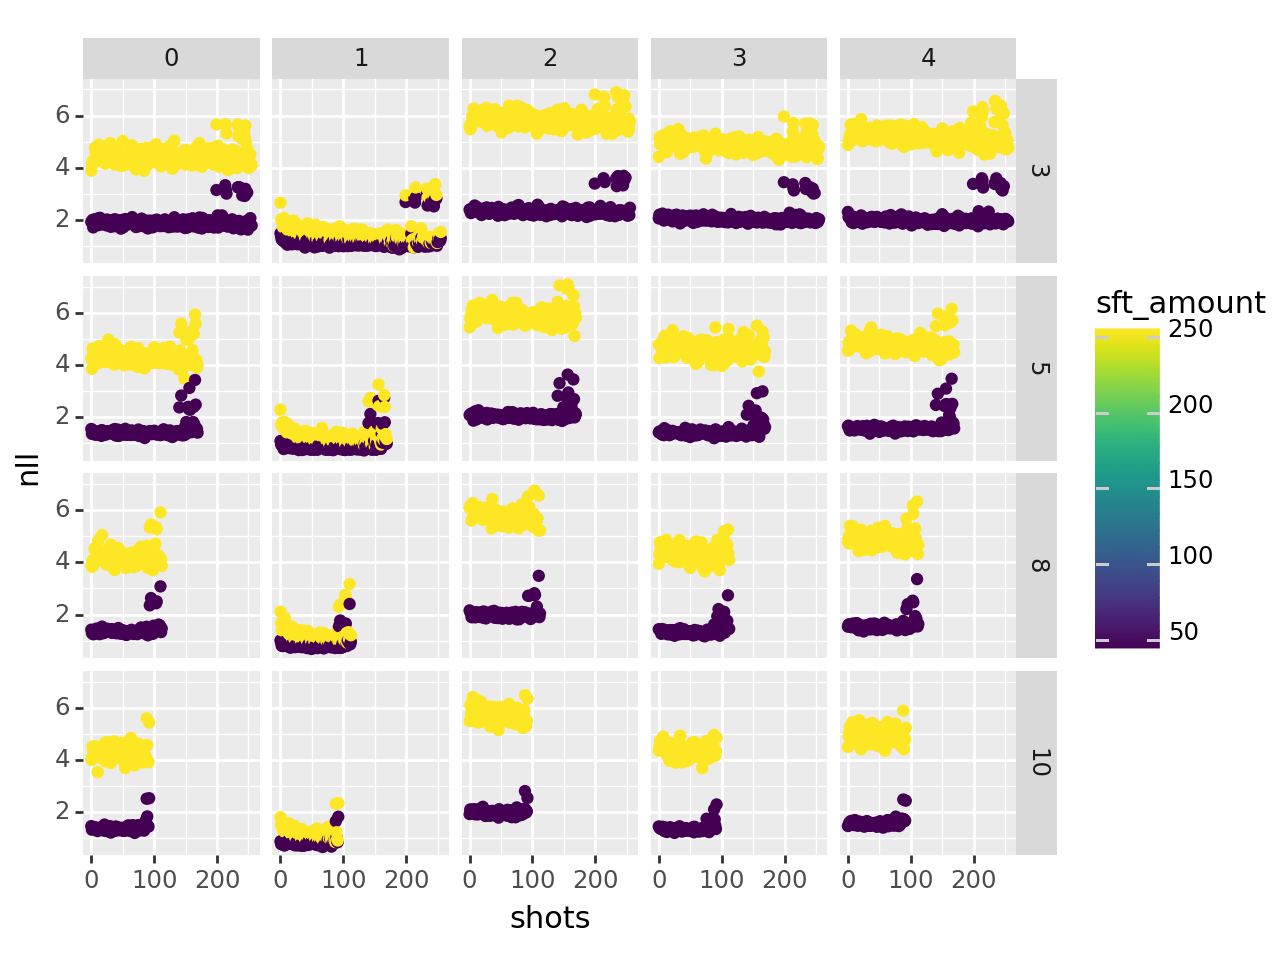

In [20]:
plot = (
    ggplot(data, aes(x="shots", y="nll", color="sft_amount")) + geom_point() +
    facet_grid("k~hmm")
)
print(plot)

## MSE analysis

In [2]:
dfs = []
pretrain: str="1,1,1,1,1"
sft: str="1,0,0,0,0"
layers: str="1,2,3,4,8,12,16"
for layer in layers.split(","):
    # set up dir
    directory = f"figs/{pretrain}-{sft}/"
    if os.path.exists(f"{directory}/all_law_params-{layer}-sft.csv"):
        # load data
        data = pd.read_csv(f"{directory}/all_law_params-{layer}-sft.csv")
        data['layers'] = int(layer)
        dfs.append(data)
    else:
        print(f"File {directory}/all_law_params-{layer}-sft.csv does not exist")

# format df
df_all = pd.concat(dfs)
order = list(map(str, sorted(df_all['layers'].unique())))
df_all['layers'] = pd.Categorical(df_all['layers'].astype(str), categories=order, ordered=True)

# drop sft_amount == "none"
df_all = df_all[df_all['sft_amount'] != "none"]
df_all['sft_amount'] = df_all['sft_amount'].astype(float)

In [3]:
df_all

sft_amount   k  hmm       law    priors    gammas     betas         K  \
0           0.0   3    0  bayesian  0.014282  0.168797  0.159583  0.025997   
1           0.0   3    1  bayesian  0.517847  0.199783  0.160128  0.025997   
2           0.0   3    2  bayesian  0.027260  0.144286  0.160618  0.025997   
3           0.0   3    3  bayesian  0.377686  0.198030  0.155233  0.025997   
4           0.0   3    4  bayesian  0.062925  0.190270  0.145870  0.025997   
..          ...  ..  ...       ...       ...       ...       ...       ...   
555      5000.0  10    3   bounded       NaN       NaN       NaN  5.424638   
556      5000.0  10    3  logistic       NaN       NaN       NaN  0.002289   
557      5000.0  10    4     power       NaN       NaN       NaN  5.539362   
558      5000.0  10    4   bounded       NaN       NaN       NaN  5.432049   
559      5000.0  10    4  logistic       NaN       NaN       NaN  0.002124   

          mse      rmse     nrmse         C     alpha       n_c layers  
0    0.089526  0.299209  0.087901       NaN       NaN       NaN      1  
1    0.139895  0.374026  0.109880       NaN       NaN       NaN      1  
2    0.125131  0.353739  0.103921       NaN       NaN       NaN      1  
3    0.116200  0.340881  0.100143       NaN       NaN       NaN      1  
4    0.137834  0.371261  0.109068       NaN       NaN       NaN      1  
..        ...       ...       ...       ...       ...       ...    ...  
555  0.032319  0.179776  0.061099  1.878804  2.715995  2.124388     16  
556  0.033089  0.181905  0.061823  0.002232  1.274660  3.327459     16  
557  0.043504  0.208576  0.070887  0.862824  2.118194       NaN     16  
558  0.037340  0.193237  0.065674  1.814331  3.120501  1.946952     16  
559  0.035822  0.189266  0.064325  0.002089  0.711832  2.973644     16  

[3920 rows x 15 columns]

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


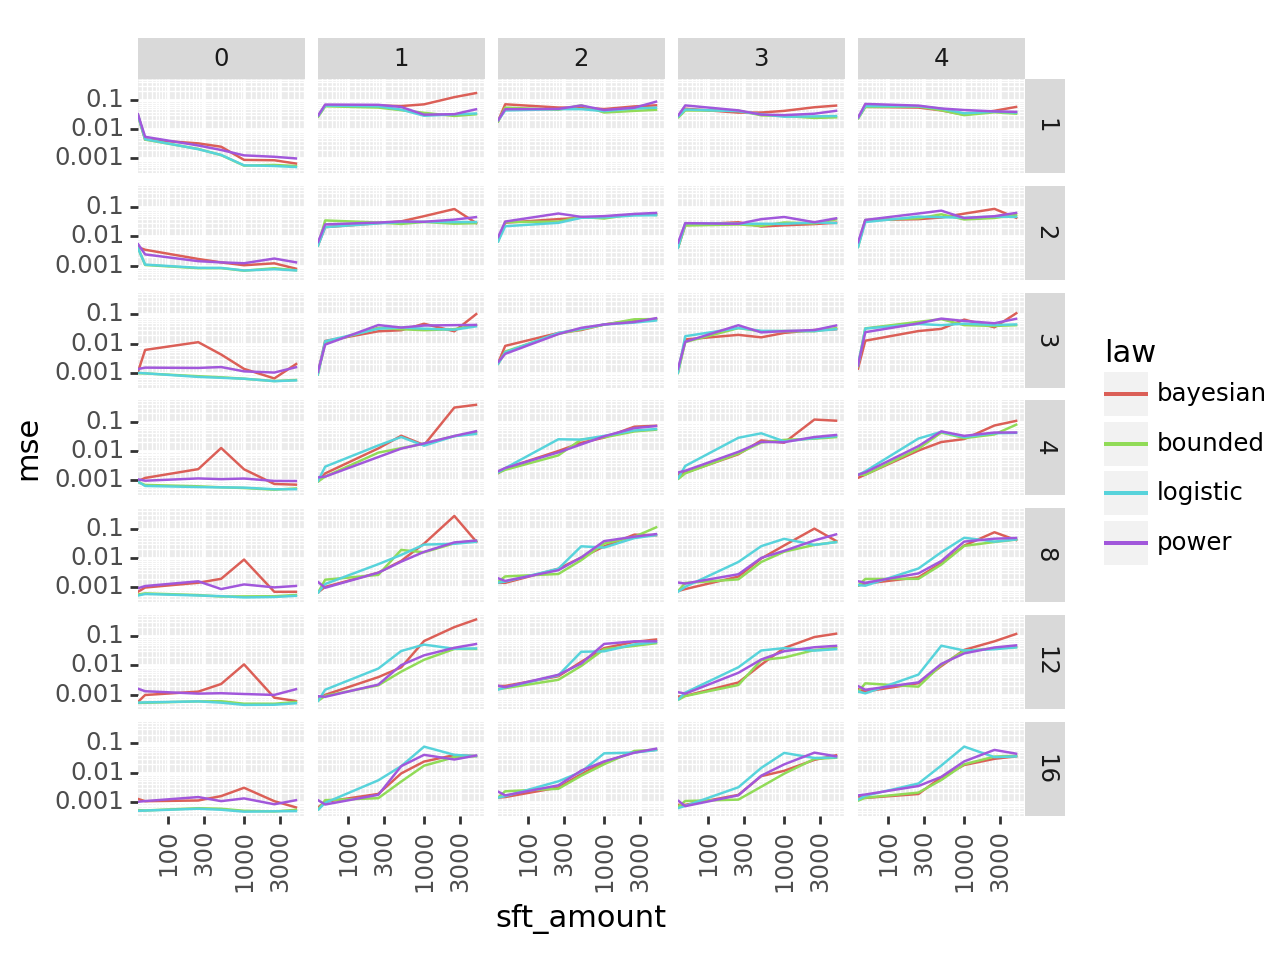

In [7]:
plot = (
    ggplot(df_all[(df_all["k"] == 10)], aes(x='sft_amount', y='mse', color='law')) +
    geom_line() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("layers~hmm") + scale_x_log10() + scale_y_log10()
)
print(plot)

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


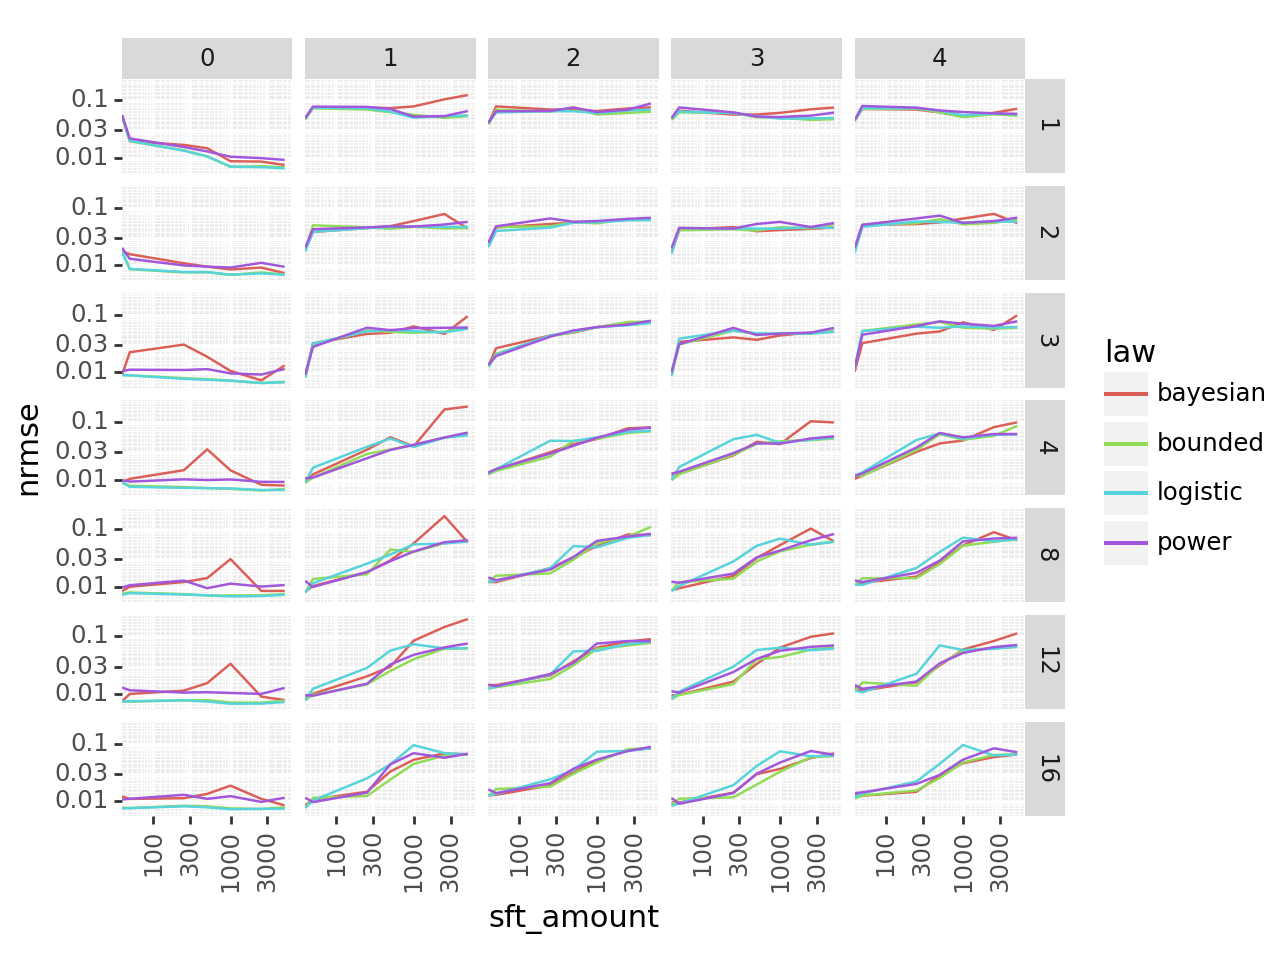

In [10]:
plot = (
    ggplot(df_all[(df_all["k"] == 10)], aes(x='sft_amount', y='nrmse', color='law')) +
    geom_line() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("layers~hmm") + scale_x_log10() + scale_y_log10()
)
print(plot)

In [41]:
df_all = df_all[df_all['law'] == 'bayesian']
df_all

sft_amount   k  hmm       law    priors    gammas     betas         K  \
0           0.0   3    0  bayesian  0.019674  0.147148  0.125671  1.845644   
1           0.0   3    1  bayesian  0.239009  0.214668  0.121395  1.845644   
2           0.0   3    2  bayesian  0.397768  0.145471  0.161931  1.845644   
3           0.0   3    3  bayesian  0.250321  0.196507  0.105006  1.845644   
4           0.0   3    4  bayesian  0.093228  0.160974  0.116079  1.845644   
..          ...  ..  ...       ...       ...       ...       ...       ...   
540      5000.0  10    0  bayesian  0.909116  0.475441  0.001569  0.001004   
541      5000.0  10    1  bayesian  0.000268  0.084418  0.071891  0.001004   
542      5000.0  10    2  bayesian  0.062650  0.150061  0.003313  0.001004   
543      5000.0  10    3  bayesian  0.015231  0.142806  0.004896  0.001004   
544      5000.0  10    4  bayesian  0.012735  0.155852  0.008329  0.001004   

          mse   C  alpha  n_c layers  
0    0.088883 NaN    NaN  NaN      1  
1    0.137650 NaN    NaN  NaN      1  
2    0.106110 NaN    NaN  NaN      1  
3    0.113368 NaN    NaN  NaN      1  
4    0.135997 NaN    NaN  NaN      1  
..        ...  ..    ...  ...    ...  
540  0.000601 NaN    NaN  NaN     16  
541  0.036079 NaN    NaN  NaN     16  
542  0.061002 NaN    NaN  NaN     16  
543  0.031540 NaN    NaN  NaN     16  
544  0.033777 NaN    NaN  NaN     16  

[980 rows x 13 columns]

In [42]:
# df = pd.melt(df_all, id_vars=['sft_amount', 'k', 'hmm', 'layers'], value_vars=['gammas', 'betas'], var_name='metric', value_name='value')
from copy import deepcopy

df = deepcopy(df_all)
df['diff'] = df['gammas'] - df['betas']
df

sft_amount   k  hmm       law    priors    gammas     betas         K  \
0           0.0   3    0  bayesian  0.019674  0.147148  0.125671  1.845644   
1           0.0   3    1  bayesian  0.239009  0.214668  0.121395  1.845644   
2           0.0   3    2  bayesian  0.397768  0.145471  0.161931  1.845644   
3           0.0   3    3  bayesian  0.250321  0.196507  0.105006  1.845644   
4           0.0   3    4  bayesian  0.093228  0.160974  0.116079  1.845644   
..          ...  ..  ...       ...       ...       ...       ...       ...   
540      5000.0  10    0  bayesian  0.909116  0.475441  0.001569  0.001004   
541      5000.0  10    1  bayesian  0.000268  0.084418  0.071891  0.001004   
542      5000.0  10    2  bayesian  0.062650  0.150061  0.003313  0.001004   
543      5000.0  10    3  bayesian  0.015231  0.142806  0.004896  0.001004   
544      5000.0  10    4  bayesian  0.012735  0.155852  0.008329  0.001004   

          mse   C  alpha  n_c layers      diff  
0    0.088883 NaN    NaN  NaN      1  0.021477  
1    0.137650 NaN    NaN  NaN      1  0.093272  
2    0.106110 NaN    NaN  NaN      1 -0.016460  
3    0.113368 NaN    NaN  NaN      1  0.091501  
4    0.135997 NaN    NaN  NaN      1  0.044895  
..        ...  ..    ...  ...    ...       ...  
540  0.000601 NaN    NaN  NaN     16  0.473872  
541  0.036079 NaN    NaN  NaN     16  0.012527  
542  0.061002 NaN    NaN  NaN     16  0.146749  
543  0.031540 NaN    NaN  NaN     16  0.137910  
544  0.033777 NaN    NaN  NaN     16  0.147523  

[980 rows x 14 columns]

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


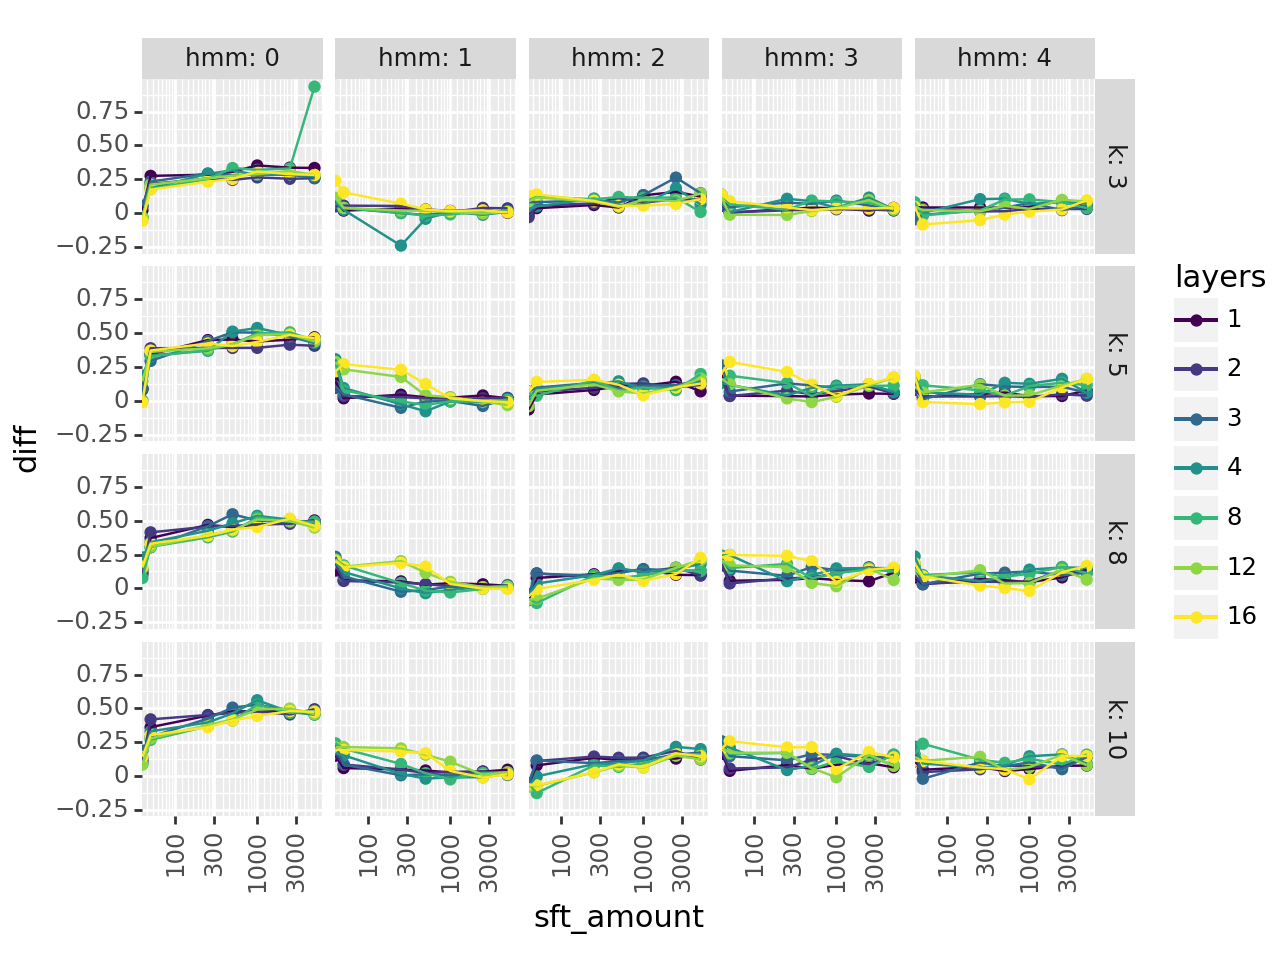

In [43]:
plot = (
    ggplot(df, aes(x='sft_amount', y='diff', color='layers')) + geom_point() +
    geom_line() + scale_x_log10() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("k~hmm", labeller="label_both")
)
print(plot)

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


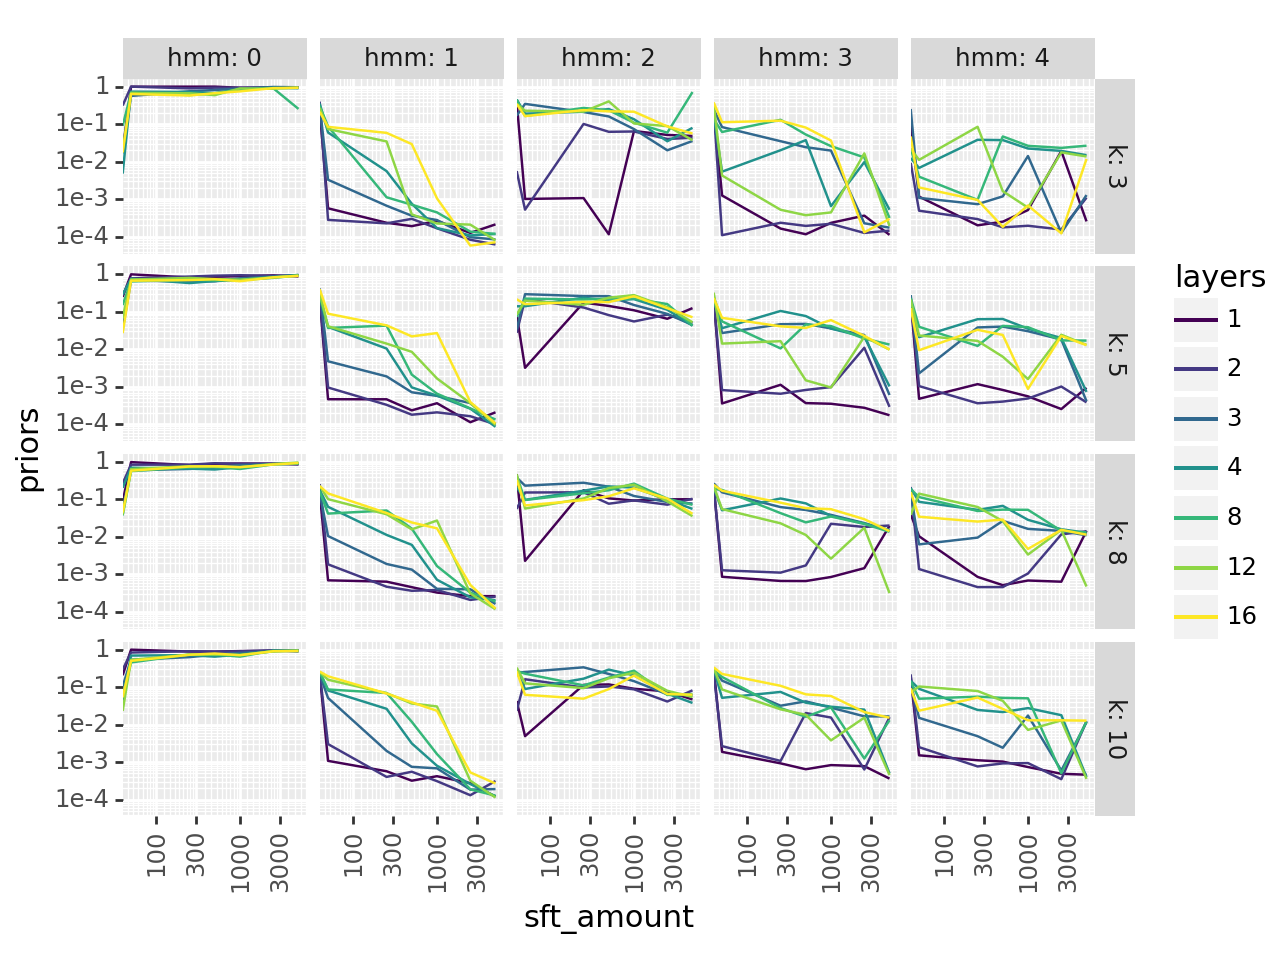

In [45]:
plot = (
    ggplot(df, aes(x='sft_amount', y='priors', color='layers')) +
    geom_line() + scale_x_log10() + theme(axis_text_x=element_text(rotation=90)) +
    scale_y_log10() +
    facet_grid("k~hmm", labeller="label_both")
)
print(plot)

In [52]:
import math

def inv_sigmoid(x):
    return -math.log((1-x)/x)

In [61]:
df['gammas_s'] = df.apply(lambda x: inv_sigmoid(x['gammas']), axis=1)
df

sft_amount   k  hmm       law    priors    gammas     betas         K  \
0           0.0   3    0  bayesian  0.019674  0.147148  0.125671  1.845644   
1           0.0   3    1  bayesian  0.239009  0.214668  0.121395  1.845644   
2           0.0   3    2  bayesian  0.397768  0.145471  0.161931  1.845644   
3           0.0   3    3  bayesian  0.250321  0.196507  0.105006  1.845644   
4           0.0   3    4  bayesian  0.093228  0.160974  0.116079  1.845644   
..          ...  ..  ...       ...       ...       ...       ...       ...   
540      5000.0  10    0  bayesian  0.909116  0.475441  0.001569  0.001004   
541      5000.0  10    1  bayesian  0.000268  0.084418  0.071891  0.001004   
542      5000.0  10    2  bayesian  0.062650  0.150061  0.003313  0.001004   
543      5000.0  10    3  bayesian  0.015231  0.142806  0.004896  0.001004   
544      5000.0  10    4  bayesian  0.012735  0.155852  0.008329  0.001004   

          mse   C  alpha  n_c layers      diff  priors_s  gammas_s  
0    0.088883 NaN    NaN  NaN      1  0.021477 -3.908595 -1.757148  
1    0.137650 NaN    NaN  NaN      1  0.093272 -1.158121 -1.297016  
2    0.106110 NaN    NaN  NaN      1 -0.016460 -0.414775 -1.770577  
3    0.113368 NaN    NaN  NaN      1  0.091501 -1.096900 -1.408269  
4    0.135997 NaN    NaN  NaN      1  0.044895 -2.274838 -1.650999  
..        ...  ..    ...  ...    ...       ...       ...       ...  
540  0.000601 NaN    NaN  NaN     16  0.473872  2.302886 -0.098315  
541  0.036079 NaN    NaN  NaN     16  0.012527 -8.222541 -2.383776  
542  0.061002 NaN    NaN  NaN     16  0.146749 -2.705491 -1.734120  
543  0.031540 NaN    NaN  NaN     16  0.137910 -4.169082 -1.792177  
544  0.033777 NaN    NaN  NaN     16  0.147523 -4.350607 -1.689421  

[980 rows x 16 columns]

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


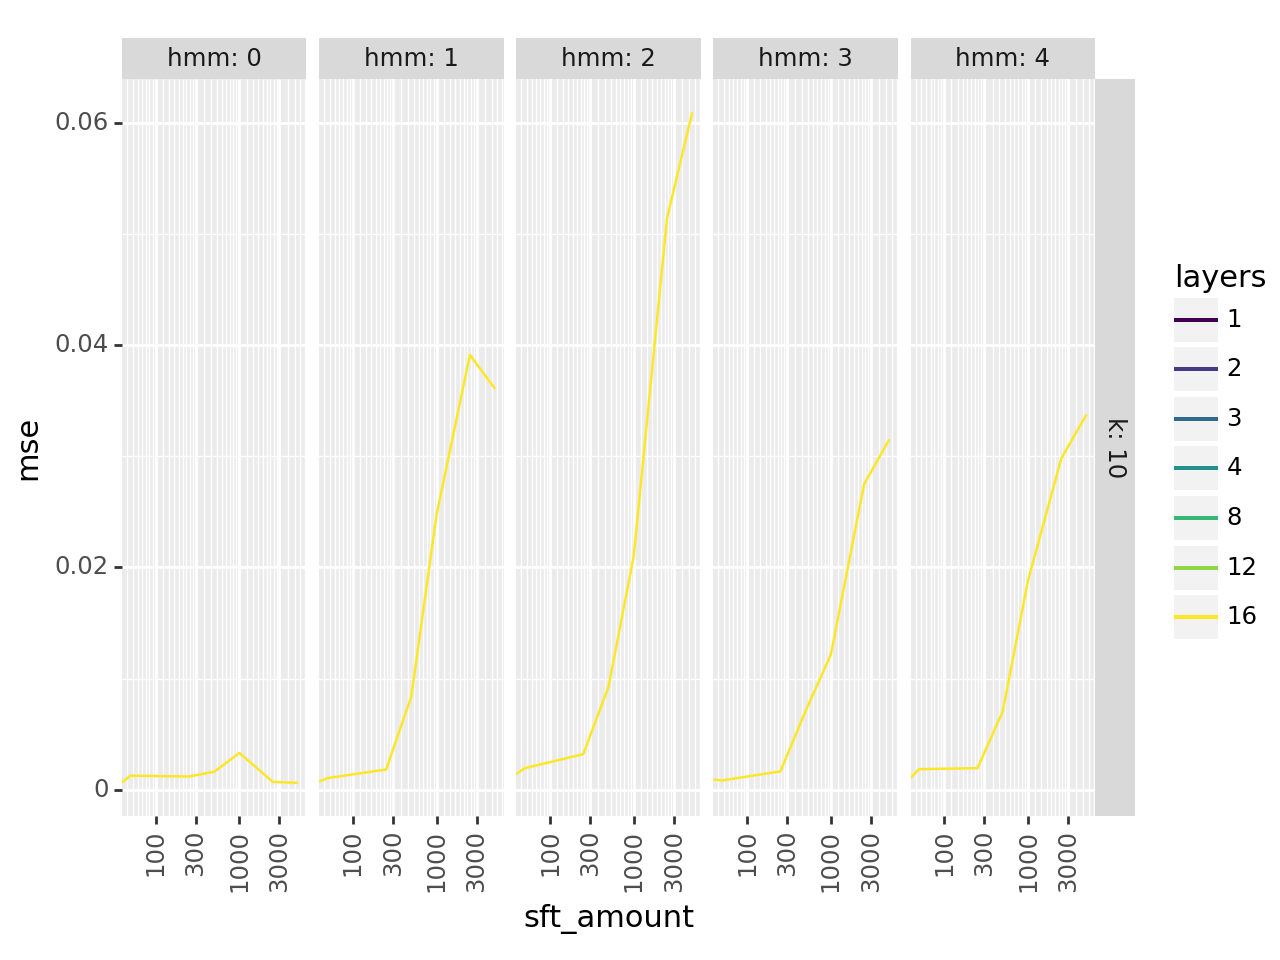

In [70]:
plot = (
    ggplot(df[(df["layers"] == '16') & (df["k"] == 10)], aes(x='sft_amount', y='mse', color='layers')) +
    geom_line() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("k~hmm", labeller="label_both") + scale_x_log10()
)
print(plot)